# ÌîÑÎ°úÏ†ùÌä∏: ÌïúÍµ≠Ïñ¥ Îç∞Ïù¥ÌÑ∞Î°ú Ï±óÎ¥á ÎßåÎì§Í∏∞ C1 Î•òÏßÄÌò∏

## Step 1. Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ï†ÑÏ≤òÎ¶¨ Í∞úÏÑ†

- data ÏàòÏßë: Songys, KorQuAD Îì± Îã§ÏñëÌïú ÌïúÍµ≠Ïñ¥ ÎåÄÌôî/ÏßàÏùòÏùëÎãµ Îç∞Ïù¥ÌÑ∞Î•º ÌÜµÌï© ÏàòÏßë
- ÏàòÌñâÌïú Ï†ÑÏ≤òÎ¶¨ Í≥ºÏ†ï: Î∂àÌïÑÏöîÌïú ÌäπÏàòÎ¨∏Ïûê/Î∂àÏö©Ïñ¥ Ï†úÍ±∞, ÌòïÌÉúÏÜå Î∂ÑÏÑù, Ï§ëÎ≥µ Î∞è ÌíàÏßà Ï†ÄÌïò ÏÉòÌîå ÌïÑÌÑ∞ÎßÅ 
- Í≤∞Í≥º: Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§ ÏóÜÏù¥ 99% Ïù¥ÏÉÅ Î≥¥Ï°¥Îêú Í≥†ÌíàÏßà ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨Ï∂ï

### 1-1. ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò Î∞è ÏûÑÌè¨Ìä∏

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json
from tqdm import tqdm
import pickle
import time
import random
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from collections import Counter, defaultdict
import warnings
import logging
from concurrent.futures import ThreadPoolExecutor

# Í≤ΩÍ≥† Î©îÏãúÏßÄ ÌïÑÌÑ∞ÎßÅ
warnings.filterwarnings('ignore')

# Î°úÍπÖ ÏÑ§Ï†ï
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("chatbot_preprocessing.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä ÌôïÏù∏
print("TensorFlow Î≤ÑÏ†Ñ:", tf.__version__)
print("GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä:", tf.config.list_physical_devices('GPU'))

# KoNLPy ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Î∞è ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò
!pip install konlpy
!pip install transformers
!pip install sentencepiece
!pip install soynlp
!pip install emoji
!pip install wordcloud
!pip install gensim
!pip install torch
!pip install pymongo

# ÌïúÍµ≠Ïñ¥ NLP Í¥ÄÎ†® ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
from konlpy.tag import Mecab, Okt, Hannanum, Kkma
from transformers import BertModel, BertTokenizer, ElectraModel, ElectraTokenizer
from soynlp.normalizer import repeat_normalize
from soynlp.word import WordExtractor
from gensim.models import Word2Vec, FastText
import emoji

TensorFlow Î≤ÑÏ†Ñ: 2.6.0
GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1-2 Í∏∞Î≥∏ Ïò§ÌîàÏÜåÏä§ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú

In [2]:
# Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
data_dir = "chatbot_data"
os.makedirs(data_dir, exist_ok=True)

# Ï±óÎ¥á Îç∞Ïù¥ÌÑ∞ÏÖã Î™©Î°ù Ï†ïÏùò
datasets = {
    "songys_chatbot": {
        "url": "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv",
        "filename": "ChatbotData.csv",
        "type": "csv"
    },
    "korquad": {
        "url": "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json",
        "filename": "KorQuAD_train.json",
        "type": "json"
    },
    "aihub_sample": {
        "url": None,  # ÏßÅÏ†ë Îã§Ïö¥Î°úÎìú ÌïÑÏöî
        "filename": "aihub_dialog_sample.csv",
        "type": "csv"
    }
}

# Îç∞Ïù¥ÌÑ∞ÏÖã Îã§Ïö¥Î°úÎìú Î∞è Î°úÎìú Ìï®Ïàò
def download_dataset(dataset_info):
    filepath = os.path.join(data_dir, dataset_info["filename"])
    
    # ÌååÏùºÏù¥ Ïù¥ÎØ∏ Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏
    if os.path.exists(filepath):
        logger.info(f"ÌååÏùº {dataset_info['filename']}Ïù¥(Í∞Ä) Ïù¥ÎØ∏ Ï°¥Ïû¨Ìï©ÎãàÎã§.")
    elif dataset_info["url"] is not None:
        logger.info(f"{dataset_info['filename']} Îã§Ïö¥Î°úÎìú Ï§ë...")
        try:
            urllib.request.urlretrieve(dataset_info["url"], filepath)
            logger.info(f"{dataset_info['filename']} Îã§Ïö¥Î°úÎìú ÏôÑÎ£å!")
        except Exception as e:
            logger.error(f"{dataset_info['filename']} Îã§Ïö¥Î°úÎìú Ïã§Ìå®: {e}")
            return None
    else:
        logger.warning(f"{dataset_info['filename']}ÏùÄ(Îäî) ÏàòÎèôÏúºÎ°ú Îã§Ïö¥Î°úÎìúÌï¥Ïïº Ìï©ÎãàÎã§.")
        return None
    
    return filepath

def load_dataset(dataset_info):
    filepath = download_dataset(dataset_info)
    if filepath is None:
        return None
    
    if dataset_info["type"] == "csv":
        try:
            return pd.read_csv(filepath)
        except Exception as e:
            logger.error(f"{filepath} Î°úÎìú Ïã§Ìå®: {e}")
            return None
    elif dataset_info["type"] == "json":
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            logger.error(f"{filepath} Î°úÎìú Ïã§Ìå®: {e}")
            return None
    else:
        logger.error(f"ÏßÄÏõêÌïòÏßÄ ÏïäÎäî ÌååÏùº ÌòïÏãù: {dataset_info['type']}")
        return None

# Í∞Å Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
loaded_datasets = {}
for name, info in datasets.items():
    logger.info(f"{name} Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú Ï§ë...")
    data = load_dataset(info)
    if data is not None:
        loaded_datasets[name] = data
        
        # Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ïÎ≥¥ Ï∂úÎ†•
        if isinstance(data, pd.DataFrame):
            logger.info(f"{name} Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: {len(data)}")
            logger.info(f"{name} Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº: {data.columns.tolist()}")
            logger.info(f"{name} Îç∞Ïù¥ÌÑ∞ÏÖã ÎØ∏Î¶¨Î≥¥Í∏∞:")
            print(data.head())
        elif name == "korquad":
            logger.info(f"{name} Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: {len(data['data'])}")
            
# Í∏∞Î≥∏ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖã (songys)
main_chat_data = loaded_datasets.get("songys_chatbot")
if main_chat_data is not None:
    print(f"Í∏∞Î≥∏ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: {len(main_chat_data)}")
    print(f"Í∏∞Î≥∏ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå:\n{main_chat_data.head()}")
else:
    logger.error("Í∏∞Î≥∏ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î°úÎìúÌï† Ïàò ÏóÜÏäµÎãàÎã§.")
    main_chat_data = pd.DataFrame(columns=["Q", "A", "label"])

2025-04-21 01:54:35,833 - __main__ - INFO - songys_chatbot Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú Ï§ë...
2025-04-21 01:54:35,834 - __main__ - INFO - ÌååÏùº ChatbotData.csvÏù¥(Í∞Ä) Ïù¥ÎØ∏ Ï°¥Ïû¨Ìï©ÎãàÎã§.
2025-04-21 01:54:35,864 - __main__ - INFO - songys_chatbot Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: 11823
2025-04-21 01:54:35,865 - __main__ - INFO - songys_chatbot Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº: ['Q', 'A', 'label']
2025-04-21 01:54:35,865 - __main__ - INFO - songys_chatbot Îç∞Ïù¥ÌÑ∞ÏÖã ÎØ∏Î¶¨Î≥¥Í∏∞:
2025-04-21 01:54:35,870 - __main__ - INFO - korquad Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú Ï§ë...
2025-04-21 01:54:35,871 - __main__ - INFO - ÌååÏùº KorQuAD_train.jsonÏù¥(Í∞Ä) Ïù¥ÎØ∏ Ï°¥Ïû¨Ìï©ÎãàÎã§.


                 Q            A  label
0           12Ïãú Îï°!   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.      0
1      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.      0
2     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.      0
3  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.      0
4          PPL Ïã¨ÌïòÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.      0


2025-04-21 01:54:36,620 - __main__ - INFO - korquad Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: 1420
2025-04-21 01:54:36,621 - __main__ - INFO - aihub_sample Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú Ï§ë...
2025-04-21 01:54:36,622 - __main__ - WARNING - aihub_dialog_sample.csvÏùÄ(Îäî) ÏàòÎèôÏúºÎ°ú Îã§Ïö¥Î°úÎìúÌï¥Ïïº Ìï©ÎãàÎã§.


Í∏∞Î≥∏ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: 11823
Í∏∞Î≥∏ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå:
                 Q            A  label
0           12Ïãú Îï°!   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.      0
1      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.      0
2     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.      0
3  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.      0
4          PPL Ïã¨ÌïòÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.      0


### 1-3 Ï∂îÍ∞Ä Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è ÌÜµÌï©

In [3]:
# KorQuAD Îç∞Ïù¥ÌÑ∞Î•º Q&A ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ìï®Ïàò
def convert_korquad_to_qa(korquad_data):
    qa_pairs = []
    
    try:
        for article in korquad_data["data"]:
            for paragraph in article["paragraphs"]:
                context = paragraph["context"]
                for qa in paragraph["qas"]:
                    question = qa["question"]
                    if qa["answers"]:
                        answer = qa["answers"][0]["text"]
                        qa_pairs.append({"Q": question, "A": answer, "context": context})
    except Exception as e:
        logger.error(f"KorQuAD Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò Ï§ë Ïò§Î•ò: {e}")
    
    return pd.DataFrame(qa_pairs)

# ÌÅ¨Î°§ÎßÅ ÏãúÎÆ¨Î†àÏù¥ÏÖò Ìï®Ïàò (Ïã§Ï†ú ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑúÎäî Ïõπ ÌÅ¨Î°§ÎßÅÏúºÎ°ú ÎåÄÏ≤¥)
def simulate_web_crawling():
    # ÏòàÏãú ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ (Ïã§Ï†úÎ°úÎäî ÏõπÏóêÏÑú ÌÅ¨Î°§ÎßÅ)
    simulated_dialogues = [
        {"Q": "Ïò§Îäò ÎÇ†Ïî® Ïñ¥Îïå?", "A": "Ïò§ÎäòÏùÄ ÎßëÍ≥† ÌôîÏ∞ΩÌïú ÎÇ†Ïî®ÏòàÏöî.", "source": "simulated"},
        {"Q": "Ï†êÏã¨ Î≠ê Î®πÏùÑÍπå?", "A": "Ïò§ÎäòÏùÄ ÌïúÏãù Ïñ¥Îñ†ÏÑ∏Ïöî?", "source": "simulated"},
        {"Q": "ÎÇ¥Ïùº Í≥ÑÌöç ÏûàÏñ¥?", "A": "ÏïÑÏßÅ ÌäπÎ≥ÑÌïú Í≥ÑÌöçÏùÄ ÏóÜÏäµÎãàÎã§.", "source": "simulated"},
        {"Q": "ÏòÅÌôî Ï∂îÏ≤úÌï¥Ï§ò", "A": "ÏöîÏ¶ò 'Ïù∏ÌÑ∞Ïä§ÌÖîÎùº'Í∞Ä Ïù∏Í∏∞ ÏûàÏñ¥Ïöî.", "source": "simulated"},
        {"Q": "Ï£ºÎßêÏóê Î≠êÌï¥?", "A": "ÏπúÍµ¨Îì§Í≥º ÎßåÎÇòÍ∏∞Î°ú ÌñàÏñ¥Ïöî.", "source": "simulated"},
        # Ï∂îÍ∞Ä ÎåÄÌôî ÏòàÏãú
        {"Q": "ÌïúÍµ≠Ïñ¥ Í≥µÎ∂ÄÌïòÎäî Î∞©Î≤ï ÏïåÎ†§Ï§ò", "A": "Îß§Ïùº Ï°∞Í∏àÏî© Îì£Í≥† ÎßêÌïòÎäî Ïó∞ÏäµÏùÑ ÌïòÎäî Í≤ÉÏù¥ Ï§ëÏöîÌï¥Ïöî.", "source": "simulated"},
        {"Q": "ÏÑúÏö∏ÏóêÏÑú Í∞ÄÎ≥ºÎßåÌïú Í≥≥ Ï∂îÏ≤úÌï¥Ï§ò", "A": "Í≤ΩÎ≥µÍ∂Å, ÎÇ®ÏÇ∞ÌÉÄÏõå, ÌïúÍ∞ïÍ≥µÏõê Îì±Ïù¥ Ïù∏Í∏∞ ÏûàÎäî Í¥ÄÍ¥ëÏßÄÏûÖÎãàÎã§.", "source": "simulated"},
        {"Q": "Ïù¥Î≤à Ï£ºÎßê ÎÇ†Ïî® Ïñ¥Îïå?", "A": "Ïù¥Î≤à Ï£ºÎßêÏùÄ ÎπÑ ÏÜåÏãùÏù¥ ÏûàÏñ¥Ïöî. Ïö∞ÏÇ∞ Ï±ôÍ∏∞ÏÑ∏Ïöî.", "source": "simulated"},
        {"Q": "ÌïúÍµ≠ ÏùåÏãù Ï§ëÏóê Ï∂îÏ≤úÌï¥Ï§Ñ ÎßåÌïú Í±∞ ÏûàÏñ¥?", "A": "ÎπÑÎπîÎ∞•, Î∂àÍ≥†Í∏∞, ÍπÄÏπòÏ∞åÍ∞ú Îì±Ïù¥ Ïô∏Íµ≠Ïù∏Îì§ÏóêÍ≤åÎèÑ Ïù∏Í∏∞Í∞Ä ÎßéÏïÑÏöî.", "source": "simulated"},
        {"Q": "ÌïúÍµ≠Ïñ¥Î°ú 'Í∞êÏÇ¨Ìï©ÎãàÎã§'Îäî Ïñ¥ÎñªÍ≤å ÎßêÌï¥?", "A": "'Í∞êÏÇ¨Ìï©ÎãàÎã§'ÎùºÍ≥† ÎßêÌïòÎ©¥ Îê©ÎãàÎã§. Í≤©Ïãù ÏóÜÏù¥Îäî 'Í≥†ÎßàÏõåÏöî'ÎùºÍ≥†ÎèÑ Ìï¥Ïöî.", "source": "simulated"}
    ]
    
    logger.info(f"Ïõπ ÌÅ¨Î°§ÎßÅ ÏãúÎÆ¨Î†àÏù¥ÏÖò: {len(simulated_dialogues)}Í∞ú ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±")
    return pd.DataFrame(simulated_dialogues)

# ÏÇ¨Ïö©Ïûê Ï†ïÏùò Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
def create_custom_dialogues():
    custom_qa_pairs = [
        {"Q": "ÎÑàÎäî ÎàÑÍµ¨Ïïº?", "A": "Ï†ÄÎäî ÌïúÍµ≠Ïñ¥Î°ú ÎåÄÌôîÌïòÎäî AI Ï±óÎ¥áÏûÖÎãàÎã§.", "category": "ÏÜåÍ∞ú"},
        {"Q": "Î≠ò ÎèÑÏôÄÏ§Ñ Ïàò ÏûàÏñ¥?", "A": "ÎåÄÌôî, Ï†ïÎ≥¥ Í≤ÄÏÉâ, Ï∂îÏ≤ú Îì± Îã§ÏñëÌïú Ï£ºÏ†úÎ°ú ÎèÑÏõÄÏùÑ ÎìúÎ¶¥ Ïàò ÏûàÏñ¥Ïöî.", "category": "ÏÜåÍ∞ú"},
        {"Q": "Ïò§Îäò Í∏∞Î∂ÑÏù¥ Ïïà Ï¢ãÏïÑ", "A": "Î¨¥Ïä® ÏùºÏù¥ ÏûàÏúºÏÖ®ÎÇòÏöî? Ï†úÍ∞Ä Í∏∞Î∂Ñ Ï†ÑÌôòÏóê ÎèÑÏõÄÏù¥ ÎêòÍ≥† Ïã∂Ïñ¥Ïöî.", "category": "Í∞êÏ†ï"},
        {"Q": "Ïû¨ÎØ∏ÏûàÎäî Ïù¥ÏïºÍ∏∞ Ìï¥Ï§ò", "A": "ÏòõÎÇ† ÏòõÏ†ÅÏóê Ìïú ÎßàÏùÑÏóê Ïû¨ÎØ∏ÏûàÎäî Ïù¥ÏïºÍ∏∞ÍæºÏù¥ ÏÇ¥ÏïòÏäµÎãàÎã§...", "category": "ÏóîÌÑ∞ÌÖåÏù∏Î®ºÌä∏"},
        {"Q": "ÏãúÍ∞ÑÏù¥ Î™áÏù¥Ïïº?", "A": "Ï†úÍ∞Ä Ïã§ÏãúÍ∞Ñ ÏãúÍ≥ÑÏóê Ï†ëÍ∑ºÌï† Ïàò ÏóÜÏñ¥ÏÑú Ï†ïÌôïÌïú ÏãúÍ∞ÑÏùÑ ÏïåÎ†§ÎìúÎ¶¨ÏßÄ Î™ªÌï¥Ïöî. Í∏∞Í∏∞Ïùò ÏãúÍ∞ÑÏùÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.", "category": "ÏùºÎ∞ò"},
        # Ï∂îÍ∞Ä ÎåÄÌôî ÏòàÏãú
        {"Q": "ÌïúÍµ≠Ïùò ÏàòÎèÑÎäî?", "A": "ÌïúÍµ≠Ïùò ÏàòÎèÑÎäî ÏÑúÏö∏ÏûÖÎãàÎã§.", "category": "ÏßÄÏãù"},
        {"Q": "Ïù∏Í≥µÏßÄÎä•Ïù¥ Î≠êÏïº?", "A": "Ïù∏Í≥µÏßÄÎä•ÏùÄ Ïù∏Í∞ÑÏùò ÌïôÏäµÎä•Î†•, Ï∂îÎ°†Îä•Î†•, ÏßÄÍ∞ÅÎä•Î†•ÏùÑ Ïù∏Í≥µÏ†ÅÏúºÎ°ú Íµ¨ÌòÑÌïú Ïª¥Ìì®ÌÑ∞ ÏãúÏä§ÌÖúÏûÖÎãàÎã§.", "category": "ÏßÄÏãù"},
        {"Q": "Ïò§Îäò ÎÇ†Ïî® Ïñ¥Îïå?", "A": "Ï†úÍ∞Ä Ïã§ÏãúÍ∞Ñ ÎÇ†Ïî® Ï†ïÎ≥¥Ïóê Ï†ëÍ∑ºÌï† Ïàò ÏóÜÏñ¥Ïöî. ÎÇ†Ïî® Ïï±Ïù¥ÎÇò ÏõπÏÇ¨Ïù¥Ìä∏Î•º ÌôïÏù∏Ìï¥Î≥¥ÏÑ∏Ïöî.", "category": "ÏùºÎ∞ò"},
        {"Q": "Ïä¨Ìçº", "A": "Î¨¥Ïä® ÏùºÏù¥ ÏûàÏúºÏã†Í∞ÄÏöî? Ïù¥ÏïºÍ∏∞ ÎÇòÎàÑÍ≥† Ïã∂ÏúºÏãúÎ©¥ Ï†ÄÏóêÍ≤å ÎßêÏîÄÌï¥Ï£ºÏÑ∏Ïöî.", "category": "Í∞êÏ†ï"},
        {"Q": "Ï¢ãÏïÑÌïòÎäî ÏùåÏãùÏù¥ Î≠êÏïº?", "A": "Ï†ÄÎäî AIÎùºÏÑú Ïã§Ï†úÎ°ú ÏùåÏãùÏùÑ Î®πÏßÄ ÏïäÏßÄÎßå, ÌïúÍµ≠ ÏùåÏãùÏóê ÎåÄÌï¥ ÎßéÏù¥ Î∞∞Ïõ†Ïñ¥Ïöî.", "category": "ÏÜåÍ∞ú"}
    ]
    
    logger.info(f"ÏÇ¨Ïö©Ïûê Ï†ïÏùò ÎåÄÌôî Îç∞Ïù¥ÌÑ∞: {len(custom_qa_pairs)}Í∞ú ÏÉùÏÑ±")
    return pd.DataFrame(custom_qa_pairs)

# Îç∞Ïù¥ÌÑ∞ ÌÜµÌï©
# 1. KorQuAD Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò (ÏûàÎäî Í≤ΩÏö∞)
korquad_qa = None
if "korquad" in loaded_datasets:
    korquad_qa = convert_korquad_to_qa(loaded_datasets["korquad"])
    logger.info(f"KorQuAD Q&A Î≥ÄÌôò Í≤∞Í≥º: {len(korquad_qa)}Í∞ú")
    # ÏÉòÌîåÎßÅÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞ Í¥ÄÎ¶¨
    if len(korquad_qa) > 1000:
        korquad_qa = korquad_qa.sample(1000, random_state=42)
        logger.info(f"KorQuAD Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ: 1000Í∞ú")

# 2. Ïõπ ÌÅ¨Î°§ÎßÅ Îç∞Ïù¥ÌÑ∞ (ÏãúÎÆ¨Î†àÏù¥ÏÖò)
crawled_data = simulate_web_crawling()

# 3. ÏÇ¨Ïö©Ïûê Ï†ïÏùò Îç∞Ïù¥ÌÑ∞
custom_data = create_custom_dialogues()

# 4. Îç∞Ïù¥ÌÑ∞ ÌÜµÌï©
all_chat_data = []

# Í∏∞Î≥∏ ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä
if main_chat_data is not None:
    main_chat_data['source'] = 'songys'
    all_chat_data.append(main_chat_data[['Q', 'A', 'source']])

# KorQuAD Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä (ÏûàÎäî Í≤ΩÏö∞)
if korquad_qa is not None:
    korquad_qa['source'] = 'korquad'
    all_chat_data.append(korquad_qa[['Q', 'A', 'source']])

# ÌÅ¨Î°§ÎßÅ Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä
all_chat_data.append(crawled_data[['Q', 'A', 'source']])

# ÏÇ¨Ïö©Ïûê Ï†ïÏùò Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä
custom_data['source'] = 'custom'
all_chat_data.append(custom_data[['Q', 'A', 'source']])

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ëÌï©
combined_df = pd.concat(all_chat_data, ignore_index=True)

# Ï§ëÎ≥µ Ï†úÍ±∞
combined_df = combined_df.drop_duplicates(subset=['Q', 'A'])

logger.info(f"ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: {len(combined_df)}")
logger.info(f"Ï∂úÏ≤òÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ïàò: {combined_df['source'].value_counts().to_dict()}")
print(f"ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå:\n{combined_df.head()}")

# Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÄÏû•
combined_df.to_csv(os.path.join(data_dir, 'combined_chat_data.csv'), index=False)
logger.info(f"ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÄÏû• ÏôÑÎ£å: {os.path.join(data_dir, 'combined_chat_data.csv')}")

2025-04-21 01:54:36,721 - __main__ - INFO - KorQuAD Q&A Î≥ÄÌôò Í≤∞Í≥º: 60407Í∞ú
2025-04-21 01:54:36,726 - __main__ - INFO - KorQuAD Îç∞Ïù¥ÌÑ∞ ÏÉòÌîåÎßÅ: 1000Í∞ú
2025-04-21 01:54:36,726 - __main__ - INFO - Ïõπ ÌÅ¨Î°§ÎßÅ ÏãúÎÆ¨Î†àÏù¥ÏÖò: 10Í∞ú ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
2025-04-21 01:54:36,728 - __main__ - INFO - ÏÇ¨Ïö©Ïûê Ï†ïÏùò ÎåÄÌôî Îç∞Ïù¥ÌÑ∞: 10Í∞ú ÏÉùÏÑ±
2025-04-21 01:54:36,745 - __main__ - INFO - ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: 12770
2025-04-21 01:54:36,746 - __main__ - INFO - Ï∂úÏ≤òÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ïàò: {'songys': 11750, 'korquad': 1000, 'simulated': 10, 'custom': 10}
2025-04-21 01:54:36,777 - __main__ - INFO - ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÄÏû• ÏôÑÎ£å: chatbot_data/combined_chat_data.csv


ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå:
                 Q            A  source
0           12Ïãú Îï°!   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.  songys
1      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.  songys
2     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.  songys
3  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.  songys
4          PPL Ïã¨ÌïòÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.  songys


### 1-4 Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ ÌÜµÍ≥Ñ Î∞è ÏãúÍ∞ÅÌôî

2025-04-21 01:54:36,792 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù ÏãúÏûë...


Ï¥ù ÎåÄÌôî Ïåç: 12770
ÏßàÎ¨∏ ÌèâÍ∑† Í∏∏Ïù¥: 14.47
ÏßàÎ¨∏ ÏµúÎåÄ Í∏∏Ïù¥: 86
ÏßàÎ¨∏ ÏµúÏÜå Í∏∏Ïù¥: 1
ÏùëÎãµ ÌèâÍ∑† Í∏∏Ïù¥: 14.30
ÏùëÎãµ ÏµúÎåÄ Í∏∏Ïù¥: 77
ÏùëÎãµ ÏµúÏÜå Í∏∏Ïù¥: 1


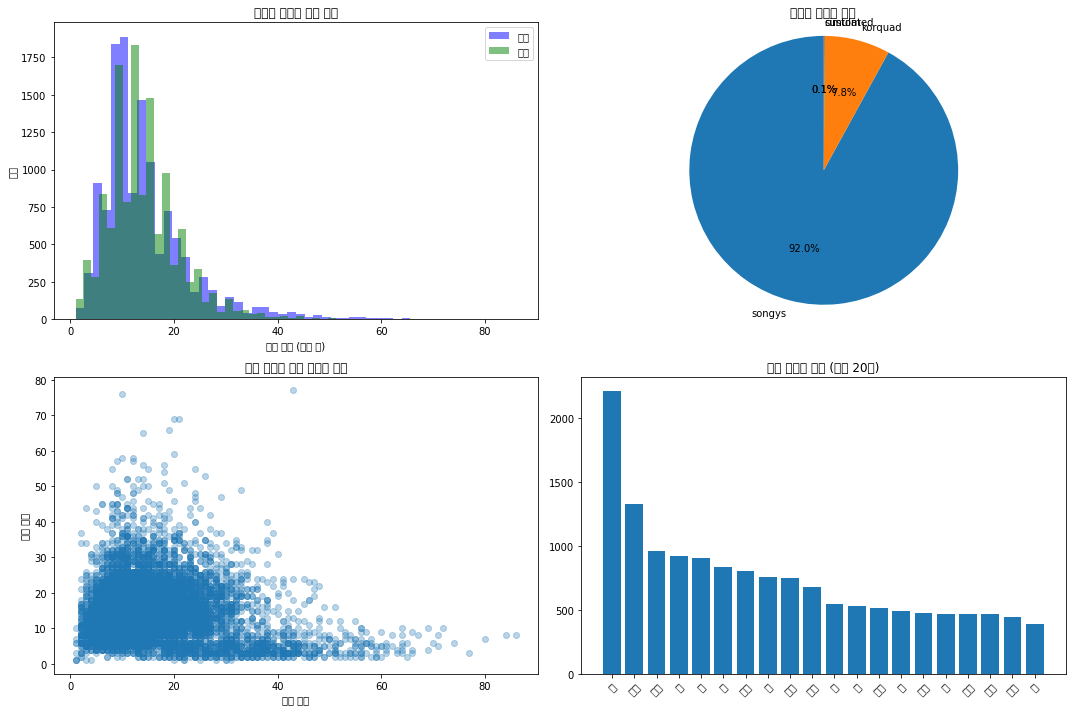

In [4]:
def analyze_chat_data(df):
    logger.info("Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù ÏãúÏûë...")
    
    # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
    q_lengths = df['Q'].apply(len)
    a_lengths = df['A'].apply(len)
    
    stats = {
        "Ï¥ù ÎåÄÌôî Ïåç": len(df),
        "ÏßàÎ¨∏ ÌèâÍ∑† Í∏∏Ïù¥": q_lengths.mean(),
        "ÏßàÎ¨∏ ÏµúÎåÄ Í∏∏Ïù¥": q_lengths.max(),
        "ÏßàÎ¨∏ ÏµúÏÜå Í∏∏Ïù¥": q_lengths.min(),
        "ÏùëÎãµ ÌèâÍ∑† Í∏∏Ïù¥": a_lengths.mean(),
        "ÏùëÎãµ ÏµúÎåÄ Í∏∏Ïù¥": a_lengths.max(),
        "ÏùëÎãµ ÏµúÏÜå Í∏∏Ïù¥": a_lengths.min()
    }
    
    for key, value in stats.items():
        print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")
    
    # Í∑∏ÎûòÌîÑ ÏÑ§Ï†ï
    plt.figure(figsize=(15, 10))
    
    # 1. ÏßàÎ¨∏/ÎãµÎ≥Ä Í∏∏Ïù¥ Î∂ÑÌè¨
    plt.subplot(2, 2, 1)
    plt.hist(q_lengths, bins=50, alpha=0.5, color='blue', label='ÏßàÎ¨∏')
    plt.hist(a_lengths, bins=50, alpha=0.5, color='green', label='ÎãµÎ≥Ä')
    plt.xlabel('Î¨∏Ïû• Í∏∏Ïù¥ (Í∏ÄÏûê Ïàò)')
    plt.ylabel('ÎπàÎèÑ')
    plt.title('ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏùò Í∏∏Ïù¥ Î∂ÑÌè¨')
    plt.legend()
    
    # 2. Ï∂úÏ≤òÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®
    plt.subplot(2, 2, 2)
    source_counts = df['source'].value_counts()
    plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Îç∞Ïù¥ÌÑ∞ Ï∂úÏ≤òÎ≥Ñ ÎπÑÏú®')
    
    # 3. ÏßàÎ¨∏ Í∏∏Ïù¥ÏôÄ ÎãµÎ≥Ä Í∏∏Ïù¥Ïùò Í¥ÄÍ≥Ñ
    plt.subplot(2, 2, 3)
    plt.scatter(q_lengths, a_lengths, alpha=0.3)
    plt.xlabel('ÏßàÎ¨∏ Í∏∏Ïù¥')
    plt.ylabel('ÎãµÎ≥Ä Í∏∏Ïù¥')
    plt.title('ÏßàÎ¨∏ Í∏∏Ïù¥ÏôÄ ÎãµÎ≥Ä Í∏∏Ïù¥Ïùò Í¥ÄÍ≥Ñ')
    
    # 4. Í∞ÄÏû• ÎπàÎ≤àÌïú Îã®Ïñ¥ (ÏÉÅÏúÑ 20Í∞ú)
    plt.subplot(2, 2, 4)
    
    # Í∞ÑÎã®Ìïú Îã®Ïñ¥ ÎπàÎèÑ Î∂ÑÏÑù
    try:
        # MecabÏù¥ ÏûàÏúºÎ©¥ ÏÇ¨Ïö©, ÏóÜÏúºÎ©¥ Îã®Ïàú Í≥µÎ∞± Î∂ÑÎ¶¨
        try:
            from konlpy.tag import Mecab
            mecab = Mecab()
            all_words = []
            for text in df['Q'].str.cat(df['A'], sep=' '):
                all_words.extend(mecab.nouns(text))
        except:
            all_words = []
            for text in df['Q'].str.cat(df['A'], sep=' ').split():
                all_words.append(text)
                
        word_counts = Counter(all_words)
        common_words = dict(word_counts.most_common(20))
        
        plt.bar(range(len(common_words)), list(common_words.values()), align='center')
        plt.xticks(range(len(common_words)), list(common_words.keys()), rotation=45)
        plt.title('Í∞ÄÏû• ÎπàÎ≤àÌïú Îã®Ïñ¥ (ÏÉÅÏúÑ 20Í∞ú)')
    except Exception as e:
        logger.error(f"Îã®Ïñ¥ ÎπàÎèÑ Î∂ÑÏÑù Ï§ë Ïò§Î•ò: {e}")
        plt.text(0.5, 0.5, 'Îã®Ïñ¥ ÎπàÎèÑ Î∂ÑÏÑù Ïã§Ìå®', horizontalalignment='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'chat_data_analysis.png'))
    plt.show()
    
    return stats

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Ïã§Ìñâ
data_stats = analyze_chat_data(combined_df)

### 1-5 Í≥†Í∏â ÌÖçÏä§Ìä∏ Î∂ÑÏÑù

2025-04-21 01:54:39,118 - __main__ - INFO - Í≥†Í∏â ÌÖçÏä§Ìä∏ Ìå®ÌÑ¥ Î∂ÑÏÑù ÏãúÏûë...



Í∞êÏ†ï ÌëúÌòÑ Ìå®ÌÑ¥ Î∂ÑÏÑù:
Í∏çÏ†ï: 1580Í∞ú (12.37%)
Î∂ÄÏ†ï: 723Í∞ú (5.66%)
ÏßàÎ¨∏: 4435Í∞ú (34.73%)
Î™ÖÎ†π: 797Í∞ú (6.24%)
Ïù∏ÏÇ¨: 333Í∞ú (2.61%)


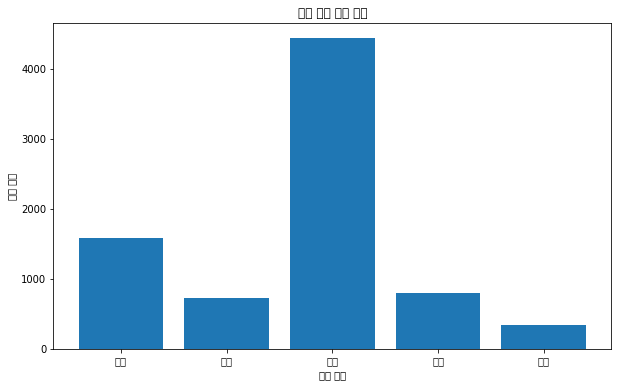


ÏûêÏ£º Ìï®Íªò Îì±Ïû•ÌïòÎäî Îã®Ïñ¥ Ïåç:
Ïó¨Ïûê - ÏπúÍµ¨: 233Ìöå
ÎÇ®Ïûê - ÏπúÍµ¨: 213Ìöå
ÏÇ¨Îûå - ÏÇ¨Îûë: 54Ìöå
ÎÇ®Ïûê - Ïó¨Ïûê: 49Ìöå
ÏÇ¨Îûå - ÏÉùÍ∞Å: 21Ìöå
Î¨¥Ïóá - Ïù¥Î¶Ñ: 21Ìöå
ÏÇ¨Îûå - ÏßùÏÇ¨Îûë: 20Ìöå
Í≥†ÎØº - ÏπúÍµ¨: 18Ìöå
ÏÇ¨Îûå - ÏÇ¨Îûå: 17Ìöå
Ïó¨Ïûê - Ïó∞ÎùΩ: 17Ìöå
Ïó∞ÎùΩ - ÏπúÍµ¨: 16Ìöå
Ïù¥Î≥Ñ - Ï§ÄÎπÑ: 16Ìöå
Ïù¥Î≥Ñ - ÌÜµÎ≥¥: 16Ìöå
ÎßàÏùå - ÏÇ¨Îûå: 14Ìöå
ÏπúÍµ¨ - ÏπúÍµ¨: 14Ìöå
Í∞úÏõî - Ïù¥Î≥Ñ: 14Ìöå
Ïó¨Ïûê - ÏßùÏÇ¨Îûë: 14Ìöå
Í≤∞Ìòº - ÏÇ¨Îûë: 14Ìöå
ÎàÑÍµ¨ - ÏÇ¨Îûå: 13Ìöå
Í∑∏ÎÖÄ - ÏÉùÍ∞Å: 13Ìöå


In [5]:
def analyze_text_patterns(df):
    logger.info("Í≥†Í∏â ÌÖçÏä§Ìä∏ Ìå®ÌÑ¥ Î∂ÑÏÑù ÏãúÏûë...")
    
    # Í∞êÏ†ï ÌëúÌòÑ Ìå®ÌÑ¥ (Ïù¥Î™®Ìã∞ÏΩò, Í∞êÏ†ï ÌëúÌòÑ Îã®Ïñ¥ Îì±)
    emotion_patterns = {
        'Í∏çÏ†ï': r'Ï¢ãÏïÑ|Í∞êÏÇ¨|ÌñâÎ≥µ|Î©ãÏßÄ|ÏµúÍ≥†|Ïß±|Ï¢ãÏùÄ|„Öã„Öã|„Öé„Öé|üòä|üòÑ|‚ô•|‚ù§',
        'Î∂ÄÏ†ï': r'Ïã´Ïñ¥|ÏïàÏ¢ã|Î™ªÌï¥|Ïã§Ìå®|ÎÇòÏÅú|ÌûòÎì§|Ïñ¥Î†§|Î∂àÌñâ|Ïä¨Ìîî|ÌôîÎÇò|„Öú„Öú|„Ö†„Ö†|üò¢|üò≠|üò†',
        'ÏßàÎ¨∏': r'\?|\Ôºü|Ïñ¥Îñª|Ïñ∏Ï†ú|ÎàÑÍµ¨|ÏñºÎßà|Ïôú|Î¨¥Ïóá|Î≠ê|Î™á|Íπå|ÎÇòÏöî|Í∞ÄÏöî|ÎûòÏöî|„Öá„Öá|ÏßÑÏßú',
        'Î™ÖÎ†π': r'Ìï¥Ï£º|Ìï¥Î¥ê|ÏïåÎ†§|Í∞ÄÎ•¥Ï≥ê|Ï∞æÏïÑ|ÏãúÏûë|Ï¢ÖÎ£å|Í∑∏Îßå|Ï§ëÏßÄ|Í≥ÑÏÜç',
        'Ïù∏ÏÇ¨': r'ÏïàÎÖï|Î∞òÍ∞ÄÏõå|ÎòêÎ¥ê|ÏûòÍ∞Ä|Îã§ÏùåÏóê|ÎßåÎÇò|ÌïòÏù¥|Ìó¨Î°ú|ÍµøÎ™®Îãù|ÍµøÎÇòÏûá'
    }
    
    emotion_counts = {emotion: 0 for emotion in emotion_patterns}
    
    # ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏóêÏÑú Í∞êÏ†ï Ìå®ÌÑ¥ Í≤ÄÏ∂ú
    for idx, row in df.iterrows():
        for emotion, pattern in emotion_patterns.items():
            if re.search(pattern, row['Q']) or re.search(pattern, row['A']):
                emotion_counts[emotion] += 1
    
    # Í≤∞Í≥º Ï∂úÎ†•
    print("\nÍ∞êÏ†ï ÌëúÌòÑ Ìå®ÌÑ¥ Î∂ÑÏÑù:")
    for emotion, count in emotion_counts.items():
        print(f"{emotion}: {count}Í∞ú ({count/len(df)*100:.2f}%)")
    
    # ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_counts.keys(), emotion_counts.values())
    plt.title('Í∞êÏ†ï ÌëúÌòÑ Ìå®ÌÑ¥ Î∂ÑÌè¨')
    plt.xlabel('Í∞êÏ†ï Ìå®ÌÑ¥')
    plt.ylabel('Î∞úÏÉù ÌöüÏàò')
    plt.savefig(os.path.join(data_dir, 'emotion_pattern_analysis.png'))
    plt.show()
    
    # Îã®Ïñ¥ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù (ÏûêÏ£º Ìï®Íªò Îì±Ïû•ÌïòÎäî Îã®Ïñ¥ Ïåç)
    try:
        # ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî
        try:
            from konlpy.tag import Mecab
            mecab = Mecab()
            tokenize = lambda text: mecab.nouns(text)
        except:
            tokenize = lambda text: text.split()
        
        # ÎèôÏãú Î∞úÏÉù Îã®Ïñ¥ Ïåç Î∂ÑÏÑù
        word_pairs = defaultdict(int)
        for text in df['Q']:
            words = tokenize(text)
            for i in range(len(words)-1):
                for j in range(i+1, min(i+3, len(words))):
                    if words[i] and words[j] and len(words[i]) > 1 and len(words[j]) > 1:
                        word_pair = tuple(sorted([words[i], words[j]]))
                        word_pairs[word_pair] += 1
        
        # Í∞ÄÏû• ÎπàÎ≤àÌïú Îã®Ïñ¥ Ïåç
        common_pairs = dict(sorted(word_pairs.items(), key=lambda x: x[1], reverse=True)[:20])
        
        print("\nÏûêÏ£º Ìï®Íªò Îì±Ïû•ÌïòÎäî Îã®Ïñ¥ Ïåç:")
        for pair, count in common_pairs.items():
            print(f"{pair[0]} - {pair[1]}: {count}Ìöå")
    
    except Exception as e:
        logger.error(f"Îã®Ïñ¥ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù Ï§ë Ïò§Î•ò: {e}")
    
    return emotion_counts

# ÌÖçÏä§Ìä∏ Ìå®ÌÑ¥ Î∂ÑÏÑù Ïã§Ìñâ
emotion_stats = analyze_text_patterns(combined_df)

### 1-6 ÌÜµÌï© ÌïúÍµ≠Ïñ¥ Ï†ÑÏ≤òÎ¶¨ ÌÅ¥ÎûòÏä§ Íµ¨ÌòÑ

In [6]:
class KoreanTextPreprocessor:
    """ÌïúÍµ≠Ïñ¥ ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌïú ÌÜµÌï© ÌÅ¥ÎûòÏä§"""
    
    def __init__(self, use_mecab=True, use_soynlp=True):
        logger.info("ÌïúÍµ≠Ïñ¥ ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï¥àÍ∏∞Ìôî Ï§ë...")
        
        # ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî
        self.morpheme_analyzer = None
        if use_mecab:
            try:
                from konlpy.tag import Mecab
                self.morpheme_analyzer = Mecab()
                logger.info("Mecab ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ")
            except Exception as e:
                logger.warning(f"Mecab Ï¥àÍ∏∞Ìôî Ïã§Ìå®: {e}")
                
        if self.morpheme_analyzer is None:
            try:
                from konlpy.tag import Okt
                self.morpheme_analyzer = Okt()
                logger.info("Okt ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ")
            except Exception as e:
                logger.error(f"Okt Ï¥àÍ∏∞Ìôî Ïã§Ìå®: {e}")
                logger.error("ÌòïÌÉúÏÜå Î∂ÑÏÑù Í∏∞Îä•Ïù¥ ÎπÑÌôúÏÑ±ÌôîÎê©ÎãàÎã§.")
        
        # SoyNLP ÏÇ¨Ïö© ÏÑ§Ï†ï
        self.use_soynlp = use_soynlp
        
        # Î∂àÏö©Ïñ¥ Î™©Î°ù Î°úÎìú
        self.stopwords = self.load_stopwords()
        
        # Ïã†Ï°∞Ïñ¥ Î∞è Ï∂ïÏïΩÏñ¥ ÏÇ¨Ï†Ñ Ï¥àÍ∏∞Ìôî
        self.slang_dict = self.initialize_slang_dict()
        
        # Ï†ïÍ∑úÌëúÌòÑÏãù Ìå®ÌÑ¥ Ïª¥ÌååÏùº
        self.patterns = {
            'url': re.compile(r'https?://\S+|www\.\S+'),
            'email': re.compile(r'\S+@\S+'),
            'emoji_pattern': re.compile('['
                u'\U0001F600-\U0001F64F'  # Ïù¥Î™®Ìã∞ÏΩò
                u'\U0001F300-\U0001F5FF'  # Ïã¨Î≥º Î∞è ÌîΩÌÜ†Í∑∏Îû®
                u'\U0001F680-\U0001F6FF'  # ÍµêÌÜµ Î∞è ÏßÄÎèÑ Ïã¨Î≥º
                u'\U0001F700-\U0001F77F'  # ÏïåÏºÄÎØ∏
                u'\U0001F780-\U0001F7FF'  # Í∏∞ÌïòÌïôÏ†Å Î™®Ïñë
                u'\U0001F800-\U0001F8FF'  # Î∂ÄÍ∞ÄÏ†ÅÏù∏ ÌôîÏÇ¥Ìëú
                u'\U0001F900-\U0001F9FF'  # Î∂ÄÍ∞ÄÏ†ÅÏù∏ Ïã¨Î≥º
                u'\U0001FA00-\U0001FA6F'  # ÌôïÏû•Îêú Ïã¨Î≥º
                u'\U00002702-\U000027B0'  # Í∏∞ÌÉÄ Ïã¨Î≥º
                u'\U000024C2-\U0001F251' 
                u'\U0001f926-\U0001f937'  # ÏÇ¨Îûå Ïù¥Î™®Ìã∞ÏΩò
                ']+'),
            'special_chars': re.compile(r"[^Í∞Ä-Ìû£a-zA-Z0-9\s?.!,~]"),
            'numbers': re.compile(r'\d+'),
            'multiple_spaces': re.compile(r'\s+'),
            'jamo_pattern': re.compile(r'[„Ñ±-„Öé„Öè-„Ö£]{2,}')
        }
        
        logger.info("ÌïúÍµ≠Ïñ¥ ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    
    def load_stopwords(self):
        """ÌïúÍµ≠Ïñ¥ Î∂àÏö©Ïñ¥ Î™©Î°ù Î°úÎìú"""
        # Í∏∞Î≥∏ Î∂àÏö©Ïñ¥ Î™©Î°ù (ÏµúÏÜåÌôîÌïòÏó¨ Ï§ëÏöî Îã®Ïñ¥ Î≥¥Ï°¥)
        basic_stopwords = {
            'Ïù¥', 'Í∑∏', 'Ï†Ä', 'Í≤É', 'Ïàò', 'Îì±', 'Îì§', 'Ïóê', 'Ïùò', 'Í∞Ä', 
            'Í≥º', 'ÎèÑ', 'Î•º', 'ÏúºÎ°ú', 'Ïûê', 'ÏóêÏÑú', 'ÏôÄ'
        }
        
        # Ï∂îÍ∞Ä Î∂àÏö©Ïñ¥ ÌååÏùºÏù¥ ÏûàÏúºÎ©¥ Î°úÎìú
        try:
            stopwords_file = os.path.join(data_dir, 'korean_stopwords.txt')
            if os.path.exists(stopwords_file):
                with open(stopwords_file, 'r', encoding='utf-8') as f:
                    file_stopwords = set([line.strip() for line in f])
                return basic_stopwords.union(file_stopwords)
        except Exception as e:
            logger.warning(f"Î∂àÏö©Ïñ¥ ÌååÏùº Î°úÎìú Ïã§Ìå®: {e}")
        
        return basic_stopwords
    
    def initialize_slang_dict(self):
        """Ïã†Ï°∞Ïñ¥ Î∞è Ï∂ïÏïΩÏñ¥ ÏÇ¨Ï†Ñ Ï¥àÍ∏∞Ìôî"""
        # Í∏∞Î≥∏ Ïã†Ï°∞Ïñ¥/Ï∂ïÏïΩÏñ¥ ÏÇ¨Ï†Ñ
        slang_dict = {
            # Ï∂ïÏïΩÏñ¥
            '„Ñ±„ÖÖ': 'Í∞êÏÇ¨',
            '„Ñ¥„Ñ¥': 'ÎÖ∏ÎÖ∏',
            '„Öá„Öá': 'ÏùëÏùë',
            '„Öá„Öã': 'Ïò§ÏºÄÏù¥',
            '„Öã„Öã': 'ÏõÉÏùå',
            '„Öé„Öé': 'ÏõÉÏùå',
            '„Ñ∑„Ñ∑': 'ÎçúÎçú',
            '„Ö†„Ö†': 'Ïä¨Ìîî',
            '„Öú„Öú': 'Ïä¨Ìîî',
            '„Ö°„Ö°': 'Î¨¥ÌëúÏ†ï',
            
            # Ïã†Ï°∞Ïñ¥
            'Í∞ëÌà≠ÌäÄ': 'Í∞ëÏûêÍ∏∞ Ìà≠ ÌäÄÏñ¥ÎÇòÏò®',
            'Íæ∏ÏïàÍæ∏': 'Íæ∏ÎØº ÎìØ Ïïà Íæ∏ÎØº ÎìØ',
            'Î≥ÑÎã§Ï§Ñ': 'Î≥Ñ Îã§Î•∏ Ï§ÑÍ±∞Î¶¨',
            'ÏñµÌÖê': 'ÏñµÏßÄ ÌÖêÏÖò',
            'ÏôÑÎÇ¥Ïä§': 'ÏôÑÏ†Ñ ÎÇ¥ Ïä§ÌÉÄÏùº',
            'Ï¢ãÎåìÍµ¨Ïïå': 'Ï¢ãÏïÑÏöî ÎåìÍ∏Ä Íµ¨ÎèÖ ÏïåÎ¶ºÏÑ§Ï†ï',
            'ÏºÄÎ∞îÏºÄ': 'ÏºÄÏù¥Ïä§ Î∞îÏù¥ ÏºÄÏù¥Ïä§',
            'Ï†êÎ©îÏ∂î': 'Ï†êÏã¨ Î©îÎâ¥ Ï∂îÏ≤ú',
            'ÏÜåÌôïÌñâ': 'ÏÜåÏÜåÌïòÏßÄÎßå ÌôïÏã§Ìïú ÌñâÎ≥µ',
            'Ïù∏Ïã∏': 'Ïù∏ÏÇ¨Ïù¥Îçî',
            'ÏïÑÏã∏': 'ÏïÑÏõÉÏÇ¨Ïù¥Îçî',
            'Ïä§Î∂àÏû¨': 'Ïä§Ïä§Î°ú Î∂àÎü¨Ïò® Ïû¨Ïïô',
            'Îñ°ÏÉÅ': 'Í∏âÎì±',
            'Îñ°ÎùΩ': 'Í∏âÎùΩ',
            'ÏùºÏΩîÎÖ∏ÎØ∏': 'Ïùº + Ïù¥ÏΩîÎÖ∏ÎØ∏',
            'ÌïµÎ∂àÌò∏': 'Îß§Ïö∞ Ïã´Ïùå',
            'ÌïµÏ∂î': 'Îß§Ïö∞ Ï∂îÏ≤ú',
            'ÍøÄÏûº': 'Ïû¨ÎØ∏ÏûàÏùå',
            'ÎÖ∏Ïûº': 'Ïû¨ÎØ∏ÏóÜÏùå',
            'ÏûêÏÇ≠': 'ÏûêÍ∞Ä ÏÇ≠Ï†ú'
        }
        
        # Ï∂îÍ∞Ä Ïã†Ï°∞Ïñ¥ ÌååÏùºÏù¥ ÏûàÏúºÎ©¥ Î°úÎìú
        try:
            slang_file = os.path.join(data_dir, 'korean_slangs.json')
            if os.path.exists(slang_file):
                with open(slang_file, 'r', encoding='utf-8') as f:
                    file_slangs = json.load(f)
                slang_dict.update(file_slangs)
        except Exception as e:
            logger.warning(f"Ïã†Ï°∞Ïñ¥ ÌååÏùº Î°úÎìú Ïã§Ìå®: {e}")
        
        return slang_dict
    
    def replace_emojis(self, text):
        """Ïù¥Î™®ÏßÄÎ•º ÌÖçÏä§Ìä∏Î°ú Î≥ÄÌôò"""
        try:
            return emoji.demojize(text)
        except:
            return text
    
    def normalize_text(self, text):
        """ÌÖçÏä§Ìä∏ Ï†ïÍ∑úÌôî (Î∞òÎ≥µ Î¨∏Ïûê Ï≤òÎ¶¨, ÎåÄÏÜåÎ¨∏Ïûê Îì±)"""
        if self.use_soynlp:
            try:
                # SoyNLPÏùò Î∞òÎ≥µ Î¨∏Ïûê Ï†ïÍ∑úÌôî
                text = repeat_normalize(text, num_repeats=2)
            except:
                # Í∞ÑÎã®Ìïú Ï†ïÍ∑úÌôî ÎåÄÏ≤¥
                text = re.sub(r'([„Ñ±-„Öé„Öè-„Ö£Í∞Ä-Ìû£])\1{2,}', r'\1\1', text)
                text = re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)
        else:
            # Í∞ÑÎã®Ìïú Ï†ïÍ∑úÌôî
            text = re.sub(r'([„Ñ±-„Öé„Öè-„Ö£Í∞Ä-Ìû£])\1{2,}', r'\1\1', text)
            text = re.sub(r'([a-zA-Z])\1{2,}', r'\1\1', text)
        
        return text
    
    def process_text(self, text, normalize=True, remove_stopwords=False, replace_emoji=True):
        """ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨ Î©îÏù∏ Ìï®Ïàò - Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ"""
        if not isinstance(text, str) or not text.strip():
            return ""
        
        # ÏõêÎ≥∏ ÌÖçÏä§Ìä∏ Î≥¥Ï°¥
        original_text = text.strip()
        
        # 1. URL Î∞è Ïù¥Î©îÏùº ÏπòÌôò
        text = self.patterns['url'].sub('[URL]', text)
        text = self.patterns['email'].sub('[EMAIL]', text)
        
        # 2. Ïù¥Î™®ÏßÄ Ï≤òÎ¶¨ (ÌÖçÏä§Ìä∏ Ïú†ÏßÄ)
        if replace_emoji:
            text = self.replace_emojis(text)
        
        # 3. ÌäπÏàòÎ¨∏ÏûêÎäî ÏôÑÏ†ÑÌûà Ï†úÍ±∞ÌïòÏßÄ ÏïäÍ≥† Í≥µÎ∞±ÏúºÎ°ú ÎåÄÏ≤¥ (ÏùºÎ∂Ä Î≥¥Ï°¥)
        # ÌïúÍ∏Ä, ÏòÅÏñ¥, Ïà´Ïûê, Í∏∞Î≥∏ Íµ¨ÎëêÏ†êÏùÄ Ïú†ÏßÄ
        text = re.sub(r"[^\w\sÍ∞Ä-Ìû£a-zA-Z0-9?.!,~]", " ", text)
        
        # 4. ÌïúÍ∏Ä ÏûêÎ™® Î∂ÑÎ¶¨ ÌòÑÏÉÅ ÍµêÏ†ï („Öã„Öã„Öã, „Öé„Öé„Öé Îì±ÏùÄ Î≥¥Ï°¥)
        jamo_matches = self.patterns['jamo_pattern'].findall(text)
        for match in jamo_matches:
            if match in ['„Öã„Öã', '„Öé„Öé', '„Ö†„Ö†', '„Öú„Öú', '„Ö°„Ö°']:  # Ïù¥Î™®Ìã∞ÏΩòÏùÄ Î≥¥Ï°¥
                continue
            text = text.replace(match, match[:2])  # Í≥ºÎèÑÌïú Î∞òÎ≥µÎßå Ï†úÍ±∞
        
        # 5. Ïã†Ï°∞Ïñ¥ Î∞è Ï∂ïÏïΩÏñ¥ Ï≤òÎ¶¨
        for slang, meaning in self.slang_dict.items():
            if slang in text:
                text = text.replace(slang, meaning)
        
        # 6. ÌÖçÏä§Ìä∏ Ï†ïÍ∑úÌôî
        if normalize:
            text = self.normalize_text(text)
        
        # 7. Ïó¨Îü¨ Í≥µÎ∞±ÏùÑ ÌïòÎÇòÎ°ú Î≥ëÌï©
        text = self.patterns['multiple_spaces'].sub(' ', text)
        
        # 8. Íµ¨ÎëêÏ†ê ÏïûÎí§Î°ú Í≥µÎ∞± Ï∂îÍ∞Ä
        text = re.sub(r"([?.!,~])", r" \1 ", text)
        text = self.patterns['multiple_spaces'].sub(' ', text)
        
        # 9. ÏµúÏ¢Ö ÌÖçÏä§Ìä∏ Ï†ïÎ¶¨
        processed_text = text.strip()
        
        # Ï≤òÎ¶¨ Í≤∞Í≥ºÍ∞Ä ÎÑàÎ¨¥ ÏßßÍ±∞ÎÇò ÏóÜÏúºÎ©¥ ÏõêÎ≥∏ Î∞òÌôò (Ï§ëÏöî: Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§ Î∞©ÏßÄ)
        if len(processed_text) < 2 or processed_text.isspace():
            return original_text
            
        return processed_text
    
    def tokenize_morphemes(self, text):
        """ÌòïÌÉúÏÜå Î∂ÑÏÑù"""
        if not self.morpheme_analyzer or not text:
            return text.split()
        
        try:
            if isinstance(self.morpheme_analyzer, Mecab):
                return self.morpheme_analyzer.morphs(text)
            else:  # Okt ÎòêÎäî Îã§Î•∏ ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞
                return self.morpheme_analyzer.morphs(text)
        except Exception as e:
            logger.error(f"ÌòïÌÉúÏÜå Î∂ÑÏÑù Ïã§Ìå®: {e}")
            return text.split()
    
    def get_pos_tags(self, text):
        """ÌíàÏÇ¨ ÌÉúÍπÖ"""
        if not self.morpheme_analyzer or not text:
            return [(word, 'UNKNOWN') for word in text.split()]
        
        try:
            return self.morpheme_analyzer.pos(text)
        except Exception as e:
            logger.error(f"ÌíàÏÇ¨ ÌÉúÍπÖ Ïã§Ìå®: {e}")
            return [(word, 'UNKNOWN') for word in text.split()]
    
    def extract_nouns(self, text):
        """Î™ÖÏÇ¨ Ï∂îÏ∂ú"""
        if not self.morpheme_analyzer or not text:
            return []
        
        try:
            if isinstance(self.morpheme_analyzer, Mecab):
                return [word for word, pos in self.morpheme_analyzer.pos(text) 
                       if pos.startswith('N')]
            else:  # Okt
                return self.morpheme_analyzer.nouns(text)
        except Exception as e:
            logger.error(f"Î™ÖÏÇ¨ Ï∂îÏ∂ú Ïã§Ìå®: {e}")
            return []
    
    def remove_stopwords(self, tokens):
        """Î∂àÏö©Ïñ¥ Ï†úÍ±∞"""
        return [token for token in tokens if token not in self.stopwords]
    
    def enhanced_morpheme_tokenize(self, text):
        """ÌíàÏÇ¨ Ï†ïÎ≥¥Î•º ÌôúÏö©Ìïú Ìñ•ÏÉÅÎêú ÌòïÌÉúÏÜå Î∂ÑÏÑù - Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ"""
        # Ï†ÑÏ≤òÎ¶¨ Ï†ÅÏö©
        preprocessed = self.process_text(text)
        
        if not preprocessed:
            return text  # ÏõêÎ≥∏ Î∞òÌôò (Ï§ëÏöî: Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§ Î∞©ÏßÄ)
        
        try:
            # ÌíàÏÇ¨ ÌÉúÍπÖ
            pos_tagged = self.get_pos_tags(preprocessed)
            
            # Ï§ëÏöî ÌíàÏÇ¨Ïóê Í∞ÄÏ§ëÏπò Î∂ÄÏó¨ (Î™ÖÏÇ¨, ÎèôÏÇ¨, ÌòïÏö©ÏÇ¨ Îì±)
            if isinstance(self.morpheme_analyzer, Mecab):
                important_pos = ['NNG', 'NNP', 'VV', 'VA', 'MAG']  # ÏùºÎ∞òÎ™ÖÏÇ¨, Í≥†Ïú†Î™ÖÏÇ¨, ÎèôÏÇ¨, ÌòïÏö©ÏÇ¨, Î∂ÄÏÇ¨
            else:  # OktÏùò Í≤ΩÏö∞
                important_pos = ['Noun', 'Verb', 'Adjective', 'Adverb']
            
            # ÌòïÌÉúÏÜåÏôÄ ÌíàÏÇ¨ Ï†ïÎ≥¥ Í≤∞Ìï©
            morphemes_with_pos = []
            for word, pos in pos_tagged:
                morphemes_with_pos.append(word)
            
            # ÌòïÌÉúÏÜåÎ•º Í≥µÎ∞±ÏúºÎ°ú Íµ¨Î∂ÑÌïòÏó¨ Í≤∞Ìï©
            result = ' '.join(morphemes_with_pos)
            
            # Í≤∞Í≥ºÍ∞Ä ÎÑàÎ¨¥ ÏßßÏúºÎ©¥ ÏõêÎ≥∏ Î∞òÌôò
            if len(result) < 2:
                return text
                
            return result
        except Exception as e:
            logger.error(f"Ìñ•ÏÉÅÎêú ÌòïÌÉúÏÜå Î∂ÑÏÑù Ïã§Ìå®: {e}")
            return text  # Ïã§Ìå® Ïãú ÏõêÎ≥∏ Î∞òÌôò
    
    def process_dataframe(self, df, q_col='Q', a_col='A'):
        """Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò ÏßàÎ¨∏/ÎãµÎ≥Ä Ïª¨Îüº Ï≤òÎ¶¨ - Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ"""
        logger.info(f"Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë (ÌÅ¨Í∏∞: {len(df)})")
        
        # Í≤∞Í≥º Ï†ÄÏû•Ìï† ÏÉàÎ°úÏö¥ Ïª¨Îüº ÏÉùÏÑ±
        df['Q_processed'] = df[q_col].apply(lambda x: self.process_text(x) if isinstance(x, str) else "")
        df['A_processed'] = df[a_col].apply(lambda x: self.process_text(x) if isinstance(x, str) else "")
        
        # Îπà Ï≤òÎ¶¨ Í≤∞Í≥ºÎäî ÏõêÎ≥∏ÏúºÎ°ú ÎåÄÏ≤¥ (Ï§ëÏöî: Îç∞Ïù¥ÌÑ∞ ÏÜêÏã§ Î∞©ÏßÄ)
        df.loc[df['Q_processed'] == "", 'Q_processed'] = df.loc[df['Q_processed'] == "", q_col]
        df.loc[df['A_processed'] == "", 'A_processed'] = df.loc[df['A_processed'] == "", a_col]
        
        # ÌòïÌÉúÏÜå Î∂ÑÏÑù Ï†ÅÏö©
        df['Q_morphemes'] = df['Q_processed'].apply(lambda x: self.enhanced_morpheme_tokenize(x) if isinstance(x, str) else "")
        df['A_morphemes'] = df['A_processed'].apply(lambda x: self.enhanced_morpheme_tokenize(x) if isinstance(x, str) else "")
        
        # Îπà ÌòïÌÉúÏÜå Í≤∞Í≥ºÎäî Ï≤òÎ¶¨Îêú ÌÖçÏä§Ìä∏Î°ú ÎåÄÏ≤¥
        df.loc[df['Q_morphemes'] == "", 'Q_morphemes'] = df.loc[df['Q_morphemes'] == "", 'Q_processed']
        df.loc[df['A_morphemes'] == "", 'A_morphemes'] = df.loc[df['A_morphemes'] == "", 'A_processed']
        
        logger.info("Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å")
        return df

# Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï¥àÍ∏∞Ìôî Î∞è Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
preprocessor = KoreanTextPreprocessor(use_mecab=True, use_soynlp=True)
processed_df = preprocessor.process_dataframe(combined_df)

# Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º ÌôïÏù∏
print("Ï†ÑÏ≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:")
sample_columns = ['Q', 'Q_processed', 'Q_morphemes', 'A', 'A_processed', 'A_morphemes']
print(processed_df[sample_columns].head())

# Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
processed_df.to_csv(os.path.join(data_dir, 'processed_chat_data.csv'), index=False)
logger.info(f"Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: {os.path.join(data_dir, 'processed_chat_data.csv')}")

2025-04-21 01:54:40,670 - __main__ - INFO - ÌïúÍµ≠Ïñ¥ ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï¥àÍ∏∞Ìôî Ï§ë...
2025-04-21 01:54:40,673 - __main__ - INFO - Mecab ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ
2025-04-21 01:54:40,679 - __main__ - INFO - ÌïúÍµ≠Ïñ¥ ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨Í∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
2025-04-21 01:54:40,680 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï†ÑÏ≤òÎ¶¨ ÏãúÏûë (ÌÅ¨Í∏∞: 12770)
2025-04-21 01:54:43,596 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Ï†ÑÏ≤òÎ¶¨ ÏôÑÎ£å
2025-04-21 01:54:43,672 - __main__ - INFO - Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: chatbot_data/processed_chat_data.csv


Ï†ÑÏ≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:
                 Q      Q_processed             Q_morphemes            A  \
0           12Ïãú Îï°!          12Ïãú Îï° !                12 Ïãú Îï° !   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.   
1      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥           1 ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.   
2     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§     3 Î∞ï 4 Ïùº ÎÜÄ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.   
3  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  3 Î∞ï 4 Ïùº Ï†ïÎèÑ ÎÜÄ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.   
4          PPL Ïã¨ÌïòÎÑ§          PPL Ïã¨ÌïòÎÑ§                PPL Ïã¨Ìïò ÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.   

    A_processed     A_morphemes  
0   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî .   ÌïòÎ£® Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .  
1    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§ .     ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .  
2  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† .  Ïó¨Ìñâ ÏùÄ Ïñ∏Ï†úÎÇò Ï¢ã Ï£† .  
3  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢

### 1-7 Îã§Ï§ë ÌÑ¥ ÎåÄÌôî ÏÉùÏÑ± Î∞è Íµ¨Ï°∞Ìôî

In [7]:
class DialogueContextManager:
    """ÎåÄÌôî Î¨∏Îß• Í¥ÄÎ¶¨ Î∞è Íµ¨Ï°∞Ìôî ÌÅ¥ÎûòÏä§"""
    
    def __init__(self, df, max_context_length=3):
        logger.info("ÎåÄÌôî Î¨∏Îß• Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî Ï§ë...")
        self.df = df
        self.max_context_length = max_context_length
        self.conversation_flows = []
        logger.info("ÎåÄÌôî Î¨∏Îß• Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    
    def generate_simple_conversations(self, num_conversations=100, turns_per_conversation=5, seed=42):
        """Í∞ÑÎã®Ìïú Îã§Ï§ë ÌÑ¥ ÎåÄÌôî ÏÉùÏÑ±"""
        logger.info(f"Í∞ÑÎã®Ìïú Îã§Ï§ë ÌÑ¥ ÎåÄÌôî {num_conversations}Í∞ú ÏÉùÏÑ± Ï§ë...")
        random.seed(seed)
        
        conversations = []
        df_sample = self.df.sample(n=min(len(self.df), num_conversations * turns_per_conversation), random_state=seed)
        
        # ÎåÄÌôî ÌùêÎ¶Ñ ÏÉùÏÑ±
        for i in range(num_conversations):
            conversation = []
            start_idx = i * turns_per_conversation
            end_idx = min((i + 1) * turns_per_conversation, len(df_sample))
            
            for j in range(start_idx, end_idx):
                if j < len(df_sample):
                    q = df_sample.iloc[j]['Q']
                    a = df_sample.iloc[j]['A']
                    conversation.append({"Q": q, "A": a})
            
            if conversation:  # Îπà ÎåÄÌôîÎäî Ï∂îÍ∞ÄÌïòÏßÄ ÏïäÏùå
                conversations.append(conversation)
        
        self.conversation_flows = conversations
        logger.info(f"{len(conversations)}Í∞úÏùò Îã§Ï§ë ÌÑ¥ ÎåÄÌôî ÏÉùÏÑ± ÏôÑÎ£å")
        return conversations
    
    def generate_coherent_conversations(self, embedding_model=None):
        """ÏûÑÎ≤†Îî© Ïú†ÏÇ¨ÎèÑÎ•º ÌôúÏö©Ìïú ÏùºÍ¥ÄÏÑ± ÏûàÎäî Îã§Ï§ë ÌÑ¥ ÎåÄÌôî ÏÉùÏÑ±"""
        if embedding_model is None:
            logger.warning("ÏûÑÎ≤†Îî© Î™®Îç∏Ïù¥ ÏóÜÏñ¥ Í∞ÑÎã®Ìïú ÎåÄÌôîÎ°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§.")
            return self.generate_simple_conversations()
        
        logger.info("Ïú†ÏÇ¨ÎèÑ Í∏∞Î∞ò ÏùºÍ¥ÄÏÑ± ÏûàÎäî ÎåÄÌôî ÏÉùÏÑ± Ï§ë...")
        # Ïã§Ï†ú Íµ¨ÌòÑÏùÄ ÏûÑÎ≤†Îî© Î™®Îç∏Ïóê Îî∞Îùº Îã¨ÎùºÏßê
        # Ïó¨Í∏∞ÏÑúÎäî ÏòàÏãúÎ°ú generate_simple_conversations Ìï®Ïàò Ìò∏Ï∂ú
        return self.generate_simple_conversations()
    
    def structure_for_training(self):
        """ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Ìôî"""
        logger.info("ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Ìôî Ï§ë...")
        
        structured_data = []
        
        for conversation in self.conversation_flows:
            for i in range(1, len(conversation)):
                # ÌòÑÏû¨ ÌÑ¥Ïùò ÏßàÎ¨∏
                current_q = conversation[i]["Q"]
                
                # ÌòÑÏû¨ ÌÑ¥Ïùò ÎãµÎ≥Ä (Ï†ïÎãµ)
                current_a = conversation[i]["A"]
                
                # Ïù¥Ï†Ñ ÎåÄÌôî Ïª®ÌÖçÏä§Ìä∏ (ÏµúÎåÄ max_context_lengthÍπåÏßÄ)
                context = []
                for j in range(max(0, i - self.max_context_length), i):
                    context.append({
                        "Q": conversation[j]["Q"],
                        "A": conversation[j]["A"]
                    })
                
                structured_data.append({
                    "context": context,
                    "current_q": current_q,
                    "current_a": current_a
                })
        
        logger.info(f"Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ {len(structured_data)}Í∞ú ÏÉùÏÑ± ÏôÑÎ£å")
        return structured_data
    
    def save_structured_data(self, output_file=None):
        """Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•"""
        if not self.conversation_flows:
            logger.warning("Ï†ÄÏû•Ìï† ÎåÄÌôî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä ÎåÄÌôîÎ•º ÏÉùÏÑ±ÌïòÏÑ∏Ïöî.")
            return False
        
        if output_file is None:
            output_file = os.path.join(data_dir, 'structured_dialogue_data.json')
        
        # ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Ìôî
        structured_data = self.structure_for_training()
        
        try:
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(structured_data, f, ensure_ascii=False, indent=2)
            logger.info(f"Íµ¨Ï°∞ÌôîÎêú ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: {output_file}")
            return True
        except Exception as e:
            logger.error(f"Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• Ïã§Ìå®: {e}")
            return False
    
    def generate_dialogue_examples(self, num_examples=5):
        """ÎåÄÌôî ÏòàÏãú ÏÉùÏÑ± (ÏãúÍ∞ÅÌôî Ïö©ÎèÑ)"""
        if not self.conversation_flows:
            logger.warning("ÌëúÏãúÌï† ÎåÄÌôî ÏòàÏãúÍ∞Ä ÏóÜÏäµÎãàÎã§. Î®ºÏ†Ä ÎåÄÌôîÎ•º ÏÉùÏÑ±ÌïòÏÑ∏Ïöî.")
            return []
        
        examples = []
        for i, conversation in enumerate(random.sample(self.conversation_flows, min(num_examples, len(self.conversation_flows)))):
            examples.append(f"ÎåÄÌôî ÏòàÏãú #{i+1}")
            for turn in conversation:
                examples.append(f"Q: {turn['Q']}")
                examples.append(f"A: {turn['A']}")
                examples.append("")  # Îπà Ï§Ñ
        
        return examples

# ÎåÄÌôî Î¨∏Îß• Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî Î∞è ÏÇ¨Ïö©
dialogue_manager = DialogueContextManager(processed_df)

# Îã§Ï§ë ÌÑ¥ ÎåÄÌôî ÏÉùÏÑ±
conversations = dialogue_manager.generate_simple_conversations(num_conversations=200, turns_per_conversation=5)

# ÎåÄÌôî ÏòàÏãú Ï∂úÎ†•
dialogue_examples = dialogue_manager.generate_dialogue_examples(num_examples=3)
print("\n".join(dialogue_examples))

# Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
dialogue_manager.save_structured_data()

2025-04-21 01:54:43,690 - __main__ - INFO - ÎåÄÌôî Î¨∏Îß• Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî Ï§ë...
2025-04-21 01:54:43,691 - __main__ - INFO - ÎåÄÌôî Î¨∏Îß• Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
2025-04-21 01:54:43,692 - __main__ - INFO - Í∞ÑÎã®Ìïú Îã§Ï§ë ÌÑ¥ ÎåÄÌôî 200Í∞ú ÏÉùÏÑ± Ï§ë...
2025-04-21 01:54:43,788 - __main__ - INFO - 200Í∞úÏùò Îã§Ï§ë ÌÑ¥ ÎåÄÌôî ÏÉùÏÑ± ÏôÑÎ£å
2025-04-21 01:54:43,789 - __main__ - INFO - ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞Ìôî Ï§ë...
2025-04-21 01:54:43,792 - __main__ - INFO - Íµ¨Ï°∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ 800Í∞ú ÏÉùÏÑ± ÏôÑÎ£å


ÎåÄÌôî ÏòàÏãú #1
Q: ÏÜåÌôîÏ†ú Î®πÏñ¥ÏïºÍ≤†Îã§
A: Í∏âÌïòÍ≤å Î®πÍ±∞ÎÇò Í≥ºÏãùÌïòÏßÄ ÎßêÍ≥† Ï¢ãÏùÄ ÏãùÏäµÍ¥ÄÏùÑ Í∞ÄÏ†∏Î≥¥ÏÑ∏Ïöî.

Q: ÏßùÎÇ®ÌïúÌÖå Ï£ºÎßêÏóê ÎßåÎÇòÏûêÍ≥† ÌñàÎäîÎç∞ Ïùº ÏûàÎåÄ Í≥ÑÏÜç Ïñ∏Ï†ú ÎêòÎäîÏßÄ Î¨ºÏñ¥Î¥êÎèÑ ÎêòÎÇò.
A: Í±∞Ï†à ÌïòÎäîÍ≤å ÎäêÍª¥ÏßÄÎ©¥ Í∑∏ÎßåÌïòÎäîÍ≤å Ï¢ãÍ≤†Ïñ¥Ïöî.

Q: ÎÇò ÎÖ∏Ìä∏Î∂Å ÏÇ¨Ï§ò
A: ÎÖ∏Ìä∏Î∂ÅÏùÄ ÎπÑÏã∏Ïöî.

Q: ÏßëÏ∞©Ïù∏Í∞Ä
A: ÏÉÅÎåÄÍ∞Ä Í∑∏Î†áÍ≤å ÎäêÎÇÄÎã§Î©¥Ïöî.

Q: ÎàÑÍµ¨ÏÑ∏Ïöî?
A: Ï†ÄÎäî ÏúÑÎ°úÌï¥ÎìúÎ¶¨Îäî Î°úÎ¥áÏù¥ÏóêÏöî.

ÎåÄÌôî ÏòàÏãú #2
Q: Îß§ÏΩ§Ìïú Îã≠Î∞ú ÏÉùÍ∞ÅÎÇò
A: Ïä§Ìä∏Î†àÏä§ Î∞õÏúºÏãúÎäî Ïùº ÏûàÏúºÏã†Í∞ÄÏöî?

Q: ÎÇ®ÏûêÏπúÍµ¨ ÏäπÏßÑ ÏÑ†Î¨ºÎ°ú Î≠êÍ∞Ä Ï¢ãÏùÑÍπå?
A: ÌèâÏÜåÏóê ÌïÑÏöîÌñàÎçò Í≤å Ï¢ãÏùÑ Í≤É Í∞ôÏïÑÏöî.

Q: ÎÖ∏Î©îÏù¥ÌÅ¨ÏóÖÏù∏Îç∞ Ï†ÑÎÇ®Ïπú ÎßåÎÇ®
A: ÎÇ®Ïù¥Îãà Ïã†Í≤ΩÏì∞ÏßÄ ÎßàÏÑ∏Ïöî.

Q: ÏöîÏ¶ò ÎêòÎäî ÏùºÏù¥ ÏóÜÎÑ§
A: Ïù¥Ï†úÎ∂ÄÌÑ∞ ÏùºÏù¥ Ïûò ÌíÄÎ¶¥ Í±∞ÏòàÏöî.

Q: ÎπÑÏöòÏÑ∏Ïùò Ïï®Î≤îÏù¥ ÏïÑÏù¥Ìä†Ï¶à Ïä§ÌÜ†Ïñ¥ÏóêÏÑú 6ÏùºÍ∞Ñ ÌåêÎß§Îêú ÏàòÎüâÏùÄ?
A: 100Îßå

ÎåÄÌôî ÏòàÏãú #3
Q: ÎÇòÏù¥Î•º Î®πÏùÑÏàòÎ°ù ÏÉàÎ°úÏö¥ ÏÇ¨Îûå ÎßåÎÇòÎäîÍ≤å ÎëêÎ

2025-04-21 01:54:43,810 - __main__ - INFO - Íµ¨Ï°∞ÌôîÎêú ÎåÄÌôî Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: chatbot_data/structured_dialogue_data.json


True

### 1-8 Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏßàÏùò-ÏùëÎãµ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±

In [8]:
def extract_conversation_pairs(df, preprocessor, context_size=3):
    """Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏßàÏùò-ÏùëÎãµ Ïåç ÏÉùÏÑ±"""
    logger.info(f"Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏßàÏùò-ÏùëÎãµ Ïåç ÏÉùÏÑ± Ï§ë (Ïª®ÌÖçÏä§Ìä∏ ÌÅ¨Í∏∞: {context_size})...")
    
    # Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏåçÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    context_pairs = []
    
    # Ï∂úÏ≤òÎ≥ÑÎ°ú Í∑∏Î£πÌôîÌïòÏó¨ Ïó∞ÏÜçÎêú ÎåÄÌôîÎ°ú Í∞ÑÏ£º
    source_groups = df.groupby('source')
    
    for source, group in source_groups:
        rows = group.to_dict('records')
        
        # Í∞Å Í∑∏Î£π ÎÇ¥ÏóêÏÑú Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞Î°ú Ïª®ÌÖçÏä§Ìä∏ Íµ¨ÏÑ±
        for i in range(len(rows)):
            # ÌòÑÏû¨ ÏßàÎ¨∏Í≥º ÎãµÎ≥Ä
            current_q = rows[i]['Q']
            current_a = rows[i]['A']
            
            # Ïù¥Ï†Ñ Ïª®ÌÖçÏä§Ìä∏ ÏàòÏßë
            context = []
            for j in range(max(0, i - context_size), i):
                context.append({
                    'Q': rows[j]['Q'],
                    'A': rows[j]['A']
                })
            
            # Ï≤òÎ¶¨Îêú ÌÖçÏä§Ìä∏ Î≤ÑÏ†Ñ
            processed_q = preprocessor.process_text(current_q)
            processed_a = preprocessor.process_text(current_a)
            
            # ÌòïÌÉúÏÜå Î∂ÑÏÑù Î≤ÑÏ†Ñ
            morpheme_q = preprocessor.enhanced_morpheme_tokenize(current_q)
            morpheme_a = preprocessor.enhanced_morpheme_tokenize(current_a)
            
            context_pairs.append({
                'context': context,
                'question': current_q,
                'processed_question': processed_q,
                'morpheme_question': morpheme_q,
                'answer': current_a,
                'processed_answer': processed_a,
                'morpheme_answer': morpheme_a,
                'source': source
            })
    
    logger.info(f"Î¨∏Îß• Í≥†Î†§ ÏßàÏùò-ÏùëÎãµ Ïåç {len(context_pairs)}Í∞ú ÏÉùÏÑ± ÏôÑÎ£å")
    return context_pairs

# Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏßàÏùò-ÏùëÎãµ Ïåç ÏÉùÏÑ±
context_qa_pairs = extract_conversation_pairs(processed_df, preprocessor, context_size=3)

# ÏÉòÌîå Ï∂úÎ†•
print("Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏßàÏùò-ÏùëÎãµ Ïåç ÏòàÏãú:")
for i, pair in enumerate(random.sample(context_qa_pairs, min(3, len(context_qa_pairs)))):
    print(f"\nÏòàÏãú #{i+1}:")
    print(f"Ïª®ÌÖçÏä§Ìä∏: {pair['context']}")
    print(f"ÏßàÎ¨∏: {pair['question']}")
    print(f"Ï≤òÎ¶¨Îêú ÏßàÎ¨∏: {pair['processed_question']}")
    print(f"ÌòïÌÉúÏÜå Î∂ÑÏÑù ÏßàÎ¨∏: {pair['morpheme_question']}")
    print(f"ÎãµÎ≥Ä: {pair['answer']}")

# Í≤∞Í≥º Ï†ÄÏû•
with open(os.path.join(data_dir, 'context_qa_pairs.json'), 'w', encoding='utf-8') as f:
    json.dump(context_qa_pairs, f, ensure_ascii=False, indent=2)

logger.info(f"Î¨∏Îß• Í≥†Î†§ ÏßàÏùò-ÏùëÎãµ Ïåç Ï†ÄÏû• ÏôÑÎ£å: {os.path.join(data_dir, 'context_qa_pairs.json')}")

2025-04-21 01:54:43,825 - __main__ - INFO - Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏßàÏùò-ÏùëÎãµ Ïåç ÏÉùÏÑ± Ï§ë (Ïª®ÌÖçÏä§Ìä∏ ÌÅ¨Í∏∞: 3)...
2025-04-21 01:54:46,823 - __main__ - INFO - Î¨∏Îß• Í≥†Î†§ ÏßàÏùò-ÏùëÎãµ Ïåç 12770Í∞ú ÏÉùÏÑ± ÏôÑÎ£å


Î¨∏Îß•ÏùÑ Í≥†Î†§Ìïú ÏßàÏùò-ÏùëÎãµ Ïåç ÏòàÏãú:

ÏòàÏãú #1:
Ïª®ÌÖçÏä§Ìä∏: [{'Q': 'Ï¢ãÏïÑÌïòÎäî Ïï†Îûë Ïπ¥ÌÜ°ÌïòÎ©¥', 'A': 'Ï¢ãÏùÑ Í≤É Í∞ôÎÑ§Ïöî.'}, {'Q': 'Ï¢ãÏïÑÌïòÎäî Ïï†Î•º ÎÇ¥Í∞Ä ÎÑàÎ¨¥ Ïö∞ÏÉÅÌôîÌïòÎäî Í≤É Í∞ôÏïÑ.', 'A': 'ÎßàÏùåÏù¥ Ïª§ÏßÄÎ©¥ Í∑∏Îü¥ Ïàò ÏûàÏñ¥Ïöî.'}, {'Q': 'Ï¢ãÏïÑÌïòÎäî Ïï†ÌïúÌÖå Í∞ÑÏ†ëÏ†ÅÏúºÎ°ú Í≥†Î∞±ÌñàÎäîÎç∞ ÏïåÏïÑ Ï∞®Î†∏ÏùÑÍπå?', 'A': 'ÎààÏπòÍ∞Ä ÏóÑÏ≤≠ ÏóÜÏßÄ ÏïäÎäî Ïù¥ÏÉÅ ÏïåÏïÑ Ï∞®Î†∏ÏùÑ Í±∞ÏòàÏöî.'}]
ÏßàÎ¨∏: Ï¢ãÏïÑÌïòÎäî Ïï†ÌïúÌÖå ÎßêÎèÑ Î™ª Ìï¥Î≥¥Í≥† Ï°∏ÏóÖÌñàÏñ¥Ïöî.
Ï≤òÎ¶¨Îêú ÏßàÎ¨∏: Ï¢ãÏïÑÌïòÎäî Ïï†ÌïúÌÖå ÎßêÎèÑ Î™ª Ìï¥Î≥¥Í≥† Ï°∏ÏóÖÌñàÏñ¥Ïöî .
ÌòïÌÉúÏÜå Î∂ÑÏÑù ÏßàÎ¨∏: Ï¢ã ÏïÑ Ìïò Îäî Ïï† ÌïúÌÖå Îßê ÎèÑ Î™ª Ìï¥ Î≥¥ Í≥† Ï°∏ÏóÖ Ìñà Ïñ¥Ïöî .
ÎãµÎ≥Ä: Ïù∏Ïó∞Ïù¥ÎùºÎ©¥ Ï°∏ÏóÖ ÌõÑÏóêÎèÑ ÎßåÎÇ† Ïàò ÏûàÏùÑ Í±∞ÏòàÏöî.

ÏòàÏãú #2:
Ïª®ÌÖçÏä§Ìä∏: [{'Q': 'ÏöîÏ¶ò Ïû†ÏùÑ Î™ªÏûê', 'A': 'Ïû†Ïù¥ ÏµúÍ≥†Ïùò Î≥¥ÏïΩÏù¥ÏóêÏöî. ÎÖ∏Î†•Ìï¥Î≥¥ÏÑ∏Ïöî.'}, {'Q': 'ÏöîÏ¶ò Ï†úÏ†ïÏã†Ïù¥ ÏïÑÎãàÏïº', 'A': 'Í∑∏Îü¥ ÎïåÍ∞Ä ÏûàÏ£†.'}, {'Q': 'ÏöîÏ¶ò Ï°∞ÍπÖÌïòÍ≥† ÏûàÏñ¥', 'A': 'Í±¥Í∞ïÏóê Ï¢ãÏùÄ ÏäµÍ¥ÄÏù

2025-04-21 01:54:47,241 - __main__ - INFO - Î¨∏Îß• Í≥†Î†§ ÏßàÏùò-ÏùëÎãµ Ïåç Ï†ÄÏû• ÏôÑÎ£å: chatbot_data/context_qa_pairs.json


### 1-9 Îã®Ïñ¥ ÏûÑÎ≤†Îî© Î™®Îç∏ ÌïôÏäµ

In [9]:
class KoreanWordEmbedding:
    """ÌïúÍµ≠Ïñ¥ Îã®Ïñ¥ ÏûÑÎ≤†Îî© ÌïôÏäµ Î∞è Í¥ÄÎ¶¨ ÌÅ¥ÎûòÏä§"""
    
    def __init__(self, corpus=None):
        logger.info("ÌïúÍµ≠Ïñ¥ Îã®Ïñ¥ ÏûÑÎ≤†Îî© Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî Ï§ë...")
        self.corpus = corpus or []
        self.word2vec_model = None
        self.fasttext_model = None
        logger.info("ÌïúÍµ≠Ïñ¥ Îã®Ïñ¥ ÏûÑÎ≤†Îî© Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    
    def add_corpus(self, texts):
        """ÌÖçÏä§Ìä∏ ÏΩîÌçºÏä§ Ï∂îÍ∞Ä"""
        if isinstance(texts, list):
            self.corpus.extend(texts)
        else:
            self.corpus.append(texts)
    
    def preprocess_corpus(self, tokenizer):
        """ÏΩîÌçºÏä§ Ï†ÑÏ≤òÎ¶¨ Î∞è ÌÜ†ÌÅ∞Ìôî"""
        logger.info("ÏΩîÌçºÏä§ Ï†ÑÏ≤òÎ¶¨ Î∞è ÌÜ†ÌÅ∞Ìôî Ï§ë...")
        processed_corpus = []
        
        for text in tqdm(self.corpus):
            if isinstance(text, str):
                tokens = tokenizer(text)
                if tokens:
                    processed_corpus.append(tokens)
        
        logger.info(f"Ï†ÑÏ≤òÎ¶¨Îêú ÏΩîÌçºÏä§ ÌÅ¨Í∏∞: {len(processed_corpus)}")
        return processed_corpus
    
    def train_word2vec(self, processed_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1):
        """Word2Vec Î™®Îç∏ ÌïôÏäµ"""
        logger.info("Word2Vec Î™®Îç∏ ÌïôÏäµ Ï§ë...")
        try:
            self.word2vec_model = Word2Vec(
                sentences=processed_corpus,
                vector_size=vector_size,
                window=window,
                min_count=min_count,
                workers=workers,
                sg=sg  # 1: skip-gram, 0: CBOW
            )
            logger.info("Word2Vec Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å")
            return True
        except Exception as e:
            logger.error(f"Word2Vec ÌïôÏäµ Ïã§Ìå®: {e}")
            return False
    
    def train_fasttext(self, processed_corpus, vector_size=100, window=5, min_count=1, workers=4):
        """FastText Î™®Îç∏ ÌïôÏäµ"""
        logger.info("FastText Î™®Îç∏ ÌïôÏäµ Ï§ë...")
        try:
            self.fasttext_model = FastText(
                sentences=processed_corpus,
                vector_size=vector_size,
                window=window,
                min_count=min_count,
                workers=workers
            )
            logger.info("FastText Î™®Îç∏ ÌïôÏäµ ÏôÑÎ£å")
            return True
        except Exception as e:
            logger.error(f"FastText ÌïôÏäµ Ïã§Ìå®: {e}")
            return False
    
    def save_models(self, word2vec_path=None, fasttext_path=None):
        """ÌïôÏäµÎêú Î™®Îç∏ Ï†ÄÏû•"""
        if word2vec_path is None:
            word2vec_path = os.path.join(data_dir, 'word2vec_model.bin')
        
        if fasttext_path is None:
            fasttext_path = os.path.join(data_dir, 'fasttext_model.bin')
        
        success = True
        
        if self.word2vec_model:
            try:
                self.word2vec_model.save(word2vec_path)
                logger.info(f"Word2Vec Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: {word2vec_path}")
            except Exception as e:
                logger.error(f"Word2Vec Î™®Îç∏ Ï†ÄÏû• Ïã§Ìå®: {e}")
                success = False
        
        if self.fasttext_model:
            try:
                self.fasttext_model.save(fasttext_path)
                logger.info(f"FastText Î™®Îç∏ Ï†ÄÏû• ÏôÑÎ£å: {fasttext_path}")
            except Exception as e:
                logger.error(f"FastText Î™®Îç∏ Ï†ÄÏû• Ïã§Ìå®: {e}")
                success = False
        
        return success
    
    def load_models(self, word2vec_path=None, fasttext_path=None):
        """Ï†ÄÏû•Îêú Î™®Îç∏ Î°úÎìú"""
        if word2vec_path is None:
            word2vec_path = os.path.join(data_dir, 'word2vec_model.bin')
        
        if fasttext_path is None:
            fasttext_path = os.path.join(data_dir, 'fasttext_model.bin')
        
        success = True
        
        if os.path.exists(word2vec_path):
            try:
                self.word2vec_model = Word2Vec.load(word2vec_path)
                logger.info(f"Word2Vec Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: {word2vec_path}")
            except Exception as e:
                logger.error(f"Word2Vec Î™®Îç∏ Î°úÎìú Ïã§Ìå®: {e}")
                success = False
        
        if os.path.exists(fasttext_path):
            try:
                self.fasttext_model = FastText.load(fasttext_path)
                logger.info(f"FastText Î™®Îç∏ Î°úÎìú ÏôÑÎ£å: {fasttext_path}")
            except Exception as e:
                logger.error(f"FastText Î™®Îç∏ Î°úÎìú Ïã§Ìå®: {e}")
                success = False
        
        return success
    
    def get_word_vector(self, word, model_type='word2vec'):
        """Îã®Ïñ¥ Î≤°ÌÑ∞ Î∞òÌôò"""
        if model_type == 'word2vec' and self.word2vec_model:
            try:
                return self.word2vec_model.wv[word]
            except:
                return None
        elif model_type == 'fasttext' and self.fasttext_model:
            try:
                return self.fasttext_model.wv[word]
            except:
                return None
        return None
    
    def get_most_similar(self, word, model_type='word2vec', topn=10):
        """Ïú†ÏÇ¨Ìïú Îã®Ïñ¥ Î∞òÌôò"""
        if model_type == 'word2vec' and self.word2vec_model:
            try:
                return self.word2vec_model.wv.most_similar(word, topn=topn)
            except:
                return []
        elif model_type == 'fasttext' and self.fasttext_model:
            try:
                return self.fasttext_model.wv.most_similar(word, topn=topn)
            except:
                return []
        return []
    
    def get_sentence_vector(self, sentence, tokenizer, model_type='word2vec'):
        """Î¨∏Ïû• Î≤°ÌÑ∞ Î∞òÌôò (Îã®Ïñ¥ Î≤°ÌÑ∞Ïùò ÌèâÍ∑†)"""
        tokens = tokenizer(sentence)
        vectors = []
        
        for token in tokens:
            vector = self.get_word_vector(token, model_type)
            if vector is not None:
                vectors.append(vector)
        
        if vectors:
            return np.mean(vectors, axis=0)
        return None

# ÏûÑÎ≤†Îî© Î™®Îç∏ Íµ¨ÌòÑ
# Ï≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏΩîÌçºÏä§ Ï∂îÏ∂ú
q_corpus = processed_df['Q_morphemes'].tolist()
a_corpus = processed_df['A_morphemes'].tolist()
all_corpus = q_corpus + a_corpus

# ÌÜ†ÌÅ∞Ìôî Ìï®Ïàò Ï†ïÏùò
def simple_tokenize(text):
    if isinstance(text, str):
        return text.split()
    return []

# ÏûÑÎ≤†Îî© Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî Î∞è ÌïôÏäµ
embedding_manager = KoreanWordEmbedding(corpus=all_corpus)
processed_corpus = embedding_manager.preprocess_corpus(simple_tokenize)

# Word2Vec Î™®Îç∏ ÌïôÏäµ
embedding_manager.train_word2vec(processed_corpus, vector_size=100, window=5, min_count=2, workers=4)

# FastText Î™®Îç∏ ÌïôÏäµ
embedding_manager.train_fasttext(processed_corpus, vector_size=100, window=5, min_count=2, workers=4)

# Î™®Îç∏ Ï†ÄÏû•
embedding_manager.save_models()

# Ïú†ÏÇ¨ Îã®Ïñ¥ ÏòàÏãú Ï∂úÎ†•
try:
    common_words = ['ÏïàÎÖï', 'Ï¢ãÏùÄ', 'ÎÇ†Ïî®', 'Í∞êÏÇ¨', 'Ïä¨Ìîî']
    print("\nÎã®Ïñ¥ Ïú†ÏÇ¨ÎèÑ ÏòàÏãú:")
    for word in common_words:
        try:
            print(f"\n'{word}'ÏôÄ(Í≥º) Ïú†ÏÇ¨Ìïú Îã®Ïñ¥ (Word2Vec):")
            similar_words = embedding_manager.get_most_similar(word, model_type='word2vec', topn=5)
            for similar_word, similarity in similar_words:
                print(f"  - {similar_word}: {similarity:.4f}")
        except:
            print(f"  '{word}' Îã®Ïñ¥Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
except Exception as e:
    logger.error(f"Ïú†ÏÇ¨ Îã®Ïñ¥ Ï∂úÎ†• Ï§ë Ïò§Î•ò: {e}")

2025-04-21 01:54:47,268 - __main__ - INFO - ÌïúÍµ≠Ïñ¥ Îã®Ïñ¥ ÏûÑÎ≤†Îî© Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî Ï§ë...
2025-04-21 01:54:47,269 - __main__ - INFO - ÌïúÍµ≠Ïñ¥ Îã®Ïñ¥ ÏûÑÎ≤†Îî© Í¥ÄÎ¶¨Ïûê Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
2025-04-21 01:54:47,270 - __main__ - INFO - ÏΩîÌçºÏä§ Ï†ÑÏ≤òÎ¶¨ Î∞è ÌÜ†ÌÅ∞Ìôî Ï§ë...
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25540/25540 [00:00<00:00, 628985.52it/s]
2025-04-21 01:54:47,314 - __main__ - INFO - Ï†ÑÏ≤òÎ¶¨Îêú ÏΩîÌçºÏä§ ÌÅ¨Í∏∞: 25540
2025-04-21 01:54:47,315 - __main__ - INFO - Word2Vec Î™®Îç∏ ÌïôÏäµ Ï§ë...
2025-04-21 01:54:47,316 - gensim.models.word2vec - INFO - collecting all words and their counts
2025-04-21 01:54:47,316 - gensim.models.word2vec - INFO - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-04-21 01:54:47,329 - gensim.models.word2vec - INFO - PROGRESS: at sentence #10000, processed 64592 words, keeping 4905 word types
2025-04-21 01:54:47,348 - gensim.models.word2vec - INFO - PROGRESS: at sentence #20000, processed 155071 words, keeping 9285 word t


Îã®Ïñ¥ Ïú†ÏÇ¨ÎèÑ ÏòàÏãú:

'ÏïàÎÖï'ÏôÄ(Í≥º) Ïú†ÏÇ¨Ìïú Îã®Ïñ¥ (Word2Vec):
  - ÎÑàÎ¨¥ÎÑàÎ¨¥: 0.9859
  - ÌååÌòº: 0.9847
  - ÎÇ¥Î†§: 0.9830
  - Î≤åÎ†à: 0.9828
  - Î≥ÄÏã†: 0.9827

'Ï¢ãÏùÄ'ÏôÄ(Í≥º) Ïú†ÏÇ¨Ìïú Îã®Ïñ¥ (Word2Vec):

'ÎÇ†Ïî®'ÏôÄ(Í≥º) Ïú†ÏÇ¨Ìïú Îã®Ïñ¥ (Word2Vec):
  - ÏúºÎ†®Îßå: 0.9611
  - Ìñ•: 0.9567
  - Îê†ÏßÄ: 0.9564
  - Î©ãÏûà: 0.9547
  - ÌÖêÎç∞Ïöî: 0.9539

'Í∞êÏÇ¨'ÏôÄ(Í≥º) Ïú†ÏÇ¨Ìïú Îã®Ïñ¥ (Word2Vec):
  - Ïã†Í∏∞: 0.9674
  - ÏûîÏù∏: 0.9656
  - Ï†ÅÎãπ: 0.9652
  - Îã§Ïñë: 0.9649
  - Ïñ¥ÌïÑ: 0.9639

'Ïä¨Ìîî'ÏôÄ(Í≥º) Ïú†ÏÇ¨Ìïú Îã®Ïñ¥ (Word2Vec):
  - Í≥µÌóà: 0.9752
  - ÏßÄÏπò: 0.9749
  - ÎäêÎùº: 0.9742
  - ÏßÄÎÇòÍ∞Ä: 0.9738
  - Îñ®Î¶¨: 0.9722


### 1-10 ÏÇ¨Ï†Ñ ÌïôÏäµÎêú BERT Î™®Îç∏ÏùÑ ÌôúÏö©Ìïú ÏûÑÎ≤†Îî©

In [10]:
class BertEmbedding:
    """BERT Î™®Îç∏ÏùÑ Ïù¥Ïö©Ìïú ÌÖçÏä§Ìä∏ ÏûÑÎ≤†Îî© ÌÅ¥ÎûòÏä§ - Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ"""
    
    def __init__(self, model_name='monologg/kobert'):
        logger.info(f"BERT ÏûÑÎ≤†Îî© Ï¥àÍ∏∞Ìôî Ï§ë (Î™®Îç∏: {model_name})...")
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        
        # torch ÏûÑÌè¨Ìä∏ Î¨∏Ï†ú Ìï¥Í≤∞
        try:
            import torch
            self.torch = torch
            self.initialize_model()
        except ImportError:
            logger.error("torch Î™®ÎìàÏùÑ ÏûÑÌè¨Ìä∏Ìï† Ïàò ÏóÜÏäµÎãàÎã§. BERT ÏûÑÎ≤†Îî© Í∏∞Îä•Ïù¥ ÎπÑÌôúÏÑ±ÌôîÎê©ÎãàÎã§.")
            
        logger.info("BERT ÏûÑÎ≤†Îî© Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    
    def initialize_model(self):
        """BERT Î™®Îç∏ Î∞è ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî"""
        try:
            self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
            self.model = BertModel.from_pretrained(self.model_name)
            logger.info(f"BERT Î™®Îç∏ Î°úÎìú ÏÑ±Í≥µ: {self.model_name}")
        except Exception as e:
            logger.error(f"BERT Î™®Îç∏ Î°úÎìú Ïã§Ìå®: {e}")
            logger.error("BERT ÏûÑÎ≤†Îî© Í∏∞Îä•Ïù¥ ÎπÑÌôúÏÑ±ÌôîÎê©ÎãàÎã§.")
    
    def is_model_loaded(self):
        """Î™®Îç∏ Î°úÎìú ÏÉÅÌÉú ÌôïÏù∏"""
        return self.tokenizer is not None and self.model is not None and hasattr(self, 'torch')
    
    def get_embedding(self, text, pooling='cls'):
        """ÌÖçÏä§Ìä∏ ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ Î∞òÌôò"""
        if not self.is_model_loaded() or not isinstance(text, str):
            return None
        
        try:
            # ÌÜ†ÌÅ∞Ìôî Î∞è Î™®Îç∏ ÏûÖÎ†• Ï§ÄÎπÑ
            inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
            
            # Î™®Îç∏ Ï∂îÎ°†
            with self.torch.no_grad():
                outputs = self.model(**inputs)
            
            # ÌíÄÎßÅ Î∞©ÏãùÏóê Îî∞Îùº ÏûÑÎ≤†Îî© Ï∂îÏ∂ú
            if pooling == 'cls':
                # [CLS] ÌÜ†ÌÅ∞ ÏûÑÎ≤†Îî© (Ï≤´ Î≤àÏß∏ ÌÜ†ÌÅ∞)
                embedding = outputs.last_hidden_state[:, 0, :].numpy()
            elif pooling == 'mean':
                # Î™®Îì† ÌÜ†ÌÅ∞ ÏûÑÎ≤†Îî©Ïùò ÌèâÍ∑†
                # Ïñ¥ÌÖêÏÖò ÎßàÏä§ÌÅ¨Î•º Ïù¥Ïö©Ìï¥ Ìå®Îî© ÌÜ†ÌÅ∞ Ï†úÏô∏
                mask = inputs['attention_mask'].unsqueeze(-1).numpy()
                embedding = (outputs.last_hidden_state * mask).sum(1) / mask.sum(1)
                embedding = embedding.numpy()
            else:
                logger.warning(f"ÏßÄÏõêÌïòÏßÄ ÏïäÎäî ÌíÄÎßÅ Î∞©Ïãù: {pooling}, 'cls'Î°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§.")
                embedding = outputs.last_hidden_state[:, 0, :].numpy()
            
            return embedding
        except Exception as e:
            logger.error(f"ÏûÑÎ≤†Îî© Ï∂îÏ∂ú Ïã§Ìå®: {e}")
            return None
    
    def batch_get_embeddings(self, texts, batch_size=32, pooling='cls'):
        """Î∞∞Ïπò Ï≤òÎ¶¨Î°ú Ïó¨Îü¨ ÌÖçÏä§Ìä∏Ïùò ÏûÑÎ≤†Îî© Î≤°ÌÑ∞ Î∞òÌôò"""
        if not self.is_model_loaded():
            return []
        
        embeddings = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="BERT ÏûÑÎ≤†Îî© Í≥ÑÏÇ∞"):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = [self.get_embedding(text, pooling) for text in batch_texts]
            embeddings.extend([emb for emb in batch_embeddings if emb is not None])
        
        return embeddings
    
    def calculate_similarity(self, text1, text2, pooling='cls'):
        """Îëê ÌÖçÏä§Ìä∏ Í∞ÑÏùò Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞"""
        if not self.is_model_loaded():
            return 0.0
        
        emb1 = self.get_embedding(text1, pooling)
        emb2 = self.get_embedding(text2, pooling)
        
        if emb1 is None or emb2 is None:
            return 0.0
        
        # ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
        similarity = cosine_similarity(emb1, emb2)[0][0]
        return similarity
    
    def find_similar_texts(self, query_text, corpus, top_k=5, pooling='cls'):
        """ÏΩîÌçºÏä§ÏóêÏÑú ÏøºÎ¶¨ ÌÖçÏä§Ìä∏ÏôÄ Í∞ÄÏû• Ïú†ÏÇ¨Ìïú ÌÖçÏä§Ìä∏ Ï∞æÍ∏∞"""
        if not self.is_model_loaded() or not corpus:
            return []
        
        query_emb = self.get_embedding(query_text, pooling)
        if query_emb is None:
            return []
        
        # Í∞Å ÌÖçÏä§Ìä∏Ïóê ÎåÄÌïú ÏûÑÎ≤†Îî© Î∞è Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
        similarities = []
        for idx, text in enumerate(corpus):
            emb = self.get_embedding(text, pooling)
            if emb is not None:
                sim = cosine_similarity(query_emb, emb)[0][0]
                similarities.append((idx, text, sim))
        
        # Ïú†ÏÇ¨ÎèÑ Í∏∞Ï§Ä ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨ Î∞è ÏÉÅÏúÑ kÍ∞ú Î∞òÌôò
        similarities.sort(key=lambda x: x[2], reverse=True)
        return similarities[:top_k]  

# BERT ÏûÑÎ≤†Îî© Íµ¨ÌòÑ (ÏÉòÌîåÎßÅÌïòÏó¨ Ï≤òÎ¶¨ ÏÜçÎèÑ Ìñ•ÏÉÅ)
bert_embedding = BertEmbedding(model_name='monologg/kobert')

# ÏûÑÎ≤†Îî©Ïù¥ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î°úÎìúÎêòÏóàÎäîÏßÄ ÌôïÏù∏
if bert_embedding.is_model_loaded():
    # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏûÑÎ≤†Îî© Í≥ÑÏÇ∞
    sample_texts = processed_df['Q_processed'].sample(min(20, len(processed_df))).tolist()
    
    print("\nBERT ÏûÑÎ≤†Îî© ÏòàÏãú:")
    sample_embedding = bert_embedding.get_embedding(sample_texts[0])
    if sample_embedding is not None:
        print(f"ÏûÑÎ≤†Îî© ÌÅ¨Í∏∞: {sample_embedding.shape}")
        print(f"ÏûÑÎ≤†Îî© ÏùºÎ∂Ä: {sample_embedding[0, :10]}")
    
    # Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ ÏòàÏãú
    if len(sample_texts) >= 2:
        print("\nBERT Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ ÏòàÏãú:")
        similarity = bert_embedding.calculate_similarity(sample_texts[0], sample_texts[1])
        print(f"ÌÖçÏä§Ìä∏ 1: {sample_texts[0]}")
        print(f"ÌÖçÏä§Ìä∏ 2: {sample_texts[1]}")
        print(f"Ïú†ÏÇ¨ÎèÑ: {similarity:.4f}")
    
    # ÎπÑÏä∑Ìïú ÏßàÎ¨∏ Ï∞æÍ∏∞ ÏòàÏãú
    print("\nÎπÑÏä∑Ìïú ÏßàÎ¨∏ Ï∞æÍ∏∞ ÏòàÏãú:")
    query = "Ïò§Îäò ÎÇ†Ïî®Í∞Ä Ïñ¥ÎïåÏöî?"
    corpus = processed_df['Q_processed'].sample(min(100, len(processed_df))).tolist()
    similar_texts = bert_embedding.find_similar_texts(query, corpus, top_k=3)
    
    print(f"Í≤ÄÏÉâ ÏøºÎ¶¨: {query}")
    for idx, text, sim in similar_texts:
        print(f"- {text} (Ïú†ÏÇ¨ÎèÑ: {sim:.4f})")
else:
    logger.warning("BERT ÏûÑÎ≤†Îî© Î™®Îç∏Ïù¥ Î°úÎìúÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")

2025-04-21 01:54:51,628 - __main__ - INFO - BERT ÏûÑÎ≤†Îî© Ï¥àÍ∏∞Ìôî Ï§ë (Î™®Îç∏: monologg/kobert)...
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
2025-04-21 01:54:53,905 - __main__ - INFO - BERT Î™®Îç∏ Î°úÎìú ÏÑ±Í≥µ: monologg/kobert
2025-04-21 01:54:53,906 - __main__ - INFO - BERT ÏûÑÎ≤†Îî© Ï¥àÍ∏∞Ìôî ÏôÑÎ£å



BERT ÏûÑÎ≤†Îî© ÏòàÏãú:
ÏûÑÎ≤†Îî© ÌÅ¨Í∏∞: (1, 768)
ÏûÑÎ≤†Îî© ÏùºÎ∂Ä: [-0.25773966  0.20431475  0.390271   -3.495245   -0.22986092 -0.03199132
  0.36736205  0.1666533  -0.4669796  -0.38907316]

BERT Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ ÏòàÏãú:
ÌÖçÏä§Ìä∏ 1: ÏÑ∏ÏÉÅÏóêÏÑú Ï†úÏùº ÌûòÎì† Í≤å ÏßùÏÇ¨ÎûëÏù∏ ÎìØ .
ÌÖçÏä§Ìä∏ 2: ÌïôÍµê Ï∂ïÏ†úÎ•º Ï¶êÍ≤®ÏïºÏßÄ
Ïú†ÏÇ¨ÎèÑ: 0.3945

ÎπÑÏä∑Ìïú ÏßàÎ¨∏ Ï∞æÍ∏∞ ÏòàÏãú:
Í≤ÄÏÉâ ÏøºÎ¶¨: Ïò§Îäò ÎÇ†Ïî®Í∞Ä Ïñ¥ÎïåÏöî?
- ÏãúÌóò Î≥¥ÏßÄ ÎßêÍπå ? (Ïú†ÏÇ¨ÎèÑ: 0.9226)
- ÏïÑÍ∏∞ Ï¢ãÏïÑÌïòÎäî Ïó¨Ïûê Ïñ¥Îïå ? (Ïú†ÏÇ¨ÎèÑ: 0.9194)
- ÏèòÎÇòÌÉÄÍ∞Ä Ï∂úÏãúÎêú ÎÖÑÎèÑÎäî ? (Ïú†ÏÇ¨ÎèÑ: 0.9101)


### 1-11 Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º Í≤ÄÏ¶ù Î∞è ÌèâÍ∞Ä

2025-04-21 01:54:59,454 - __main__ - INFO - Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º Í≤ÄÏ¶ù Î∞è ÌèâÍ∞Ä Ï§ë...



Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º ÌèâÍ∞Ä:
Ï¥ù Îç∞Ïù¥ÌÑ∞ Ïàò: 12770
Îπà Ï≤òÎ¶¨ ÏßàÎ¨∏ Ïàò: 0 (0.00%)
Îπà Ï≤òÎ¶¨ ÎãµÎ≥Ä Ïàò: 0 (0.00%)
ÏßßÏùÄ Ï≤òÎ¶¨ ÏßàÎ¨∏ Ïàò: 484 (3.79%)
ÏßßÏùÄ Ï≤òÎ¶¨ ÎãµÎ≥Ä Ïàò: 599 (4.69%)
ÏõêÎ≥∏ ÏßàÎ¨∏ ÌèâÍ∑† Í∏∏Ïù¥: 14.47 Í∏ÄÏûê
Ï≤òÎ¶¨ ÏßàÎ¨∏ ÌèâÍ∑† Í∏∏Ïù¥: 14.88 Í∏ÄÏûê
ÏõêÎ≥∏ ÎãµÎ≥Ä ÌèâÍ∑† Í∏∏Ïù¥: 14.30 Í∏ÄÏûê
Ï≤òÎ¶¨ ÎãµÎ≥Ä ÌèâÍ∑† Í∏∏Ïù¥: 15.25 Í∏ÄÏûê
ÌòïÌÉúÏÜå Î∂ÑÏÑù ÏÑ±Í≥µÎ•†: 100.00%


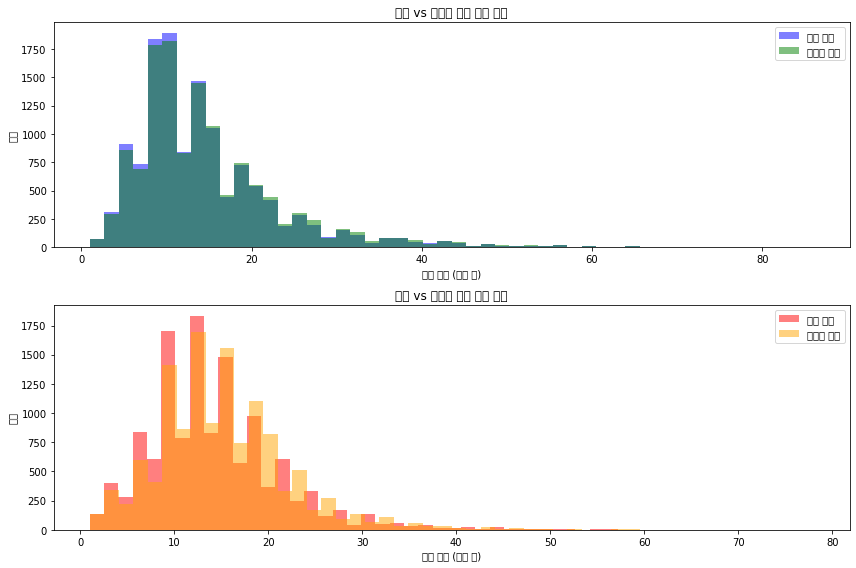


Î¨∏Ï†úÍ∞Ä ÏûàÎäî Ï†ÑÏ≤òÎ¶¨ ÏºÄÏù¥Ïä§:


In [11]:
def evaluate_preprocessing(original_df, processed_df):
    """Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º Í≤ÄÏ¶ù Î∞è ÌèâÍ∞Ä"""
    logger.info("Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º Í≤ÄÏ¶ù Î∞è ÌèâÍ∞Ä Ï§ë...")
    
    evaluation_results = {
        "total_rows": len(processed_df),
        "empty_processed_q": 0,
        "empty_processed_a": 0,
        "short_processed_q": 0,
        "short_processed_a": 0,
        "avg_original_q_length": 0,
        "avg_processed_q_length": 0,
        "avg_original_a_length": 0,
        "avg_processed_a_length": 0,
        "morpheme_tokenization_success": 0
    }
    
    # Í∏∞Î≥∏ ÌÜµÍ≥Ñ
    evaluation_results["avg_original_q_length"] = original_df['Q'].apply(len).mean()
    evaluation_results["avg_original_a_length"] = original_df['A'].apply(len).mean()
    evaluation_results["avg_processed_q_length"] = processed_df['Q_processed'].apply(len).mean()
    evaluation_results["avg_processed_a_length"] = processed_df['A_processed'].apply(len).mean()
    
    # Îπà Í∞í Í≤ÄÏÇ¨
    evaluation_results["empty_processed_q"] = (processed_df['Q_processed'].str.strip() == "").sum()
    evaluation_results["empty_processed_a"] = (processed_df['A_processed'].str.strip() == "").sum()
    
    # ÏßßÏùÄ ÌÖçÏä§Ìä∏ Í≤ÄÏÇ¨ (2Îã®Ïñ¥ ÎØ∏Îßå)
    evaluation_results["short_processed_q"] = (processed_df['Q_processed'].apply(lambda x: len(x.split()) < 2 if isinstance(x, str) else True)).sum()
    evaluation_results["short_processed_a"] = (processed_df['A_processed'].apply(lambda x: len(x.split()) < 2 if isinstance(x, str) else True)).sum()
    
    # ÌòïÌÉúÏÜå Î∂ÑÏÑù ÏÑ±Í≥µÎ•†
    non_empty_morphemes_q = ~(processed_df['Q_morphemes'].isnull() | (processed_df['Q_morphemes'] == ""))
    non_empty_morphemes_a = ~(processed_df['A_morphemes'].isnull() | (processed_df['A_morphemes'] == ""))
    evaluation_results["morpheme_tokenization_success"] = (non_empty_morphemes_q & non_empty_morphemes_a).sum()
    
    # Í≤∞Í≥º Ï∂úÎ†•
    print("\nÏ†ÑÏ≤òÎ¶¨ Í≤∞Í≥º ÌèâÍ∞Ä:")
    print(f"Ï¥ù Îç∞Ïù¥ÌÑ∞ Ïàò: {evaluation_results['total_rows']}")
    print(f"Îπà Ï≤òÎ¶¨ ÏßàÎ¨∏ Ïàò: {evaluation_results['empty_processed_q']} ({evaluation_results['empty_processed_q']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"Îπà Ï≤òÎ¶¨ ÎãµÎ≥Ä Ïàò: {evaluation_results['empty_processed_a']} ({evaluation_results['empty_processed_a']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"ÏßßÏùÄ Ï≤òÎ¶¨ ÏßàÎ¨∏ Ïàò: {evaluation_results['short_processed_q']} ({evaluation_results['short_processed_q']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"ÏßßÏùÄ Ï≤òÎ¶¨ ÎãµÎ≥Ä Ïàò: {evaluation_results['short_processed_a']} ({evaluation_results['short_processed_a']/evaluation_results['total_rows']*100:.2f}%)")
    print(f"ÏõêÎ≥∏ ÏßàÎ¨∏ ÌèâÍ∑† Í∏∏Ïù¥: {evaluation_results['avg_original_q_length']:.2f} Í∏ÄÏûê")
    print(f"Ï≤òÎ¶¨ ÏßàÎ¨∏ ÌèâÍ∑† Í∏∏Ïù¥: {evaluation_results['avg_processed_q_length']:.2f} Í∏ÄÏûê")
    print(f"ÏõêÎ≥∏ ÎãµÎ≥Ä ÌèâÍ∑† Í∏∏Ïù¥: {evaluation_results['avg_original_a_length']:.2f} Í∏ÄÏûê")
    print(f"Ï≤òÎ¶¨ ÎãµÎ≥Ä ÌèâÍ∑† Í∏∏Ïù¥: {evaluation_results['avg_processed_a_length']:.2f} Í∏ÄÏûê")
    print(f"ÌòïÌÉúÏÜå Î∂ÑÏÑù ÏÑ±Í≥µÎ•†: {evaluation_results['morpheme_tokenization_success']/evaluation_results['total_rows']*100:.2f}%")
    
    # ÏõêÎ≥∏Í≥º Ï≤òÎ¶¨Îêú ÌÖçÏä§Ìä∏ ÎπÑÍµê ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12, 8))
    
    # ÏßàÎ¨∏ Í∏∏Ïù¥ ÎπÑÍµê
    plt.subplot(2, 1, 1)
    plt.hist(original_df['Q'].apply(len), bins=50, alpha=0.5, color='blue', label='ÏõêÎ≥∏ ÏßàÎ¨∏')
    plt.hist(processed_df['Q_processed'].apply(len), bins=50, alpha=0.5, color='green', label='Ï≤òÎ¶¨Îêú ÏßàÎ¨∏')
    plt.xlabel('Î¨∏Ïû• Í∏∏Ïù¥ (Í∏ÄÏûê Ïàò)')
    plt.ylabel('ÎπàÎèÑ')
    plt.title('ÏõêÎ≥∏ vs Ï≤òÎ¶¨Îêú ÏßàÎ¨∏ Í∏∏Ïù¥ Î∂ÑÌè¨')
    plt.legend()
    
    # ÎãµÎ≥Ä Í∏∏Ïù¥ ÎπÑÍµê
    plt.subplot(2, 1, 2)
    plt.hist(original_df['A'].apply(len), bins=50, alpha=0.5, color='red', label='ÏõêÎ≥∏ ÎãµÎ≥Ä')
    plt.hist(processed_df['A_processed'].apply(len), bins=50, alpha=0.5, color='orange', label='Ï≤òÎ¶¨Îêú ÎãµÎ≥Ä')
    plt.xlabel('Î¨∏Ïû• Í∏∏Ïù¥ (Í∏ÄÏûê Ïàò)')
    plt.ylabel('ÎπàÎèÑ')
    plt.title('ÏõêÎ≥∏ vs Ï≤òÎ¶¨Îêú ÎãµÎ≥Ä Í∏∏Ïù¥ Î∂ÑÌè¨')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_dir, 'preprocessing_evaluation.png'))
    plt.show()
    
    return evaluation_results

# Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º Î∂ÑÏÑù
evaluation_results = evaluate_preprocessing(combined_df, processed_df)

# Î¨∏Ï†ú ÏºÄÏù¥Ïä§ ÌôïÏù∏
def show_problematic_cases(df, n=10):
    """Î¨∏Ï†úÍ∞Ä ÏûàÎäî Ï†ÑÏ≤òÎ¶¨ ÏºÄÏù¥Ïä§ Î≥¥Ïó¨Ï£ºÍ∏∞"""
    print("\nÎ¨∏Ï†úÍ∞Ä ÏûàÎäî Ï†ÑÏ≤òÎ¶¨ ÏºÄÏù¥Ïä§:")
    
    # Îπà Ï≤òÎ¶¨ Í≤∞Í≥º ÏºÄÏù¥Ïä§
    empty_processed = df[(df['Q_processed'].str.strip() == "") | (df['A_processed'].str.strip() == "")]
    if len(empty_processed) > 0:
        print("\nÎπà Ï≤òÎ¶¨ Í≤∞Í≥º ÏºÄÏù¥Ïä§:")
        for i, row in empty_processed.head(n).iterrows():
            print(f"ÏõêÎ≥∏ Q: {row['Q']}")
            print(f"Ï≤òÎ¶¨ Q: {row['Q_processed']}")
            print(f"ÏõêÎ≥∏ A: {row['A']}")
            print(f"Ï≤òÎ¶¨ A: {row['A_processed']}")
            print("-" * 50)
    
    # Ïã¨ÌïòÍ≤å Î≥ÄÍ≤ΩÎêú ÏºÄÏù¥Ïä§ (Í∏∏Ïù¥Í∞Ä 50% Ïù¥ÏÉÅ Ï§ÑÏñ¥Îì† Í≤ΩÏö∞)
    def length_reduction_ratio(orig, proc):
        if not isinstance(orig, str) or not isinstance(proc, str) or len(orig) == 0:
            return 0
        return (len(orig) - len(proc)) / len(orig)
    
    df['q_reduction'] = df.apply(lambda x: length_reduction_ratio(x['Q'], x['Q_processed']), axis=1)
    df['a_reduction'] = df.apply(lambda x: length_reduction_ratio(x['A'], x['A_processed']), axis=1)
    
    heavily_reduced = df[(df['q_reduction'] > 0.5) | (df['a_reduction'] > 0.5)]
    if len(heavily_reduced) > 0:
        print("\nÏã¨ÌïòÍ≤å Î≥ÄÍ≤ΩÎêú ÏºÄÏù¥Ïä§ (Í∏∏Ïù¥ 50% Ïù¥ÏÉÅ Í∞êÏÜå):")
        for i, row in heavily_reduced.head(n).iterrows():
            print(f"ÏõêÎ≥∏ Q: {row['Q']}")
            print(f"Ï≤òÎ¶¨ Q: {row['Q_processed']} (Í∞êÏÜåÏú®: {row['q_reduction']:.2f})")
            print(f"ÏõêÎ≥∏ A: {row['A']}")
            print(f"Ï≤òÎ¶¨ A: {row['A_processed']} (Í∞êÏÜåÏú®: {row['a_reduction']:.2f})")
            print("-" * 50)

# Î¨∏Ï†ú ÏºÄÏù¥Ïä§ ÌôïÏù∏
show_problematic_cases(processed_df)

### 1-12 ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∞úÏÑ† Î∞è Ï†ÄÏû•

In [12]:
def improve_data_quality(df):
    """Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∞úÏÑ† - Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ"""
    logger.info("Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∞úÏÑ† Ï§ë...")
    
    # Ï≤òÎ¶¨ Ï†Ñ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞
    initial_size = len(df)
    
    # 1. ÏôÑÏ†ÑÌûà Îπà Ï≤òÎ¶¨ Í≤∞Í≥ºÎßå Ï†úÍ±∞ (Îß§Ïö∞ Í¥ÄÎåÄÌïú ÌïÑÌÑ∞ÎßÅ)
    df = df[~((df['Q_processed'].isnull()) | (df['A_processed'].isnull()))]
    
    # 2. Îß§Ïö∞ ÏßßÏùÄ Ï≤òÎ¶¨ Í≤∞Í≥ºÎßå Ï†úÍ±∞ (1Í∏ÄÏûê Ïù¥Ìïò)
    df = df[~((df['Q_processed'].apply(lambda x: len(str(x)) <= 1)) & 
             (df['A_processed'].apply(lambda x: len(str(x)) <= 1)))]
    
    # 3. Ï§ëÎ≥µ Ï†úÍ±∞ (QÏôÄ AÍ∞Ä Î™®Îëê ÎèôÏùºÌïú Í≤ΩÏö∞Îßå)
    df = df.drop_duplicates(subset=['Q_processed', 'A_processed'])
    
    # Ï≤òÎ¶¨ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞
    final_size = len(df)
    
    logger.info(f"Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∞úÏÑ† ÏôÑÎ£å: {initial_size}Í∞ú -> {final_size}Í∞ú ({final_size/initial_size*100:.2f}%)")
    return df

# Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∞úÏÑ†
improved_df = improve_data_quality(processed_df)

# ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÄÏû•
final_output_path = os.path.join(data_dir, 'final_preprocessed_chat_data.csv')
improved_df.to_csv(final_output_path, index=False)
logger.info(f"ÏµúÏ¢Ö Ï†ÑÏ≤òÎ¶¨ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: {final_output_path}")

# ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ
final_stats = {
    "ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞": len(combined_df),
    "Ï≤òÎ¶¨ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞": len(processed_df),
    "ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞": len(improved_df),
    "Îç∞Ïù¥ÌÑ∞ Î≥¥Ï°¥Ïú®": len(improved_df) / len(combined_df) * 100
}

print("\nÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã ÌÜµÍ≥Ñ:")
for key, value in final_stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

# ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå Ï∂úÎ†•
print("\nÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå:")
display_columns = ['Q', 'Q_processed', 'Q_morphemes', 'A', 'A_processed', 'A_morphemes']
print(improved_df[display_columns].head())

2025-04-21 01:55:00,879 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∞úÏÑ† Ï§ë...
2025-04-21 01:55:00,903 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∞úÏÑ† ÏôÑÎ£å: 12770Í∞ú -> 12767Í∞ú (99.98%)
2025-04-21 01:55:00,995 - __main__ - INFO - ÏµúÏ¢Ö Ï†ÑÏ≤òÎ¶¨ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: chatbot_data/final_preprocessed_chat_data.csv



ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã ÌÜµÍ≥Ñ:
ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 12770
Ï≤òÎ¶¨ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 12770
ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: 12767
Îç∞Ïù¥ÌÑ∞ Î≥¥Ï°¥Ïú®: 99.98

ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå:
                 Q      Q_processed             Q_morphemes            A  \
0           12Ïãú Îï°!          12Ïãú Îï° !                12 Ïãú Îï° !   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.   
1      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥           1 ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.   
2     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§     3 Î∞ï 4 Ïùº ÎÜÄ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.   
3  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  3 Î∞ï 4 Ïùº Ï†ïÎèÑ ÎÜÄ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.   
4          PPL Ïã¨ÌïòÎÑ§          PPL Ïã¨ÌïòÎÑ§                PPL Ïã¨Ìïò ÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.   

    A_processed     A_morphemes  
0   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî .   ÌïòÎ£® Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .  
1    Ïú

### 1-13 Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Î∞è ÌîÑÎ°úÏ†ùÌä∏ Ï†ïÎ≥¥ Ï†ÄÏû•

In [13]:
def save_project_metadata():
    """ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû•"""
    logger.info("ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû• Ï§ë...")
    
    # ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞
    metadata = {
        "project_name": "ÌïúÍµ≠Ïñ¥ Ï±óÎ¥á Í∞úÎ∞ú",
        "step": "Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ï†ÑÏ≤òÎ¶¨",
        "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "data_stats": {
            "original_data_size": len(combined_df),
            "processed_data_size": len(processed_df),
            "final_data_size": len(improved_df),
            "data_preservation_rate": len(improved_df) / len(combined_df) * 100
        },
        "preprocessing_pipeline": {
            "tools": {
                "morpheme_analyzer": str(preprocessor.morpheme_analyzer.__class__.__name__),
                "use_soynlp": preprocessor.use_soynlp
            },
            "stopwords_count": len(preprocessor.stopwords),
            "slang_dict_count": len(preprocessor.slang_dict)
        },
        "embedding_models": {
            "word2vec": embedding_manager.word2vec_model is not None,
            "fasttext": embedding_manager.fasttext_model is not None,
            "bert": bert_embedding.is_model_loaded()
        },
        "dialogue_context": {
            "conversations_count": len(dialogue_manager.conversation_flows),
            "max_context_length": dialogue_manager.max_context_length
        },
        "file_paths": {
            "combined_data": os.path.join(data_dir, 'combined_chat_data.csv'),
            "processed_data": os.path.join(data_dir, 'processed_chat_data.csv'),
            "final_data": os.path.join(data_dir, 'final_preprocessed_chat_data.csv'),
            "word2vec_model": os.path.join(data_dir, 'word2vec_model.bin'),
            "fasttext_model": os.path.join(data_dir, 'fasttext_model.bin'),
            "structured_dialogue": os.path.join(data_dir, 'structured_dialogue_data.json'),
            "context_qa_pairs": os.path.join(data_dir, 'context_qa_pairs.json')
        }
    }
    
    # Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
    metadata_path = os.path.join(data_dir, 'project_metadata.json')
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, ensure_ascii=False, indent=2)
    
    logger.info(f"ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: {metadata_path}")
    return metadata

# ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
metadata = save_project_metadata()

print("\nÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞:")
for key, value in metadata.items():
    if key != "file_paths":  # ÌååÏùº Í≤ΩÎ°úÎäî ÎÑàÎ¨¥ Í∏∏Ïñ¥ÏÑú Ï†úÏô∏
        print(f"{key}: {value}")

2025-04-21 01:55:01,014 - __main__ - INFO - ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû• Ï§ë...
2025-04-21 01:55:01,015 - __main__ - INFO - ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: chatbot_data/project_metadata.json



ÌîÑÎ°úÏ†ùÌä∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞:
project_name: ÌïúÍµ≠Ïñ¥ Ï±óÎ¥á Í∞úÎ∞ú
step: Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ï†ÑÏ≤òÎ¶¨
created_at: 2025-04-21 01:55:01
data_stats: {'original_data_size': 12770, 'processed_data_size': 12770, 'final_data_size': 12767, 'data_preservation_rate': 99.97650743931088}
preprocessing_pipeline: {'tools': {'morpheme_analyzer': 'Mecab', 'use_soynlp': True}, 'stopwords_count': 17, 'slang_dict_count': 30}
embedding_models: {'word2vec': True, 'fasttext': True, 'bert': True}
dialogue_context: {'conversations_count': 200, 'max_context_length': 3}


## Step 2. Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Î∞è ÌÜ†ÌÅ∞Ìôî Í∞úÏÑ†

- data Ï¶ùÍ∞ï: Ï£ºÏ†ú, Í∞êÏ†ï, ÎèôÏùòÏñ¥, Î∞±Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò, Î¨∏Ïû• Ìå®ÌÑ¥ etc. Ï†ÅÏö©ÌïòÏó¨ dataset 2Î∞∞ Í∞ÄÍπåÏù¥ ÌôïÏû•
- ÌïúÍµ≠Ïñ¥ ÌòïÌÉúÏÜå Í∏∞Î∞òÏùò ÏÑúÎ∏åÏõåÎìú ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎ•º Íµ¨Ï∂ï (ÏûêÏó∞Ïä§Îü¨Ïö¥ Î¨∏Ïû• Î∂ÑÌï¥ÏôÄ Ïû¨Íµ¨ÏÑ±Ïù¥ Í∞ÄÎä•ÌïòÎèÑÎ°ù)
- Í≤∞Í≥º: Ï¶ùÍ∞ï dataÏôÄ ÌÜ†ÌÅ∞Ìôî data Î™®Îëê ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÏÉùÏÑ±&Ï†ÄÏû•

### 2-1 ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ Î∞è ÌôòÍ≤Ω ÏÑ§Ï†ï

In [14]:
# Ï∂îÍ∞ÄÎ°ú ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.util import ngrams
import seaborn as sns
import itertools
import math

# Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï 
data_dir = "chatbot_data"
os.makedirs(data_dir, exist_ok=True)

# ÎûúÎç§ ÏãúÎìú ÏÑ§Ï†ï 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# NLTK Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú (ÏÉàÎ°ú ÌïÑÏöîÌïú Î∂ÄÎ∂Ñ)
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    logger.warning("NLTK Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú Ïã§Ìå®. Ïù¥ÎØ∏ ÏÑ§ÏπòÎêòÏñ¥ ÏûàÍ±∞ÎÇò ÎÑ§Ìä∏ÏõåÌÅ¨ Î¨∏Ï†úÏùº Ïàò ÏûàÏäµÎãàÎã§.")


### 2-2 Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨ Í≤∞Í≥º ÌôïÏù∏

In [15]:
def load_processed_data():
    """Step1ÏóêÏÑú Ï†ÑÏ≤òÎ¶¨Ìïú Îç∞Ïù¥ÌÑ∞ Î°úÎìú"""
    logger.info("Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...")
    
    # ÏµúÏ¢Ö Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    processed_data_path = os.path.join(data_dir, 'final_preprocessed_chat_data.csv')
    
    if os.path.exists(processed_data_path):
        df = pd.read_csv(processed_data_path)
        logger.info(f"Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {len(df)}Í∞ú")
        return df
    else:
        # Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÎäî Í≤ΩÏö∞ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        logger.warning("Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞Î•º Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌï©ÎãàÎã§.")
        combined_data_path = os.path.join(data_dir, 'combined_chat_data.csv')
        
        if os.path.exists(combined_data_path):
            df = pd.read_csv(combined_data_path)
            logger.info(f"ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {len(df)}Í∞ú")
            return df
        else:
            logger.error("Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")
            return None

# Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú
processed_df = load_processed_data()

if processed_df is not None:
    print("Îç∞Ïù¥ÌÑ∞ÏÖã ÎØ∏Î¶¨Î≥¥Í∏∞:")
    print(processed_df.head())
    
    # Îç∞Ïù¥ÌÑ∞ ÌÜµÍ≥Ñ Ï∂úÎ†•
    print(f"\nÎç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞: {len(processed_df)}")
    
    # Ïª¨Îüº ÌôïÏù∏
    print(f"Îç∞Ïù¥ÌÑ∞ÏÖã Ïª¨Îüº: {processed_df.columns.tolist()}")
    
    # ÏßàÎ¨∏/ÎãµÎ≥Ä Í∏∏Ïù¥ Î∂ÑÌè¨
    q_lengths = processed_df['Q_processed'].apply(lambda x: len(str(x).split()))
    a_lengths = processed_df['A_processed'].apply(lambda x: len(str(x).split()))
    
    print(f"ÏßàÎ¨∏ ÌèâÍ∑† Îã®Ïñ¥ Ïàò: {q_lengths.mean():.2f}")
    print(f"ÏßàÎ¨∏ ÏµúÎåÄ Îã®Ïñ¥ Ïàò: {q_lengths.max()}")
    print(f"ÎãµÎ≥Ä ÌèâÍ∑† Îã®Ïñ¥ Ïàò: {a_lengths.mean():.2f}")
    print(f"ÎãµÎ≥Ä ÏµúÎåÄ Îã®Ïñ¥ Ïàò: {a_lengths.max()}")
    
    # ÌòïÌÉúÏÜå Î∂ÑÏÑù Í≤∞Í≥º ÌôïÏù∏
    print("\nÌòïÌÉúÏÜå Î∂ÑÏÑù Í≤∞Í≥º ÏÉòÌîå:")
    for i in range(min(5, len(processed_df))):
        print(f"ÏõêÎ¨∏ Q: {processed_df.iloc[i]['Q']}")
        print(f"ÌòïÌÉúÏÜå Q: {processed_df.iloc[i]['Q_morphemes']}")
        print(f"ÏõêÎ¨∏ A: {processed_df.iloc[i]['A']}")
        print(f"ÌòïÌÉúÏÜå A: {processed_df.iloc[i]['A_morphemes']}")
        print("-" * 50)
    
    # Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    questions = processed_df['Q_processed'].tolist()
    answers = processed_df['A_processed'].tolist()
    questions_morpheme = processed_df['Q_morphemes'].tolist()
    answers_morpheme = processed_df['A_morphemes'].tolist()
    
    logger.info(f"ÏßàÎ¨∏-ÎãµÎ≥Ä Ïåç {len(questions)}Í∞ú Ï∂îÏ∂ú ÏôÑÎ£å")
else:
    logger.error("Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïã§Ìå®. ÌîÑÎ°úÍ∑∏Îû®ÏùÑ Ï¢ÖÎ£åÌï©ÎãàÎã§.")
    exit(1)

2025-04-21 02:09:46,267 - __main__ - INFO - Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ï§ë...
2025-04-21 02:09:46,356 - __main__ - INFO - Ï†ÑÏ≤òÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: 12767Í∞ú
2025-04-21 02:09:46,388 - __main__ - INFO - ÏßàÎ¨∏-ÎãµÎ≥Ä Ïåç 12767Í∞ú Ï∂îÏ∂ú ÏôÑÎ£å


Îç∞Ïù¥ÌÑ∞ÏÖã ÎØ∏Î¶¨Î≥¥Í∏∞:
                 Q            A  source      Q_processed   A_processed  \
0           12Ïãú Îï°!   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.  songys          12Ïãú Îï° !   ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî .   
1      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.  songys      1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥    ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§ .   
2     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.  songys     3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† .   
3  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.  songys  3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§  Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£† .   
4          PPL Ïã¨ÌïòÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.  songys          PPL Ïã¨ÌïòÎÑ§   ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£† .   

              Q_morphemes     A_morphemes  q_reduction  a_reduction  
0                12 Ïãú Îï° !   ÌïòÎ£® Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .    -0.166667    -0.100000  
1           1 ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥     ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .     0.000000    -0.111

### 2-3 ÌÖçÏä§Ìä∏ Î∂ÑÏÑù Î∞è Î∂ÑÎ•ò Í∏∞Îä• Íµ¨ÌòÑ

In [16]:
class TextAnalyzer:
    """ÌÖçÏä§Ìä∏ Î∂ÑÏÑù Î∞è Î∂ÑÎ•ò ÌÅ¥ÎûòÏä§"""
    
    def __init__(self):
        # Ï£ºÏ†úÎ≥Ñ ÌÇ§ÏõåÎìú Ï†ïÏùò
        self.topic_keywords = {
            'ÌïôÏóÖ': ['ÏãúÌóò', 'Í≥µÎ∂Ä', 'ÌïôÍµê', 'ÏàôÏ†ú', 'ÏÑ±Ï†Å', 'ÍµêÏàò', 'ÌïôÏÉù', 'Í∞ïÏùò', 'ÏàòÏóÖ', 'Í≥ºÏ†ú', 'ÎÖºÎ¨∏', 'Î∞úÌëú', 'Ïó∞Íµ¨', 'Ï†ÑÍ≥µ', 'ÌïôÏ†ê'],
            'Í±¥Í∞ï': ['ÏïÑÌîÑÎã§', 'Î≥ëÏõê', 'Ïö¥Îèô', 'Îã§Ïù¥Ïñ¥Ìä∏', 'ÌîºÍ≥§', 'Í±¥Í∞ï', 'ÏïΩ', 'ÏπòÎ£å', 'Ï¶ùÏÉÅ', 'ÌÜµÏ¶ù', 'ÎëêÌÜµ', 'Í∞êÍ∏∞', 'ÏßàÎ≥ë', 'ÏòÅÏñë', 'ÏàòÎ©¥'],
            'Ïó∞Ïï†': ['Ï¢ãÏïÑÌï¥', 'ÏÇ¨Îûë', 'Í≥†Î∞±', 'Ïç∏', 'Ïù¥Î≥Ñ', 'ÎÇ®ÏûêÏπúÍµ¨', 'Ïó¨ÏûêÏπúÍµ¨', 'Ïó∞Ïù∏', 'Îç∞Ïù¥Ìä∏', 'Í≤∞Ìòº', 'ÏßùÏÇ¨Îûë', 'Ïù¥Ìòº', 'ÏÜåÍ∞úÌåÖ', 'Ïç∏', 'Í≥†Î∞±'],
            'ÏùºÏÉÅ': ['Î∞•', 'ÎÇ†Ïî®', 'ÏáºÌïë', 'ÏòÅÌôî', 'Ïó¨Ìñâ', 'Ï∑®ÎØ∏', 'Ìú¥Ïãù', 'Ï£ºÎßê', 'ÏöîÎ¶¨', 'ÏùåÏãù', 'Ïπ¥Ìéò', 'Ïßë', 'ÏπúÍµ¨', 'Í∞ÄÏ°±', 'ÏÉùÏùº'],
            'Í∞êÏ†ï': ['Í∏∞ÏÅòÎã§', 'Ïä¨ÌîÑÎã§', 'ÌôîÎÇòÎã§', 'Î∂àÏïà', 'Í±±Ï†ï', 'Ïö∞Ïö∏', 'ÌñâÎ≥µ', 'Ïä§Ìä∏Î†àÏä§', 'Î∂ÑÎÖ∏', 'Í∏∞ÏÅ®', 'Ïä¨Ìîî', 'ÌõÑÌöå', 'Î∂àÎßå', 'ÎßåÏ°±', 'Ïã§Îßù'],
            'ÏßÅÏû•': ['ÌöåÏÇ¨', 'ÏóÖÎ¨¥', 'ÏÉÅÏÇ¨', 'ÎèôÎ£å', 'Ìá¥Í∑º', 'Ï∂úÍ∑º', 'ÌîÑÎ°úÏ†ùÌä∏', 'Ïù¥ÏßÅ', 'Ïó∞Î¥â', 'ÏäπÏßÑ', 'Ìá¥ÏÇ¨', 'Ï∑®ÏóÖ', 'Î©¥Ï†ë', 'Í≤ΩÎ†•', 'ÏßÅÎ¨¥'],
            'Ï∑®ÎØ∏': ['Í≤åÏûÑ', 'ÎèÖÏÑú', 'ÏùåÏïÖ', 'ÏòÅÌôî', 'ÎìúÎùºÎßà', 'Í≥µÏó∞', 'Ï†ÑÏãú', 'Ïó¨Ìñâ', 'ÏöîÎ¶¨', 'Ïä§Ìè¨Ï∏†', 'ÏÇ¨ÏßÑ', 'Í∑∏Î¶º', 'Ï∂§', 'ÎÖ∏Îûò', 'ÏïÖÍ∏∞'],
            'ÏÇ¨Ìöå': ['Îâ¥Ïä§', 'Ï†ïÏπò', 'Í≤ΩÏ†ú', 'ÏÇ¨Ìöå', 'Î¨∏Ìôî', 'ÌôòÍ≤Ω', 'Í∏∞Ïà†', 'Í≥ºÌïô', 'Î≤ïÎ•†', 'ÍµêÏú°', 'Î≥µÏßÄ', 'Ïù∏Í∂å', 'Íµ≠Ï†ú', 'Ïó≠ÏÇ¨', 'Ï¢ÖÍµê']
        }
        
        # Í∞êÏ†ï ÌÇ§ÏõåÎìú Ï†ïÏùò
        self.emotion_keywords = {
            'Í∏∞ÏÅ®': ['Ï¢ãÏïÑ', 'ÌñâÎ≥µ', 'Ïã†ÎÇò', 'Ï¶êÍ±∞Ïõå', 'Í∏∞Îªê', 'ÏõÉ', 'Ïã†ÎÇ®', 'Ï¢ãÏïò', 'Ïû¨Î∞å', 'ÏÑ§Î†à', 'ÎßåÏ°±', 'Í∞êÏÇ¨', 'Ìù•Î∂Ñ', 'Í∏∞ÏÅò', 'Ï¶êÍ±∞ÏõÄ'],
            'Ïä¨Ìîî': ['Ïä¨Ìçº', 'Ïö∞Ïö∏', 'ÌûòÎì§Ïñ¥', 'ÏïÑÌåå', 'ÎààÎ¨º', 'Ïö∏', 'ÏÑúÎüΩ', 'Í∑∏Î¶¨ÏõÄ', 'Ïô∏Î°úÏõÄ', 'Ïì∏Ïì∏', 'Í≥µÌóà', 'ÏÉÅÏã§', 'ÏïÑÏâ¨ÏõÄ', 'Ïã§Îßù', 'ÌóàÎ¨¥'],
            'Î∂ÑÎÖ∏': ['ÌôîÎÇò', 'ÏßúÏ¶ù', 'Ïó¥Î∞õÏïÑ', 'ÎØ∏Ï≥ê', 'ÏßúÏ¶ùÎÇò', 'ÌôîÍ∞Ä', 'Î∂ÑÎÖ∏', 'ÏñµÏö∏', 'ÎãµÎãµ', 'Î∂àÎßå', 'Í≤©Î∂Ñ', 'Ï¶ùÏò§', 'ÌòêÏò§', 'Î∂àÏæå', 'Í≤©ÎÖ∏'],
            'Î∂àÏïà': ['Í±±Ï†ï', 'Î∂àÏïà', 'Í∏¥Ïû•', 'ÎëêÎ†§Ïõå', 'Î¨¥ÏÑúÏõå', 'Í≤ÅÎÇò', 'Ï°∞ÎßàÏ°∞Îßà', 'Îñ®Î†§', 'Ï¥àÏ°∞', 'Ïä§Ìä∏Î†àÏä§', 'Í≥µÌè¨', 'ÎãπÌô©', 'ÎÜÄÎûå', 'Ï∂©Í≤©', 'ÌòºÎûÄ'],
            'Ï§ëÎ¶Ω': ['Í∑∏ÎÉ•', 'Î≥¥ÌÜµ', 'ÌèâÎ≤î', 'ÏùºÏÉÅ', 'ÌäπÎ≥ÑÌïòÏßÄÏïäÏïÑ', 'Í¥úÏ∞Æ', 'Í∑∏Ï†Ä', 'Î≥ÑÍ±∞', 'Î¨¥ÎÇú', 'Ï†ÅÎãπ', 'Î≥¥ÌÜµ', 'ÌèâÏù¥', 'Ï§ëÍ∞Ñ', 'Î≥¥Ìé∏Ï†Å', 'ÏùºÎ∞òÏ†Å']
        }
        
        # Î¨∏Ïû• Ïú†Ìòï Ìå®ÌÑ¥ Ï†ïÏùò
        self.sentence_patterns = {
            'ÏßàÎ¨∏': [r'\?', r'Íπå\?', r'Îãà\?', r'ÏÑ∏Ïöî\?', r'Ïñ¥Îñª', r'Ïñ∏Ï†ú', r'ÎàÑÍµ¨', r'Î¨¥Ïóá', r'Ïôú', r'Ïñ¥Îîî', r'Î™á', r'ÏñºÎßà'],
            'Î™ÖÎ†π': [r'Ìï¥Ï£ºÏÑ∏Ïöî', r'ÌïòÏÑ∏Ïöî', r'Ìï¥Î¥ê', r'Ìï¥Îùº', r'Ìï¥Ï§ò', r'Ìï¥Î¥êÏöî', r'ÌïòÏßÄÎßà', r'ÌïòÏßÄÎßàÏÑ∏Ïöî', r'Ìï¥ÏïºÌï¥'],
            'Í∞êÌÉÑ': [r'\!', r'ÏôÄ\!', r'Ïö∞ÏôÄ', r'ÎåÄÎ∞ï', r'Ïã†Í∏∞', r'Î©ãÏßÄ', r'ÎÜÄÎùº', r'Í∞êÎèô', r'ÏµúÍ≥†'],
            'ÏÑúÏà†': [r'Ïù¥Îã§', r'ÏûÖÎãàÎã§', r'ÏòàÏöî', r'Ïù¥ÏóêÏöî', r'Ïù¥Ïïº', r'Ïù¥ÎÑ§', r'Ïù¥ÎÑ§Ïöî', r'Íµ∞Ïöî', r'Íµ¨ÎÇò']
        }
        
        # TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî
        self.tfidf_vectorizer = None
        
        logger.info("ÌÖçÏä§Ìä∏ Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    
    def classify_topic(self, text):
        """Ï£ºÏ†ú Î∂ÑÎ•ò Ìï®Ïàò"""
        if not text or not isinstance(text, str):
            return 'ÏùºÎ∞ò'
        
        # Ï£ºÏ†ú Ï†êÏàò Í≥ÑÏÇ∞
        topic_scores = {}
        for topic, keywords in self.topic_keywords.items():
            # ÌÇ§ÏõåÎìú Îß§Ïπ≠ Ï†êÏàò
            keyword_score = sum(1 for keyword in keywords if keyword in text)
            
            # Îã®Ïñ¥ Ïú†ÏÇ¨ÎèÑ Ï†êÏàò (Îã®Ïñ¥ Ìè¨Ìï® Ïó¨Î∂Ä)
            word_score = sum(1 for word in text.split() for keyword in keywords 
                            if keyword in word or word in keyword)
            
            # ÏµúÏ¢Ö Ï†êÏàò Í≥ÑÏÇ∞ (ÌÇ§ÏõåÎìú Îß§Ïπ≠Ïóê Îçî ÎÜíÏùÄ Í∞ÄÏ§ëÏπò)
            topic_scores[topic] = keyword_score * 2 + word_score
        
        # Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÏùò Ï£ºÏ†ú Î∞òÌôò
        max_score = max(topic_scores.values()) if topic_scores else 0
        
        # Ï†êÏàòÍ∞Ä 0Ïù¥Í±∞ÎÇò Îß§Ïö∞ ÎÇÆÏúºÎ©¥ 'ÏùºÎ∞ò' Î∞òÌôò
        if max_score <= 1:
            return 'ÏùºÎ∞ò'
        
        # Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÏùò Ï£ºÏ†ú Î∞òÌôò
        return max(topic_scores.items(), key=lambda x: x[1])[0]
    
    def analyze_emotion(self, text):
        """Í∞êÏ†ï Î∂ÑÏÑù Ìï®Ïàò"""
        if not text or not isinstance(text, str):
            return 'Ï§ëÎ¶Ω'
        
        # Í∞êÏ†ï Ï†êÏàò Í≥ÑÏÇ∞
        emotion_scores = {}
        for emotion, keywords in self.emotion_keywords.items():
            # ÌÇ§ÏõåÎìú Îß§Ïπ≠ Ï†êÏàò
            keyword_score = sum(1 for keyword in keywords if keyword in text)
            
            # Îã®Ïñ¥ Ïú†ÏÇ¨ÎèÑ Ï†êÏàò
            word_score = sum(1 for word in text.split() for keyword in keywords 
                            if keyword in word or word in keyword)
            
            # ÏµúÏ¢Ö Ï†êÏàò Í≥ÑÏÇ∞
            emotion_scores[emotion] = keyword_score * 2 + word_score
        
        # Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÏùò Í∞êÏ†ï Î∞òÌôò
        max_score = max(emotion_scores.values()) if emotion_scores else 0
        
        # Ï†êÏàòÍ∞Ä 0Ïù¥Í±∞ÎÇò Îß§Ïö∞ ÎÇÆÏúºÎ©¥ 'Ï§ëÎ¶Ω' Î∞òÌôò
        if max_score <= 1:
            return 'Ï§ëÎ¶Ω'
        
        # Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÏùò Í∞êÏ†ï Î∞òÌôò
        return max(emotion_scores.items(), key=lambda x: x[1])[0]
    
    def classify_sentence_type(self, text):
        """Î¨∏Ïû• Ïú†Ìòï Î∂ÑÎ•ò Ìï®Ïàò"""
        if not text or not isinstance(text, str):
            return 'ÏÑúÏà†'
        
        # Î¨∏Ïû• Ïú†Ìòï Ï†êÏàò Í≥ÑÏÇ∞
        type_scores = {}
        for sent_type, patterns in self.sentence_patterns.items():
            # Ìå®ÌÑ¥ Îß§Ïπ≠ Ï†êÏàò
            score = sum(1 for pattern in patterns if re.search(pattern, text))
            type_scores[sent_type] = score
        
        # Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÏùò Î¨∏Ïû• Ïú†Ìòï Î∞òÌôò
        max_score = max(type_scores.values()) if type_scores else 0
        
        # Ï†êÏàòÍ∞Ä 0Ïù¥Î©¥ 'ÏÑúÏà†' Î∞òÌôò
        if max_score == 0:
            return 'ÏÑúÏà†'
        
        # Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÏùò Î¨∏Ïû• Ïú†Ìòï Î∞òÌôò
        return max(type_scores.items(), key=lambda x: x[1])[0]
    
    def fit_tfidf_vectorizer(self, texts):
        """TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÌïôÏäµ"""
        if not texts:
            logger.warning("TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÌïôÏäµÏùÑ ÏúÑÌïú ÌÖçÏä§Ìä∏Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return
        
        logger.info("TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÌïôÏäµ Ï§ë...")
        self.tfidf_vectorizer = TfidfVectorizer(
            min_df=2,
            max_df=0.9,
            max_features=10000,
            ngram_range=(1, 2),
            sublinear_tf=True
        )
        self.tfidf_vectorizer.fit(texts)
        logger.info(f"TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÌïôÏäµ ÏôÑÎ£å (ÌäπÏÑ± Ïàò: {len(self.tfidf_vectorizer.get_feature_names_out())})")
    
    def get_text_similarity(self, text1, text2):
        """Îëê ÌÖçÏä§Ìä∏ Í∞ÑÏùò Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞"""
        if not self.tfidf_vectorizer:
            logger.warning("TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†ÄÍ∞Ä ÌïôÏäµÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
            return 0.0
        
        if not text1 or not text2 or not isinstance(text1, str) or not isinstance(text2, str):
            return 0.0
        
        # TF-IDF Î≤°ÌÑ∞ Î≥ÄÌôò
        try:
            tfidf_matrix = self.tfidf_vectorizer.transform([text1, text2])
            # ÏΩîÏÇ¨Ïù∏ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            return similarity
        except Exception as e:
            logger.error(f"Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ Ï§ë Ïò§Î•ò: {e}")
            return 0.0
    
    def analyze_text(self, text):
        """ÌÖçÏä§Ìä∏ Ï¢ÖÌï© Î∂ÑÏÑù"""
        if not text or not isinstance(text, str):
            return {
                'topic': 'ÏùºÎ∞ò',
                'emotion': 'Ï§ëÎ¶Ω',
                'sentence_type': 'ÏÑúÏà†',
                'word_count': 0,
                'char_count': 0
            }
        
        # Îã®Ïñ¥ Ïàò Î∞è Î¨∏Ïûê Ïàò Í≥ÑÏÇ∞
        word_count = len(text.split())
        char_count = len(text)
        
        # Ï¢ÖÌï© Î∂ÑÏÑù Í≤∞Í≥º Î∞òÌôò
        return {
            'topic': self.classify_topic(text),
            'emotion': self.analyze_emotion(text),
            'sentence_type': self.classify_sentence_type(text),
            'word_count': word_count,
            'char_count': char_count
        }

# ÌÖçÏä§Ìä∏ Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî
text_analyzer = TextAnalyzer()

# TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÌïôÏäµ
text_analyzer.fit_tfidf_vectorizer(questions + answers)

# ÌÖçÏä§Ìä∏ Î∂ÑÏÑù ÌÖåÏä§Ìä∏
print("\nÌÖçÏä§Ìä∏ Î∂ÑÏÑù ÌÖåÏä§Ìä∏:")
test_texts = [
    "Ïò§Îäò ÏãúÌóòÏùÑ ÎßùÏ≥êÏÑú ÎÑàÎ¨¥ Ïä¨ÌçºÏöî. Ïñ¥ÎñªÍ≤å Ìï¥Ïïº Ìï†ÍπåÏöî?",
    "ÎÇ®ÏûêÏπúÍµ¨Í∞Ä ÏÉùÏùº ÏÑ†Î¨ºÎ°ú Î≠ò Ï£ºÎ©¥ Ï¢ãÏùÑÍπåÏöî?",
    "ÏöîÏ¶ò ÎÇ†Ïî®Í∞Ä ÎÑàÎ¨¥ Ï¢ãÏïÑÏÑú Í∏∞Î∂ÑÏù¥ Ï¢ãÏïÑÏöî!",
    "ÌöåÏÇ¨ÏóêÏÑú ÏÉÅÏÇ¨Í∞Ä ÏûêÍæ∏ Í¥¥Î°≠ÌòÄÏÑú Ïä§Ìä∏Î†àÏä§ Î∞õÏïÑÏöî.",
    "Ïò§Îäò Ï†ÄÎÖÅ Î≠ê Î®πÏùÑÍπåÏöî?"
]

for text in test_texts:
    analysis = text_analyzer.analyze_text(text)
    print(f"ÌÖçÏä§Ìä∏: {text}")
    print(f"Ï£ºÏ†ú: {analysis['topic']}")
    print(f"Í∞êÏ†ï: {analysis['emotion']}")
    print(f"Î¨∏Ïû• Ïú†Ìòï: {analysis['sentence_type']}")
    print(f"Îã®Ïñ¥ Ïàò: {analysis['word_count']}")
    print("-" * 50)

2025-04-21 02:09:53,025 - __main__ - INFO - ÌÖçÏä§Ìä∏ Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
2025-04-21 02:09:53,027 - __main__ - INFO - TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÌïôÏäµ Ï§ë...
2025-04-21 02:09:53,470 - __main__ - INFO - TF-IDF Î≤°ÌÑ∞ÎùºÏù¥Ï†Ä ÌïôÏäµ ÏôÑÎ£å (ÌäπÏÑ± Ïàò: 10000)



ÌÖçÏä§Ìä∏ Î∂ÑÏÑù ÌÖåÏä§Ìä∏:
ÌÖçÏä§Ìä∏: Ïò§Îäò ÏãúÌóòÏùÑ ÎßùÏ≥êÏÑú ÎÑàÎ¨¥ Ïä¨ÌçºÏöî. Ïñ¥ÎñªÍ≤å Ìï¥Ïïº Ìï†ÍπåÏöî?
Ï£ºÏ†ú: ÌïôÏóÖ
Í∞êÏ†ï: Ïä¨Ìîî
Î¨∏Ïû• Ïú†Ìòï: ÏßàÎ¨∏
Îã®Ïñ¥ Ïàò: 8
--------------------------------------------------
ÌÖçÏä§Ìä∏: ÎÇ®ÏûêÏπúÍµ¨Í∞Ä ÏÉùÏùº ÏÑ†Î¨ºÎ°ú Î≠ò Ï£ºÎ©¥ Ï¢ãÏùÑÍπåÏöî?
Ï£ºÏ†ú: ÏùºÏÉÅ
Í∞êÏ†ï: Ï§ëÎ¶Ω
Î¨∏Ïû• Ïú†Ìòï: ÏßàÎ¨∏
Îã®Ïñ¥ Ïàò: 6
--------------------------------------------------
ÌÖçÏä§Ìä∏: ÏöîÏ¶ò ÎÇ†Ïî®Í∞Ä ÎÑàÎ¨¥ Ï¢ãÏïÑÏÑú Í∏∞Î∂ÑÏù¥ Ï¢ãÏïÑÏöî!
Ï£ºÏ†ú: ÏùºÏÉÅ
Í∞êÏ†ï: Í∏∞ÏÅ®
Î¨∏Ïû• Ïú†Ìòï: Í∞êÌÉÑ
Îã®Ïñ¥ Ïàò: 6
--------------------------------------------------
ÌÖçÏä§Ìä∏: ÌöåÏÇ¨ÏóêÏÑú ÏÉÅÏÇ¨Í∞Ä ÏûêÍæ∏ Í¥¥Î°≠ÌòÄÏÑú Ïä§Ìä∏Î†àÏä§ Î∞õÏïÑÏöî.
Ï£ºÏ†ú: ÏßÅÏû•
Í∞êÏ†ï: Î∂àÏïà
Î¨∏Ïû• Ïú†Ìòï: ÏÑúÏà†
Îã®Ïñ¥ Ïàò: 6
--------------------------------------------------
ÌÖçÏä§Ìä∏: Ïò§Îäò Ï†ÄÎÖÅ Î≠ê Î®πÏùÑÍπåÏöî?
Ï£ºÏ†ú: ÏùºÎ∞ò
Í∞êÏ†ï: Ï§ëÎ¶Ω
Î¨∏Ïû• Ïú†Ìòï: ÏßàÎ¨∏
Îã®Ïñ¥ Ïàò: 4
--------------------------------------------------


### 2-4 Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÌÅ¥ÎûòÏä§ Íµ¨ÌòÑ

In [17]:
class DataAugmenter:
    """ÌïúÍµ≠Ïñ¥ Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÌÅ¥ÎûòÏä§"""
    
    def __init__(self, text_analyzer=None):
        self.text_analyzer = text_analyzer
        
        # ÌïúÍµ≠Ïñ¥ Ï°∞ÏÇ¨/Ïñ¥ÎØ∏ Î≥ÄÌòï ÏÇ¨Ï†Ñ
        self.korean_particles = {
            'ÏùÄ': 'Îäî', 'Îäî': 'ÏùÄ', 
            'Ïù¥': 'Í∞Ä', 'Í∞Ä': 'Ïù¥',
            'ÏùÑ': 'Î•º', 'Î•º': 'ÏùÑ',
            'Í≥º': 'ÏôÄ', 'ÏôÄ': 'Í≥º'
        }
        
        # ÌïúÍµ≠Ïñ¥ ÎèôÏùòÏñ¥ ÏÇ¨Ï†Ñ
        self.synonyms = {
            # Í∞êÏ†ï ÌëúÌòÑ
            'Ï¢ãÏïÑ': ['ÎßàÏùåÏóê Îì§Ïñ¥', 'Í¥úÏ∞ÆÏïÑ', 'ÌõåÎ•≠Ìï¥', 'ÎßòÏóê Îì§Ïñ¥'],
            'Ïã´Ïñ¥': ['ÎßàÏùåÏóê Ïïà Îì§Ïñ¥', 'Î≥ÑÎ°úÏïº', 'Ïïà Ï¢ãÏïÑ', 'ÎßòÏóê Ïïà Îì§Ïñ¥'],
            'ÌñâÎ≥µ': ['Í∏∞ÏÅ®', 'Ï¶êÍ±∞ÏõÄ', 'Ï¢ãÏùÄ Í∏∞Î∂Ñ', 'ÎßåÏ°±'],
            'Ïä¨Ìîî': ['Ïö∞Ïö∏Ìï®', 'ÏÑúÎü¨ÏõÄ', 'ÎßàÏùå ÏïÑÌîî', 'Ïì∏Ïì∏Ìï®'],
            'ÌôîÎÇò': ['ÏßúÏ¶ùÎÇò', 'Ïó¥Î∞õÏïÑ', 'Î∂ÑÎÖ∏', 'Î∂àÏæå'],
            'Í±±Ï†ï': ['Î∂àÏïà', 'ÏóºÎ†§', 'Í∑ºÏã¨', 'Í≥†ÎØº'],
            'ÏÇ¨Îûë': ['Ï¢ãÏïÑÌï®', 'Ïï†Ï†ï', 'ÎßàÏùå', 'Ìò∏Í∞ê'],
            'ÎØ∏Ïõå': ['Ïã´Ïñ¥Ìï®', 'Ï¶ùÏò§', 'Î∞òÍ∞ê', 'ÌòêÏò§'],
            
            # ÏùºÏÉÅ ÌëúÌòÑ
            'Î®πÎã§': ['ÏãùÏÇ¨ÌïòÎã§', 'ÏÑ≠Ï∑®ÌïòÎã§', 'ÎßõÎ≥¥Îã§', 'ÎìúÏãúÎã§'],
            'ÏûêÎã§': ['ÏàòÎ©¥ÌïòÎã§', 'ÎàïÎã§', 'Ïâ¨Îã§', 'Ï∑®Ïπ®ÌïòÎã§'],
            'ÎßêÌïòÎã§': ['Ïù¥ÏïºÍ∏∞ÌïòÎã§', 'ÏñòÍ∏∞ÌïòÎã§', 'ÎåÄÌôîÌïòÎã§', 'ÏÑ§Î™ÖÌïòÎã§'],
            'Î≥¥Îã§': ['Í¥ÄÏ∞∞ÌïòÎã§', 'ÌôïÏù∏ÌïòÎã§', 'ÏÇ¥Ìé¥Î≥¥Îã§', 'Íµ¨Í≤ΩÌïòÎã§'],
            'Îì£Îã§': ['Í≤ΩÏ≤≠ÌïòÎã§', 'Ï≤≠Ï∑®ÌïòÎã§', 'Îì§Î¶¨Îã§', 'Í∑ÄÎã¥ÏïÑÎì£Îã§'],
            'Í∞ÄÎã§': ['Ïù¥ÎèôÌïòÎã§', 'Î∞©Î¨∏ÌïòÎã§', 'Ìñ•ÌïòÎã§', 'Ï∂úÎ∞úÌïòÎã§'],
            'Ïò§Îã§': ['ÎèÑÏ∞©ÌïòÎã§', 'Î∞©Î¨∏ÌïòÎã§', 'Ï∞æÏïÑÏò§Îã§', 'Îã§Í∞ÄÏò§Îã§'],
            'ÏõÉÎã§': ['ÎØ∏ÏÜåÏßìÎã§', 'Ï¶êÍ±∞ÏõåÌïòÎã§', 'Í∏∞ÎªêÌïòÎã§', 'ÌùêÎ≠áÌï¥ÌïòÎã§'],
            'Ïö∏Îã§': ['ÎààÎ¨ºÏßìÎã§', 'ÌùêÎäêÎÅºÎã§', 'Ïä¨ÌçºÌïòÎã§', 'ÏÑúÎü¨ÏõåÌïòÎã§'],
            
            # ÏãúÍ∞Ñ ÌëúÌòÑ
            'Ïò§Îäò': ['Í∏àÏùº', 'ÏßÄÍ∏à', 'ÌòÑÏû¨', 'Ïù¥ÎÇ†'],
            'ÎÇ¥Ïùº': ['Î™ÖÏùº', 'Îã§ÏùåÎÇ†', 'ÏùµÏùº', 'ÎÇ¥ÏùºÎ™®Î†à'],
            'Ïñ¥Ï†ú': ['Ï†ÑÏùº', 'ÏßÄÎÇúÎÇ†', 'ÌïòÎ£® Ï†Ñ', 'Ïñ¥Ï†ØÎ∞§'],
            'ÏßÄÍ∏à': ['ÌòÑÏû¨', 'Ïù¥Îïå', 'Ïù¥ ÏàúÍ∞Ñ', 'ÎãπÏû•'],
            'ÎÇòÏ§ë': ['Ïù¥ÌõÑ', 'ÌõÑÏóê', 'Îí§Ïóê', 'ÏïûÏúºÎ°ú'],
            
            # Ï†ïÎèÑ ÌëúÌòÑ
            'Îß§Ïö∞': ['ÏïÑÏ£º', 'ÎÑàÎ¨¥', 'ÍµâÏû•Ìûà', 'Ï†ïÎßê'],
            'Ï°∞Í∏à': ['ÏïΩÍ∞Ñ', 'ÏÇ¥Ïßù', 'Îã§ÏÜå', 'ÏïΩÍ∞Ñ'],
            'ÎßéÏù¥': ['ÏûîÎú©', 'ÌïúÏ∞∏', 'Í∞ÄÎìù', 'Îã§Îüâ'],
            'Ï†ÅÍ≤å': ['ÏÜåÎüâ', 'Ï°∞Í∏à', 'ÏïΩÍ∞Ñ', 'Î™á Ïïà ÎêòÍ≤å'],
            
            # Ïù∏ÏÇ¨ ÌëúÌòÑ
            'ÏïàÎÖï': ['Î∞òÍ∞ÄÏõå', 'Ïûò ÏßÄÎÇ¥', 'ÏïàÎÖïÌïòÏÑ∏Ïöî', 'Î∞òÍ∞ëÏäµÎãàÎã§'],
            'Í≥†ÎßàÏõå': ['Í∞êÏÇ¨Ìï¥', 'Í≥†ÎßôÏäµÎãàÎã§', 'Í∞êÏÇ¨Ìï©ÎãàÎã§', 'Í∞êÏÇ¨'],
            'ÎØ∏ÏïàÌï¥': ['Ï£ÑÏÜ°Ìï¥', 'ÎØ∏ÏïàÌï©ÎãàÎã§', 'Ï£ÑÏÜ°Ìï©ÎãàÎã§', 'ÏÇ¨Í≥ºÎìúÎ¶ΩÎãàÎã§'],
            'Ï∂ïÌïòÌï¥': ['Ï∂ïÌïòÌï©ÎãàÎã§', 'Ï∂ïÌïòÎìúÎ†§Ïöî', 'Í∏∞ÏÅòÍ≤å ÏÉùÍ∞ÅÌï¥Ïöî', 'Í≤ΩÌïòÎ•º ÌëúÌï©ÎãàÎã§']
        }
        
        # Î¨∏Ïû• Ìå®ÌÑ¥ Î≥ÄÌôò ÏÇ¨Ï†Ñ
        self.sentence_patterns = {
            # ÏßàÎ¨∏ Ìå®ÌÑ¥
            '(?P<text>.+)\?': [
                'ÌòπÏãú {text}?', 
                '{text}...?', 
                'Ï†ïÎßê {text}?',
                'ÌòπÏãúÎÇò {text}?',
                'Í∑∏Îüº {text}?'
            ],
            
            # ÏÑúÏà† Ìå®ÌÑ¥
            'ÎÇòÎäî (?P<text>.+)': [
                'Ï†ÄÎäî {text}', 
                'Ï†úÍ∞Ä {text}', 
                'ÎÇòÎäî ÎßêÏù¥Ïïº, {text}',
                'Ï†ú Í≤ΩÏö∞Îäî {text}',
                'ÎÇòÎ°ú ÎßêÌïòÏûêÎ©¥ {text}'
            ],
            
            # Í∞êÏ†ï ÌëúÌòÑ Ìå®ÌÑ¥
            '(?P<text>.+) Ï¢ãÏïÑ': [
                '{text} ÎßàÏùåÏóê Îì§Ïñ¥', 
                '{text} Í¥úÏ∞ÆÏïÑ', 
                '{text} ÌõåÎ•≠Ìï¥',
                '{text} Ï¢ãÎÑ§Ïöî',
                '{text} ÎßòÏóê Îì§Ïñ¥'
            ],
            
            # Î∂ÄÏ†ï ÌëúÌòÑ Ìå®ÌÑ¥
            '(?P<text>.+) Ïã´Ïñ¥': [
                '{text} ÎßàÏùåÏóê Ïïà Îì§Ïñ¥', 
                '{text} Î≥ÑÎ°úÏïº', 
                '{text} Ïïà Ï¢ãÏïÑ',
                '{text} Ïã´ÎÑ§Ïöî',
                '{text} ÎßòÏóê Ïïà Îì§Ïñ¥'
            ]
        }
        
        logger.info("Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    
    def swap_particles(self, text):
        """ÌïúÍµ≠Ïñ¥ Ï°∞ÏÇ¨/Ïñ¥ÎØ∏ Î≥ÄÌòï"""
        if not text or not isinstance(text, str):
            return text
        
        words = text.split()
        for i, word in enumerate(words):
            for particle1, particle2 in self.korean_particles.items():
                if word.endswith(particle1):
                    words[i] = word[:-len(particle1)] + particle2
                    break
        
        return ' '.join(words)
    
    def replace_with_synonyms(self, text, probability=0.5):
        """ÎèôÏùòÏñ¥ ÎåÄÏ≤¥"""
        if not text or not isinstance(text, str):
            return text
        
        words = text.split()
        for i, word in enumerate(words):
            for key, synonyms in self.synonyms.items():
                if key in word and random.random() < probability:
                    # ÎèôÏùòÏñ¥ Ï§ë ÌïòÎÇòÎ•º Î¨¥ÏûëÏúÑÎ°ú ÏÑ†ÌÉù
                    replacement = random.choice(synonyms)
                    words[i] = word.replace(key, replacement)
                    break
        
        return ' '.join(words)
    
    def apply_pattern_transformation(self, text):
        """Î¨∏Ïû• Ìå®ÌÑ¥ Î≥ÄÌôò"""
        if not text or not isinstance(text, str):
            return text
        
        for pattern, replacements in self.sentence_patterns.items():
            match = re.match(pattern, text)
            if match:
                # Ìå®ÌÑ¥Ïóê ÎßûÎäî Î¨∏Ïû•Ïù¥Î©¥ Î≥ÄÌôò Ìå®ÌÑ¥ Ï§ë ÌïòÎÇòÎ•º Î¨¥ÏûëÏúÑÎ°ú ÏÑ†ÌÉù
                replacement_pattern = random.choice(replacements)
                # Í∑∏Î£π Ï∫°Ï≤òÌïú ÌÖçÏä§Ìä∏ Ï∂îÏ∂ú
                captured_text = match.group('text')
                # ÏÉàÎ°úÏö¥ Ìå®ÌÑ¥Ïóê Ï†ÅÏö©
                return replacement_pattern.format(text=captured_text)
        
        return text
    
    def back_translation_simulation(self, text):
        """Î∞± Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò ÏãúÎÆ¨Î†àÏù¥ÏÖò (Ïã§Ï†ú Î≤àÏó≠ API ÏóÜÏù¥ Í∞ÑÎã®Ìïú Î≥ÄÌòï)"""
        if not text or not isinstance(text, str):
            return text
        
        # 1. Ï°∞ÏÇ¨/Ïñ¥ÎØ∏ Î≥ÄÌòï
        modified_text = self.swap_particles(text)
        
        # 2. ÎèôÏùòÏñ¥ ÎåÄÏ≤¥
        modified_text = self.replace_with_synonyms(modified_text, probability=0.3)
        
        # 3. Î¨∏Ïû• Ìå®ÌÑ¥ Î≥ÄÌôò (50% ÌôïÎ•†Î°ú Ï†ÅÏö©)
        if random.random() < 0.5:
            modified_text = self.apply_pattern_transformation(modified_text)
        
        # ÏõêÎ≥∏Í≥º ÎèôÏùºÌïòÎ©¥ ÏµúÏÜåÌïúÏùò Î≥ÄÌòï Ï†ÅÏö©
        if modified_text == text:
            words = text.split()
            if len(words) > 3:
                # Îã®Ïñ¥ ÏàúÏÑú ÏïΩÍ∞Ñ Î≥ÄÍ≤Ω
                i, j = random.sample(range(len(words)), 2)
                words[i], words[j] = words[j], words[i]
                modified_text = ' '.join(words)
        
        return modified_text
    
    def generate_variations(self, text, num_variations=3):
        """ÌÖçÏä§Ìä∏ Î≥ÄÌòï ÏÉùÏÑ±"""
        if not text or not isinstance(text, str):
            return []
        
        variations = []
        for _ in range(num_variations):
            # Îã§ÏñëÌïú Î≥ÄÌòï Î∞©Î≤ï Ï†ÅÏö©
            variation = text
            
            # Î≥ÄÌòï Î∞©Î≤ï Î¨¥ÏûëÏúÑ ÏÑ†ÌÉù (Ï§ëÎ≥µ Í∞ÄÎä•)
            methods = random.choices([
                self.swap_particles,
                self.replace_with_synonyms,
                self.apply_pattern_transformation,
                self.back_translation_simulation
            ], k=random.randint(1, 3))
            
            # ÏÑ†ÌÉùÎêú Î≥ÄÌòï Î∞©Î≤ï Ï†ÅÏö©
            for method in methods:
                variation = method(variation)
            
            # ÏõêÎ≥∏Í≥º Îã§Î•∏ Í≤ΩÏö∞ÏóêÎßå Ï∂îÍ∞Ä
            if variation != text and variation not in variations:
                variations.append(variation)
        
        return variations
    
    def augment_by_topic(self, questions, answers, sample_ratio=0.2):
        """Ï£ºÏ†ú Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï"""
        if not self.text_analyzer:
            logger.warning("ÌÖçÏä§Ìä∏ Î∂ÑÏÑùÍ∏∞Í∞Ä ÏÑ§Ï†ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§. Ï£ºÏ†ú Í∏∞Î∞ò Ï¶ùÍ∞ïÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
            return [], []
        
        logger.info("Ï£ºÏ†ú Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...")
        
        # Ï£ºÏ†úÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ•ò
        topic_data = defaultdict(list)
        
        # ÏÉòÌîåÎßÅÌïòÏó¨ Ï£ºÏ†ú Î∂ÑÎ•ò (Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò sample_ratioÎßåÌÅº)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="Ï£ºÏ†ú Î∂ÑÎ•ò"):
            topic = self.text_analyzer.classify_topic(questions[i])
            topic_data[topic].append((questions[i], answers[i]))
        
        # Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        augmented_questions = []
        augmented_answers = []
        
        # Ï£ºÏ†úÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï
        for topic, qa_pairs in tqdm(topic_data.items(), desc="Ï£ºÏ†úÎ≥Ñ Ï¶ùÍ∞ï"):
            if len(qa_pairs) < 2:
                continue
            
            # Ï£ºÏ†úÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞Ïóê ÎπÑÎ°ÄÌïòÏó¨ Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
            num_augmentations = min(len(qa_pairs) // 2, 50)  # ÏµúÎåÄ 50Í∞úÍπåÏßÄ Ï¶ùÍ∞ï
            
            for _ in range(num_augmentations):
                # Î¨¥ÏûëÏúÑÎ°ú Îëê Ïåç ÏÑ†ÌÉù
                pair1, pair2 = random.sample(qa_pairs, 2)
                q1, a1 = pair1
                q2, a2 = pair2
                
                # ÏßàÎ¨∏1-ÎãµÎ≥Ä2 Ï°∞Ìï© (50% ÌôïÎ•†)
                if random.random() < 0.5:
                    augmented_questions.append(q1)
                    augmented_answers.append(a2)
                # ÏßàÎ¨∏2-ÎãµÎ≥Ä1 Ï°∞Ìï© (50% ÌôïÎ•†)
                else:
                    augmented_questions.append(q2)
                    augmented_answers.append(a1)
        
        logger.info(f"Ï£ºÏ†ú Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: {len(augmented_questions)}Í∞ú ÏÉùÏÑ±")
        return augmented_questions, augmented_answers
    
    def augment_by_emotion(self, questions, answers, sample_ratio=0.2):
        """Í∞êÏ†ï Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï"""
        if not self.text_analyzer:
            logger.warning("ÌÖçÏä§Ìä∏ Î∂ÑÏÑùÍ∏∞Í∞Ä ÏÑ§Ï†ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§. Í∞êÏ†ï Í∏∞Î∞ò Ï¶ùÍ∞ïÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
            return [], []
        
        logger.info("Í∞êÏ†ï Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...")
        
        # Í∞êÏ†ïÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ•ò
        emotion_data = defaultdict(list)
        
        # ÏÉòÌîåÎßÅÌïòÏó¨ Í∞êÏ†ï Î∂ÑÎ•ò (Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò sample_ratioÎßåÌÅº)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="Í∞êÏ†ï Î∂ÑÎ•ò"):
            emotion = self.text_analyzer.analyze_emotion(questions[i])
            emotion_data[emotion].append((questions[i], answers[i]))
        
        # Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        augmented_questions = []
        augmented_answers = []
        
        # Í∞êÏ†ïÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï
        for emotion, qa_pairs in tqdm(emotion_data.items(), desc="Í∞êÏ†ïÎ≥Ñ Ï¶ùÍ∞ï"):
            if len(qa_pairs) < 2:
                continue
            
            # Í∞êÏ†ïÎ≥Ñ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞Ïóê ÎπÑÎ°ÄÌïòÏó¨ Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
            num_augmentations = min(len(qa_pairs) // 2, 30)  # ÏµúÎåÄ 30Í∞úÍπåÏßÄ Ï¶ùÍ∞ï
            
            for _ in range(num_augmentations):
                # Î¨¥ÏûëÏúÑÎ°ú Îëê Ïåç ÏÑ†ÌÉù
                pair1, pair2 = random.sample(qa_pairs, 2)
                q1, a1 = pair1
                q2, a2 = pair2
                
                # Í∞êÏ†ïÏù¥ Í∞ôÏùÄ ÏßàÎ¨∏-ÎãµÎ≥Ä Ïåç ÍµêÏ∞® Í≤∞Ìï©
                augmented_questions.append(q1)
                augmented_answers.append(a2)
        
        logger.info(f"Í∞êÏ†ï Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: {len(augmented_questions)}Í∞ú ÏÉùÏÑ±")
        return augmented_questions, augmented_answers
    
    def augment_by_sentence_type(self, questions, answers):
        """Î¨∏Ïû• Ïú†Ìòï Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï"""
        if not self.text_analyzer:
            logger.warning("ÌÖçÏä§Ìä∏ Î∂ÑÏÑùÍ∏∞Í∞Ä ÏÑ§Ï†ïÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§. Î¨∏Ïû• Ïú†Ìòï Í∏∞Î∞ò Ï¶ùÍ∞ïÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
            return [], []
        
        logger.info("Î¨∏Ïû• Ïú†Ìòï Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...")
        
        # Î¨∏Ïû• Ïú†ÌòïÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ•ò
        type_data = defaultdict(list)
        
        # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Î¨∏Ïû• Ïú†Ìòï Î∂ÑÎ•ò
        for i in tqdm(range(len(questions)), desc="Î¨∏Ïû• Ïú†Ìòï Î∂ÑÎ•ò"):
            sent_type = self.text_analyzer.classify_sentence_type(questions[i])
            type_data[sent_type].append((questions[i], answers[i]))
        
        # Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        augmented_questions = []
        augmented_answers = []
        
        # ÏßàÎ¨∏ Ïú†ÌòïÏùò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï (ÏßàÎ¨∏-ÏßàÎ¨∏ Ïåç ÏÉùÏÑ±)
        if 'ÏßàÎ¨∏' in type_data and len(type_data['ÏßàÎ¨∏']) >= 2:
            question_pairs = type_data['ÏßàÎ¨∏']
            
            # ÏµúÎåÄ 100Í∞úÍπåÏßÄ Ï¶ùÍ∞ï
            num_augmentations = min(len(question_pairs) // 2, 100)
            
            for _ in range(num_augmentations):
                # Î¨¥ÏûëÏúÑÎ°ú Îëê Ïåç ÏÑ†ÌÉù
                pair1, pair2 = random.sample(question_pairs, 2)
                q1, a1 = pair1
                q2, a2 = pair2
                
                # ÏßàÎ¨∏Ïóê ÎåÄÌïú ÏßàÎ¨∏ ÏÉùÏÑ±
                if '?' in q1 and '?' in q2:
                    augmented_questions.append(q1)
                    augmented_answers.append(q2)
        
        logger.info(f"Î¨∏Ïû• Ïú†Ìòï Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: {len(augmented_questions)}Í∞ú ÏÉùÏÑ±")
        return augmented_questions, augmented_answers
    
    def augment_by_word_replacement(self, questions, answers, sample_ratio=0.3):
        """Îã®Ïñ¥ ÎåÄÏ≤¥ Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï"""
        logger.info("Îã®Ïñ¥ ÎåÄÏ≤¥ Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...")
        
        # Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        augmented_questions = []
        augmented_answers = []
        
        # ÏÉòÌîåÎßÅÌïòÏó¨ Îã®Ïñ¥ ÎåÄÏ≤¥ (Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò sample_ratioÎßåÌÅº)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="Îã®Ïñ¥ ÎåÄÏ≤¥ Ï¶ùÍ∞ï"):
            q = questions[i]
            a = answers[i]
            
            # ÏßàÎ¨∏Ïóê ÎåÄÌïú Î≥ÄÌòï ÏÉùÏÑ±
            q_variations = self.generate_variations(q, num_variations=2)
            
            # ÎãµÎ≥ÄÏóê ÎåÄÌïú Î≥ÄÌòï ÏÉùÏÑ±
            a_variations = self.generate_variations(a, num_variations=1)
            
            # Î≥ÄÌòïÎêú ÏßàÎ¨∏-ÏõêÎ≥∏ ÎãµÎ≥Ä Ïåç Ï∂îÍ∞Ä
            for q_var in q_variations:
                augmented_questions.append(q_var)
                augmented_answers.append(a)
            
            # ÏõêÎ≥∏ ÏßàÎ¨∏-Î≥ÄÌòïÎêú ÎãµÎ≥Ä Ïåç Ï∂îÍ∞Ä
            for a_var in a_variations:
                augmented_questions.append(q)
                augmented_answers.append(a_var)
        
        logger.info(f"Îã®Ïñ¥ ÎåÄÏ≤¥ Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: {len(augmented_questions)}Í∞ú ÏÉùÏÑ±")
        return augmented_questions, augmented_answers
    
    def augment_by_back_translation(self, questions, answers, sample_ratio=0.2):
        """Î∞± Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò ÏãúÎÆ¨Î†àÏù¥ÏÖò Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï"""
        logger.info("Î∞± Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò ÏãúÎÆ¨Î†àÏù¥ÏÖò Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...")
        
        # Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        augmented_questions = []
        augmented_answers = []
        
        # ÏÉòÌîåÎßÅÌïòÏó¨ Î∞± Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò ÏãúÎÆ¨Î†àÏù¥ÏÖò (Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò sample_ratioÎßåÌÅº)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="Î∞± Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò Ï¶ùÍ∞ï"):
            q = questions[i]
            a = answers[i]
            
            # Î∞± Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò ÏãúÎÆ¨Î†àÏù¥ÏÖò Ï†ÅÏö©
            q_bt = self.back_translation_simulation(q)
            a_bt = self.back_translation_simulation(a)
            
            # ÏõêÎ≥∏Í≥º Îã§Î•∏ Í≤ΩÏö∞ÏóêÎßå Ï∂îÍ∞Ä
            if q_bt != q:
                augmented_questions.append(q_bt)
                augmented_answers.append(a)
            
            if a_bt != a:
                augmented_questions.append(q)
                augmented_answers.append(a_bt)
        
        logger.info(f"Î∞± Ìä∏ÎûúÏä¨Î†àÏù¥ÏÖò ÏãúÎÆ¨Î†àÏù¥ÏÖò Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: {len(augmented_questions)}Í∞ú ÏÉùÏÑ±")
        return augmented_questions, augmented_answers
    
    def augment_by_order_reversal(self, questions, answers, sample_ratio=0.1):
        """ÏàúÏÑú Îí§ÏßëÍ∏∞ Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï"""
        logger.info("ÏàúÏÑú Îí§ÏßëÍ∏∞ Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...")
        
        # Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        augmented_questions = []
        augmented_answers = []
        
        # ÏÉòÌîåÎßÅÌïòÏó¨ ÏàúÏÑú Îí§ÏßëÍ∏∞ (Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Ïùò sample_ratioÎßåÌÅº)
        sample_indices = random.sample(range(len(questions)), int(len(questions) * sample_ratio))
        
        for i in tqdm(sample_indices, desc="ÏàúÏÑú Îí§ÏßëÍ∏∞ Ï¶ùÍ∞ï"):
            q = questions[i]
            a = answers[i]
            
            # ÎãµÎ≥ÄÏù¥ ÏßàÎ¨∏Ïù¥ Îê† Ïàò ÏûàÎäî Í≤ΩÏö∞Îßå ÏÑ†ÌÉù (ÏßàÎ¨∏ ÌòïÌÉúÍ∞Ä ÏïÑÎãå Í≤ΩÏö∞)
            if not any(pattern in a for pattern in ['?', 'Íπå', 'ÎãàÍπå', 'ÏÑ∏Ïöî']):
                # Î≥µÏû°Ìïú Î¨∏Ïû•Îßå ÏÑ†ÌÉùÌïòÏó¨ Ï¶ùÍ∞ï (Îã®Ïñ¥ ÏàòÍ∞Ä 3Í∞ú Ïù¥ÏÉÅÏù∏ Í≤ΩÏö∞)
                if len(q.split()) > 3 and len(a.split()) > 3:
                    augmented_questions.append(a)
                    augmented_answers.append(q)
        
        logger.info(f"ÏàúÏÑú Îí§ÏßëÍ∏∞ Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: {len(augmented_questions)}Í∞ú ÏÉùÏÑ±")
        return augmented_questions, augmented_answers
    
    def augment_data(self, questions, answers, methods=None):
        """Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Î©îÏù∏ Ìï®Ïàò"""
        logger.info("Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...")
        
        # Í∏∞Î≥∏ Ï¶ùÍ∞ï Î∞©Î≤ï ÏÑ§Ï†ï
        if methods is None:
            methods = [
                'topic',
                'emotion',
                'word_replacement',
                'back_translation',
                'order_reversal',
                'sentence_type'
            ]
        
        # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î≥µÏÇ¨
        augmented_questions = questions.copy()
        augmented_answers = answers.copy()
        
        # Ï¶ùÍ∞ï Î∞©Î≤ïÎ≥Ñ Ï†ÅÏö©
        for method in methods:
            q_aug, a_aug = [], []
            
            if method == 'topic':
                q_aug, a_aug = self.augment_by_topic(questions, answers)
            elif method == 'emotion':
                q_aug, a_aug = self.augment_by_emotion(questions, answers)
            elif method == 'word_replacement':
                q_aug, a_aug = self.augment_by_word_replacement(questions, answers)
            elif method == 'back_translation':
                q_aug, a_aug = self.augment_by_back_translation(questions, answers)
            elif method == 'order_reversal':
                q_aug, a_aug = self.augment_by_order_reversal(questions, answers)
            elif method == 'sentence_type':
                q_aug, a_aug = self.augment_by_sentence_type(questions, answers)
            
            # Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ Ï∂îÍ∞Ä
            augmented_questions.extend(q_aug)
            augmented_answers.extend(a_aug)
        
        # Ï§ëÎ≥µ Ï†úÍ±∞
        unique_pairs = set()
        unique_questions = []
        unique_answers = []
        
        for q, a in zip(augmented_questions, augmented_answers):
            pair = (q, a)
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                unique_questions.append(q)
                unique_answers.append(a)
        
        logger.info(f"ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(questions)}")
        logger.info(f"Ï¶ùÍ∞ï ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(unique_questions)}")
        logger.info(f"Ï¶ùÍ∞ï ÎπÑÏú®: {len(unique_questions) / len(questions):.2f}Î∞∞")
        
        return unique_questions, unique_answers

# Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÍ∏∞ Ï¥àÍ∏∞Ìôî
data_augmenter = DataAugmenter(text_analyzer)

# Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï Ï†ÅÏö©
questions_augmented, answers_augmented = data_augmenter.augment_data(questions_morpheme, answers_morpheme)

# Ï¶ùÍ∞ï Í≤∞Í≥º ÏÉòÌîå Ï∂úÎ†•
print("\nÏ¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:")
for i in range(min(5, len(questions_augmented))):
    if i >= len(questions_morpheme):  # ÏÉàÎ°ú Ï¶ùÍ∞ïÎêú Îç∞Ïù¥ÌÑ∞Ïù∏ Í≤ΩÏö∞
        print(f"[Ï¶ùÍ∞ï] ÏßàÎ¨∏: {questions_augmented[i]}")
        print(f"[Ï¶ùÍ∞ï] ÎãµÎ≥Ä: {answers_augmented[i]}")
    else:  # ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Ïù∏ Í≤ΩÏö∞
        print(f"[ÏõêÎ≥∏] ÏßàÎ¨∏: {questions_augmented[i]}")
        print(f"[ÏõêÎ≥∏] ÎãµÎ≥Ä: {answers_augmented[i]}")
    print("-" * 50)

# Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
augmented_data = pd.DataFrame({
    'Q': questions_augmented,
    'A': answers_augmented
})
augmented_data.to_csv(os.path.join(data_dir, 'augmented_data.csv'), index=False)
logger.info(f"Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: {os.path.join(data_dir, 'augmented_data.csv')}")

2025-04-21 02:10:05,526 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ïÍ∏∞ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
2025-04-21 02:10:05,527 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...
2025-04-21 02:10:05,528 - __main__ - INFO - Ï£ºÏ†ú Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...
Ï£ºÏ†úÎ≥Ñ Ï¶ùÍ∞ï: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:00<00:00, 8945.20it/s]
2025-04-21 02:10:05,730 - __main__ - INFO - Ï£ºÏ†ú Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: 329Í∞ú ÏÉùÏÑ±
2025-04-21 02:10:05,731 - __main__ - INFO - Í∞êÏ†ï Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...
Í∞êÏ†ïÎ≥Ñ Ï¶ùÍ∞ï: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:00<00:00, 10116.51it/s]
2025-04-21 02:10:05,860 - __main__ - INFO - Í∞êÏ†ï Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: 134Í∞ú ÏÉùÏÑ±
2025-04-21 02:10:05,861 - __main__ - INFO - Îã®Ïñ¥ ÎåÄÏ≤¥ Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï ÏãúÏûë...
Îã®Ïñ¥ ÎåÄÏ≤¥ Ï¶ùÍ∞ï: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3830/3830 [00:00<00:00, 10313.37it/s]
2025-04-21 02:10:06,238 - __main__ - INFO - Îã®Ïñ¥ ÎåÄÏ≤¥ Í∏∞Î∞ò Ï¶ùÍ∞ï ÏôÑÎ£å: 5336Í∞ú ÏÉùÏÑ±
2025-04-21 02:10:06,239 - __main__ - INFO - Î∞±


Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ ÏÉòÌîå:
[ÏõêÎ≥∏] ÏßàÎ¨∏: 12 Ïãú Îï° !
[ÏõêÎ≥∏] ÎãµÎ≥Ä: ÌïòÎ£® Í∞Ä Îòê Í∞Ä ÎÑ§Ïöî .
--------------------------------------------------
[ÏõêÎ≥∏] ÏßàÎ¨∏: 1 ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°å Ïñ¥
[ÏõêÎ≥∏] ÎãµÎ≥Ä: ÏúÑÎ°ú Ìï¥ ÎìúÎ¶ΩÎãàÎã§ .
--------------------------------------------------
[ÏõêÎ≥∏] ÏßàÎ¨∏: 3 Î∞ï 4 Ïùº ÎÜÄ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§
[ÏõêÎ≥∏] ÎãµÎ≥Ä: Ïó¨Ìñâ ÏùÄ Ïñ∏Ï†úÎÇò Ï¢ã Ï£† .
--------------------------------------------------
[ÏõêÎ≥∏] ÏßàÎ¨∏: 3 Î∞ï 4 Ïùº Ï†ïÎèÑ ÎÜÄ Îü¨ Í∞Ä Í≥† Ïã∂ Îã§
[ÏõêÎ≥∏] ÎãµÎ≥Ä: Ïó¨Ìñâ ÏùÄ Ïñ∏Ï†úÎÇò Ï¢ã Ï£† .
--------------------------------------------------
[ÏõêÎ≥∏] ÏßàÎ¨∏: PPL Ïã¨Ìïò ÎÑ§
[ÏõêÎ≥∏] ÎãµÎ≥Ä: ÎààÏÇ¥ Ïù¥ Ï∞åÌë∏Î†§ ÏßÄ Ï£† .
--------------------------------------------------


### 2-5 ÌïúÍµ≠Ïñ¥ ÌäπÌôî ÌÜ†ÌÅ∞Ìôî ÌÅ¥ÎûòÏä§ Íµ¨ÌòÑ

In [18]:
class KoreanTokenizer:
    """ÌïúÍµ≠Ïñ¥ ÌäπÌôî ÌÜ†ÌÅ∞Ìôî ÌÅ¥ÎûòÏä§"""
    
    def __init__(self, vocab_size=2**14, use_morphemes=True):
        self.vocab_size = vocab_size
        self.use_morphemes = use_morphemes
        self.tokenizer = None
        self.START_TOKEN = None
        self.END_TOKEN = None
        self.VOCAB_SIZE = None
        
        # ÌïúÍµ≠Ïñ¥ ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ (KoNLPy)
        self.morpheme_analyzer = None
        try:
            from konlpy.tag import Mecab
            self.morpheme_analyzer = Mecab()
            logger.info("Mecab ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ")
        except:
            try:
                from konlpy.tag import Okt
                self.morpheme_analyzer = Okt()
                logger.info("Okt ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ")
            except:
                logger.warning("ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî Ïã§Ìå®. ÌòïÌÉúÏÜå Î∂ÑÏÑù Í∏∞Îä•Ïù¥ ÎπÑÌôúÏÑ±ÌôîÎê©ÎãàÎã§.")
        
        logger.info("ÌïúÍµ≠Ïñ¥ ÌÜ†ÌÅ∞Ìôî ÌÅ¥ÎûòÏä§ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å")
    
    def tokenize_morphemes(self, text):
        """ÌòïÌÉúÏÜå Î∂ÑÏÑù Í∏∞Î∞ò ÌÜ†ÌÅ∞Ìôî"""
        if not self.morpheme_analyzer or not text:
            return text.split()
        
        try:
            if hasattr(self.morpheme_analyzer, 'morphs'):
                return self.morpheme_analyzer.morphs(text)
            else:
                return text.split()
        except:
            return text.split()
    
    def build_tokenizer(self, texts, target_vocab_size=None):
        """ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Íµ¨Ï∂ï"""
        if target_vocab_size:
            self.vocab_size = target_vocab_size
        
        logger.info(f"ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Íµ¨Ï∂ï ÏãúÏûë (Î™©Ìëú Ïñ¥Ìúò ÌÅ¨Í∏∞: {self.vocab_size})...")
        
        # ÌòïÌÉúÏÜå Î∂ÑÏÑù Ï†ÅÏö© Ïó¨Î∂Ä
        if self.use_morphemes and self.morpheme_analyzer:
            logger.info("ÌòïÌÉúÏÜå Î∂ÑÏÑù Í∏∞Î∞ò ÌÜ†ÌÅ∞Ìôî Ï†ÅÏö©")
            processed_texts = []
            for text in tqdm(texts, desc="ÌòïÌÉúÏÜå Î∂ÑÏÑù"):
                morphemes = self.tokenize_morphemes(text)
                processed_texts.append(' '.join(morphemes))
            
            # SubwordTextEncoder Íµ¨Ï∂ï
            self.tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                processed_texts, target_vocab_size=self.vocab_size
            )
        else:
            logger.info("ÏùºÎ∞ò ÌÜ†ÌÅ∞Ìôî Ï†ÅÏö©")
            # SubwordTextEncoder Íµ¨Ï∂ï
            self.tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                texts, target_vocab_size=self.vocab_size
            )
        
        # ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Ï†ïÏùò
        self.START_TOKEN = [self.tokenizer.vocab_size]
        self.END_TOKEN = [self.tokenizer.vocab_size + 1]
        self.VOCAB_SIZE = self.tokenizer.vocab_size + 2  # ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Í≥†Î†§ÌïòÏó¨ +2
        
        logger.info(f"ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Íµ¨Ï∂ï ÏôÑÎ£å (Ïñ¥Ìúò ÌÅ¨Í∏∞: {self.VOCAB_SIZE})")
        
        return self.tokenizer
    
    def save_tokenizer(self, path='tokenizer.pkl'):
        """ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï†ÄÏû•"""
        if not self.tokenizer:
            logger.warning("Ï†ÄÏû•Ìï† ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÍ∞Ä ÏóÜÏäµÎãàÎã§.")
            return False
        
        try:
            with open(path, 'wb') as f:
                pickle.dump(self.tokenizer, f)
            logger.info(f"ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï†ÄÏû• ÏôÑÎ£å: {path}")
            return True
        except Exception as e:
            logger.error(f"ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï†ÄÏû• Ïã§Ìå®: {e}")
            return False
    
    def load_tokenizer(self, path='tokenizer.pkl'):
        """ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú"""
        try:
            with open(path, 'rb') as f:
                self.tokenizer = pickle.load(f)
            
            # ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Ï†ïÏùò
            self.START_TOKEN = [self.tokenizer.vocab_size]
            self.END_TOKEN = [self.tokenizer.vocab_size + 1]
            self.VOCAB_SIZE = self.tokenizer.vocab_size + 2
            
            logger.info(f"ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú ÏôÑÎ£å (Ïñ¥Ìúò ÌÅ¨Í∏∞: {self.VOCAB_SIZE})")
            return True
        except Exception as e:
            logger.error(f"ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú Ïã§Ìå®: {e}")
            return False
    
    def encode(self, text, add_special_tokens=True):
        """ÌÖçÏä§Ìä∏ Ïù∏ÏΩîÎî©"""
        if not self.tokenizer:
            logger.warning("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÍ∞Ä Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
            return []
        
        if not text:
            return self.START_TOKEN + self.END_TOKEN if add_special_tokens else []
        
        # ÌòïÌÉúÏÜå Î∂ÑÏÑù Ï†ÅÏö© Ïó¨Î∂Ä
        if self.use_morphemes and self.morpheme_analyzer:
            morphemes = self.tokenize_morphemes(text)
            text = ' '.join(morphemes)
        
        # Ïù∏ÏΩîÎî©
        encoded = self.tokenizer.encode(text)
        
        # ÌäπÏàò ÌÜ†ÌÅ∞ Ï∂îÍ∞Ä
        if add_special_tokens:
            encoded = self.START_TOKEN + encoded + self.END_TOKEN
        
        return encoded
    
    def decode(self, tokens):
        """ÌÜ†ÌÅ∞ ÎîîÏΩîÎî©"""
        if not self.tokenizer:
            logger.warning("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÍ∞Ä Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
            return ""
        
        # ÌäπÏàò ÌÜ†ÌÅ∞ Ï†úÍ±∞ (ÏãúÏûë/Ï¢ÖÎ£å ÌÜ†ÌÅ∞)
        if tokens and tokens[0] == self.START_TOKEN[0]:
            tokens = tokens[1:]
        if tokens and tokens[-1] == self.END_TOKEN[0]:
            tokens = tokens[:-1]
        
        # ÎîîÏΩîÎî©
        try:
            return self.tokenizer.decode(tokens)
        except:
            return ""
    
    def tokenize_and_filter(self, inputs, outputs, max_length=50):
        """ÌÜ†ÌÅ∞Ìôî Î∞è ÌïÑÌÑ∞ÎßÅ"""
        if not self.tokenizer:
            logger.warning("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÍ∞Ä Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
            return [], []
        
        tokenized_inputs, tokenized_outputs = [], []
        
        for (sentence1, sentence2) in tqdm(zip(inputs, outputs), total=len(inputs), desc="ÌÜ†ÌÅ∞Ìôî Î∞è ÌïÑÌÑ∞ÎßÅ"):
            # Ï†ïÏàò Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏóêÏÑú ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Ï∂îÍ∞Ä
            sentence1_tokens = self.encode(sentence1)
            sentence2_tokens = self.encode(sentence2)
            
            # ÏµúÎåÄ Í∏∏Ïù¥ Ïù¥ÌïòÏù∏ Í≤ΩÏö∞ÏóêÎßå Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌóàÏö©
            if len(sentence1_tokens) <= max_length and len(sentence2_tokens) <= max_length:
                tokenized_inputs.append(sentence1_tokens)
                tokenized_outputs.append(sentence2_tokens)
        
        # ÏµúÎåÄ Í∏∏Ïù¥Î°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ìå®Îî©
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_inputs, maxlen=max_length, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_outputs, maxlen=max_length, padding='post')
        
        return tokenized_inputs, tokenized_outputs
    
    def get_vocab_info(self):
        """Ïñ¥Ìúò Ï†ïÎ≥¥ Î∞òÌôò"""
        if not self.tokenizer:
            logger.warning("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÍ∞Ä Ï¥àÍ∏∞ÌôîÎêòÏßÄ ÏïäÏïòÏäµÎãàÎã§.")
            return {}
        
        return {
            'vocab_size': self.VOCAB_SIZE,
            'start_token': self.START_TOKEN,
            'end_token': self.END_TOKEN,
            'subword_vocab_size': self.tokenizer.vocab_size
        }

# ÌïúÍµ≠Ïñ¥ ÌÜ†ÌÅ∞Ìôî ÌÅ¥ÎûòÏä§ Ï¥àÍ∏∞Ìôî
korean_tokenizer = KoreanTokenizer(vocab_size=2**14, use_morphemes=True)

# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Íµ¨Ï∂ï
tokenizer = korean_tokenizer.build_tokenizer(questions_augmented + answers_augmented)

# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï†ïÎ≥¥ Ï∂úÎ†•
vocab_info = korean_tokenizer.get_vocab_info()
print("\nÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï†ïÎ≥¥:")
print(f"Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞: {vocab_info['vocab_size']}")
print(f"START_TOKENÏùò Î≤àÌò∏: {vocab_info['start_token']}")
print(f"END_TOKENÏùò Î≤àÌò∏: {vocab_info['end_token']}")

# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌÖåÏä§Ìä∏
sample_string = questions_augmented[0]
tokenized_string = korean_tokenizer.encode(sample_string)
print('\nÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌÖåÏä§Ìä∏:')
print(f'ÏõêÎ¨∏: {sample_string}')
print(f'ÌÜ†ÌÅ∞Ìôî: {tokenized_string}')
print(f'ÎîîÏΩîÎî© Í≤∞Í≥º: {korean_tokenizer.decode(tokenized_string)}')

# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï†ÄÏû•
korean_tokenizer.save_tokenizer(os.path.join(data_dir, 'korean_tokenizer.pkl'))

2025-04-21 02:10:23,044 - __main__ - INFO - Mecab ÌòïÌÉúÏÜå Î∂ÑÏÑùÍ∏∞ Ï¥àÍ∏∞Ìôî ÏÑ±Í≥µ
2025-04-21 02:10:23,045 - __main__ - INFO - ÌïúÍµ≠Ïñ¥ ÌÜ†ÌÅ∞Ìôî ÌÅ¥ÎûòÏä§ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å
2025-04-21 02:10:23,047 - __main__ - INFO - ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Íµ¨Ï∂ï ÏãúÏûë (Î™©Ìëú Ïñ¥Ìúò ÌÅ¨Í∏∞: 16384)...
2025-04-21 02:10:23,047 - __main__ - INFO - ÌòïÌÉúÏÜå Î∂ÑÏÑù Í∏∞Î∞ò ÌÜ†ÌÅ∞Ìôî Ï†ÅÏö©
ÌòïÌÉúÏÜå Î∂ÑÏÑù: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 47048/47048 [00:01<00:00, 24081.02it/s]
2025-04-21 02:10:25,500 - absl - INFO - SubwordTextEncoder build: trying min_token_count 12019
2025-04-21 02:10:25,897 - absl - INFO - SubwordTextEncoder build: trying min_token_count 6009
2025-04-21 02:10:26,269 - absl - INFO - SubwordTextEncoder build: trying min_token_count 3004
2025-04-21 02:10:26,626 - absl - INFO - SubwordTextEncoder build: trying min_token_count 1502
2025-04-21 02:10:27,014 - absl - INFO - SubwordTextEncoder build: trying min_token_count 751
2025-04-21 02:10:27,385 - absl - INFO - SubwordTextEncoder build:


ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï†ïÎ≥¥:
Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞: 12658
START_TOKENÏùò Î≤àÌò∏: [12656]
END_TOKENÏùò Î≤àÌò∏: [12657]

ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌÖåÏä§Ìä∏:
ÏõêÎ¨∏: 12 Ïãú Îï° !
ÌÜ†ÌÅ∞Ìôî: [12656, 955, 167, 11376, 124, 12657]
ÎîîÏΩîÎî© Í≤∞Í≥º: 12 Ïãú Îï° !


True

### 2-6 Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ Î∞è ÌÜ†ÌÅ∞Ìôî Ï†ÅÏö©

In [19]:
class DatasetPreparation:
    """Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ ÌÅ¥ÎûòÏä§"""
    
    def __init__(self, tokenizer, max_length=50, batch_size=64, buffer_size=20000):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        logger.info(f"Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ ÌÅ¥ÎûòÏä§ Ï¥àÍ∏∞Ìôî ÏôÑÎ£å (ÏµúÎåÄ Í∏∏Ïù¥: {max_length}, Î∞∞Ïπò ÌÅ¨Í∏∞: {batch_size})")
    
    def tokenize_and_filter(self, inputs, outputs):
        """ÌÜ†ÌÅ∞Ìôî Î∞è ÌïÑÌÑ∞ÎßÅ"""
        tokenized_inputs, tokenized_outputs = [], []
        
        for (sentence1, sentence2) in tqdm(zip(inputs, outputs), total=len(inputs), desc="ÌÜ†ÌÅ∞Ìôî Î∞è ÌïÑÌÑ∞ÎßÅ"):
            # Ï†ïÏàò Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏóêÏÑú ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Ï∂îÍ∞Ä
            sentence1_tokens = self.tokenizer.encode(sentence1)
            sentence2_tokens = self.tokenizer.encode(sentence2)
            
            # ÏµúÎåÄ Í∏∏Ïù¥ Ïù¥ÌïòÏù∏ Í≤ΩÏö∞ÏóêÎßå Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌóàÏö©
            if len(sentence1_tokens) <= self.max_length and len(sentence2_tokens) <= self.max_length:
                tokenized_inputs.append(sentence1_tokens)
                tokenized_outputs.append(sentence2_tokens)
        
        # ÏµúÎåÄ Í∏∏Ïù¥Î°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ìå®Îî©
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_inputs, maxlen=self.max_length, padding='post')
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_outputs, maxlen=self.max_length, padding='post')
        
        return tokenized_inputs, tokenized_outputs
    
    def create_dataset(self, inputs, outputs, train_size=0.8):
        """Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±"""
        # ÌÜ†ÌÅ∞Ìôî Î∞è ÌïÑÌÑ∞ÎßÅ
        logger.info("ÌÜ†ÌÅ∞Ìôî Î∞è ÌïÑÌÑ∞ÎßÅ ÏßÑÌñâ Ï§ë...")
        tokenized_inputs, tokenized_outputs = self.tokenize_and_filter(inputs, outputs)
        
        # Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¨Í∏∞ Ï∂úÎ†•
        logger.info(f"ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏßàÎ¨∏ ÏÉòÌîå Í∞úÏàò: {len(tokenized_inputs)}")
        logger.info(f"ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÎãµÎ≥Ä ÏÉòÌîå Í∞úÏàò: {len(tokenized_outputs)}")
        
        # ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
        np.save(os.path.join(data_dir, 'questions_tokenized.npy'), tokenized_inputs)
        np.save(os.path.join(data_dir, 'answers_tokenized.npy'), tokenized_outputs)
        logger.info("ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å")
        
        # ÌïôÏäµ/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
        logger.info("ÌïôÏäµ/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Ï§ë...")
        indices = np.arange(len(tokenized_inputs))
        np.random.shuffle(indices)
        
        num_train = int(len(indices) * train_size)
        train_indices = indices[:num_train]
        val_indices = indices[num_train:]
        
        train_inputs = tokenized_inputs[train_indices]
        train_outputs = tokenized_outputs[train_indices]
        val_inputs = tokenized_inputs[val_indices]
        val_outputs = tokenized_outputs[val_indices]
        
        logger.info(f"ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(train_inputs)}")
        logger.info(f"Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {len(val_inputs)}")
        
        # ÎîîÏΩîÎçî ÏûÖÎ†• ÏÉùÏÑ± (ÏãúÏûë ÌÜ†ÌÅ∞ Ï∂îÍ∞Ä)
        logger.info("ÎîîÏΩîÎçî ÏûÖÎ†• ÏÉùÏÑ± Ï§ë...")
        vocab_info = self.tokenizer.get_vocab_info()
        start_token = vocab_info['start_token'][0]
        
        train_decoder_inputs = np.zeros_like(train_outputs)
        train_decoder_inputs[:, 1:] = train_

## Step 3. Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò Í∞úÏÑ†

- Ìä∏ÎûúÏä§Ìè¨Î®∏ Í∏∞Î∞ò Î™®Îç∏Ïóê Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©, Î©ÄÌã∞Ìó§Îìú Ïñ¥ÌÖêÏÖò, Í≤åÏù¥Ìä∏ Î©îÏª§ÎãàÏ¶ò, Îß•ÎùΩ Î©îÎ™®Î¶¨ ÎÑ§Ìä∏ÏõåÌÅ¨ Ï†ÅÏö©
- ÏÇ¨Ïö©Ïûê Ï†ïÏùò Î†àÏù¥Ïñ¥Ïùò ÏßÅÎ†¨Ìôî Î¨∏Ï†ú(get_config) Ìï¥Í≤∞ (Î™®Îç∏ Ï†ÄÏû•¬∑Ïû¨ÏÇ¨Ïö©Ïù¥ Í∞ÄÎä•ÌïòÎèÑÎ°ù)
- Í≤∞Í≥º: ÏïΩ 6000Îßå Í∞ú Ïù¥ÏÉÅÏùò ÌååÎùºÎØ∏ÌÑ∞Î•º Í∞ÄÏßÑ Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏ ÎπåÎìú Î∞è Ïª¥ÌååÏùº

### 3-1 ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ Î∞è ÌôòÍ≤Ω ÏÑ§Ï†ï

In [25]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import time
import json
import pickle
import logging
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

# Î°úÍπÖ ÏÑ§Ï†ï
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("chatbot_architecture.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä ÌôïÏù∏
print("TensorFlow Î≤ÑÏ†Ñ:", tf.__version__)
print("GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä:", tf.config.list_physical_devices('GPU'))

# Îç∞Ïù¥ÌÑ∞ ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï
data_dir = "chatbot_data"
os.makedirs(data_dir, exist_ok=True)

# Î™®Îç∏ Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÑ§Ï†ï
model_dir = "chatbot_models"
os.makedirs(model_dir, exist_ok=True)

# ÎûúÎç§ ÏãúÎìú ÏÑ§Ï†ï
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Î™®Îç∏ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
MAX_LENGTH = 50
BATCH_SIZE = 64
BUFFER_SIZE = 20000

TensorFlow Î≤ÑÏ†Ñ: 2.6.0
GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 3-2 ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï§ÄÎπÑ

In [27]:
def load_tokenizer():
    """ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú"""
    logger.info("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú Ï§ë...")
    
    # ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌååÏùº Í≤ΩÎ°ú
    tokenizer_path = os.path.join(data_dir, 'korean_tokenizer.pkl')
    
    # ÌååÏùº Ï°¥Ïû¨ Ïó¨Î∂Ä ÌôïÏù∏
    if os.path.exists(tokenizer_path):
        with open(tokenizer_path, 'rb') as f:
            tokenizer = pickle.load(f)
        logger.info("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú ÏôÑÎ£å")
        return tokenizer
    else:
        logger.error(f"ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§: {tokenizer_path}")
        return None

def load_or_create_tokenized_data():
    """ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÎòêÎäî ÏÉùÏÑ±"""
    logger.info("===== ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ ÏãúÏûë =====")
    
    # ÌååÏùº Í≤ΩÎ°ú ÏÑ§Ï†ï
    questions_path = os.path.join(data_dir, 'questions_tokenized.npy')
    answers_path = os.path.join(data_dir, 'answers_tokenized.npy')
    augmented_data_path = os.path.join(data_dir, 'augmented_data.csv')

    # 1. Í∏∞Ï°¥ ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏
    if os.path.exists(questions_path) and os.path.exists(answers_path):
        logger.info("Í∏∞Ï°¥ ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏãúÎèÑ")
        try:
            questions = np.load(questions_path)
            answers = np.load(answers_path)
            logger.info(f"ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏÑ±Í≥µ: ÏßàÎ¨∏ {questions.shape}, ÎãµÎ≥Ä {answers.shape}")
            return questions, answers
        except Exception as e:
            logger.error(f"ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ïã§Ìå®: {e}")
            # ÏÜêÏÉÅÎêú ÌååÏùºÏù¥Î©¥ ÏÇ≠Ï†ú
            if os.path.exists(questions_path):
                os.remove(questions_path)
            if os.path.exists(answers_path):
                os.remove(answers_path)

    # 2. Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏÉàÎ°ú ÏÉùÏÑ±
    logger.info("ÏÉàÎ°úÏö¥ ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏãúÏûë")
    
    # Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ Î°úÎìú
    if not os.path.exists(augmented_data_path):
        logger.error("Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ ÌååÏùº ÏóÜÏùå: augmented_data.csv")
        return None, None
        
    try:
        df = pd.read_csv(augmented_data_path)
        logger.info(f"Ï¶ùÍ∞ï Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: {len(df)}Í∞ú")
        
        # ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú
        tokenizer = load_tokenizer()
        if not tokenizer:
            logger.error("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú Ïã§Ìå®")
            return None, None

        # ÌÜ†ÌÅ∞Ìôî ÌååÎùºÎØ∏ÌÑ∞
        MAX_LENGTH = 50  # ÏµúÎåÄ Î¨∏Ïû• Í∏∏Ïù¥ ÏÑ§Ï†ï
        START_TOKEN = [tokenizer.vocab_size]
        END_TOKEN = [tokenizer.vocab_size + 1]

        # ÌÜ†ÌÅ∞Ìôî Ï≤òÎ¶¨ Ìï®Ïàò
        def tokenize_text(text):
            if not isinstance(text, str):
                text = str(text)
            tokens = START_TOKEN + tokenizer.encode(text) + END_TOKEN
            # ÏµúÎåÄ Í∏∏Ïù¥ Ï†úÌïú Î∞è Ìå®Îî© Ï†ÅÏö©
            if len(tokens) > MAX_LENGTH:
                tokens = tokens[:MAX_LENGTH]
            else:
                tokens = tokens + [0] * (MAX_LENGTH - len(tokens))
            return tokens

        # Î≥ëÎ†¨ Ï≤òÎ¶¨Î°ú ÌÜ†ÌÅ∞Ìôî ÏÜçÎèÑ Ìñ•ÏÉÅ
        logger.info("ÏßàÎ¨∏ Î∞è ÎãµÎ≥Ä ÌÜ†ÌÅ∞Ìôî Ï§ë...")
        with ThreadPoolExecutor() as executor:
            questions = list(executor.map(tokenize_text, tqdm(df['Q'], desc="ÏßàÎ¨∏ ÌÜ†ÌÅ∞Ìôî")))
            answers = list(executor.map(tokenize_text, tqdm(df['A'], desc="ÎãµÎ≥Ä ÌÜ†ÌÅ∞Ìôî")))

        # Î∞∞Ïó¥ Î≥ÄÌôò
        questions = np.array(questions, dtype=np.int32)
        answers = np.array(answers, dtype=np.int32)

        # Ï†ÄÏû•
        np.save(questions_path, questions)
        np.save(answers_path, answers)
        logger.info(f"ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû• ÏôÑÎ£å: {questions_path}, {answers_path}")

        return questions, answers

    except Exception as e:
        logger.error(f"ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± Ïã§Ìå®: {e}")
        return None, None

def prepare_dataset(questions, answers, batch_size=64, buffer_size=20000):
    """Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ"""
    logger.info("Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ Ï§ë...")
    
    # Ï†ÑÏó≠ Î≥ÄÏàò ÏÑ§Ï†ï
    SEED = 42
    
    # ÌïôÏäµ/Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (8:2)
    train_questions, val_questions, train_answers, val_answers = train_test_split(
        questions, answers, test_size=0.2, random_state=SEED)
    
    logger.info(f"ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: ÏßàÎ¨∏ {len(train_questions)}Í∞ú, ÎãµÎ≥Ä {len(train_answers)}Í∞ú")
    logger.info(f"Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: ÏßàÎ¨∏ {len(val_questions)}Í∞ú, ÎãµÎ≥Ä {len(val_answers)}Í∞ú")
    
    # ÎîîÏΩîÎçî ÏûÖÎ†• ÏÉùÏÑ± Ìï®Ïàò (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ)
    def create_decoder_input(x, y):
        """Î∞∞Ïπò Îã®ÏúÑÎ°ú ÎîîÏΩîÎçî ÏûÖÎ†• ÏÉùÏÑ±"""
        # ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú
        tokenizer = load_tokenizer()
        start_token = tokenizer.vocab_size
        
        # Î∞∞Ïπò ÌÅ¨Í∏∞ Í∞ÄÏ†∏Ïò§Í∏∞
        batch_size = tf.shape(y)[0]
        
        # ÏãúÏûë ÌÜ†ÌÅ∞ ÏÉùÏÑ± (Î∞∞Ïπò ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å)
        start_tokens = tf.fill([batch_size, 1], start_token)
        
        # ÎîîÏΩîÎçî ÏûÖÎ†• ÏÉùÏÑ± (ÏãúÏûë ÌÜ†ÌÅ∞ + ÌÉÄÍ≤üÏùò Ï≤òÏùåÎ∂ÄÌÑ∞ ÎßàÏßÄÎßâ-1ÍπåÏßÄ)
        decoder_input = tf.concat([start_tokens, y[:, :-1]], axis=1)
        
        return x, decoder_input, y
    
    # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    train_dataset = tf.data.Dataset.from_tensor_slices((train_questions, train_answers))
    train_dataset = train_dataset.shuffle(buffer_size)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.map(create_decoder_input)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
    val_dataset = tf.data.Dataset.from_tensor_slices((val_questions, val_answers))
    val_dataset = val_dataset.batch(batch_size)
    val_dataset = val_dataset.map(create_decoder_input)
    
    logger.info("Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ ÏôÑÎ£å")
    return train_dataset, val_dataset

# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú
tokenizer = load_tokenizer()

# Ïñ¥Ìúò ÌÅ¨Í∏∞ ÏÑ§Ï†ï
if tokenizer:
    VOCAB_SIZE = tokenizer.vocab_size + 2  # START_TOKENÍ≥º END_TOKEN Ï∂îÍ∞Ä
    logger.info(f"Ïñ¥Ìúò ÌÅ¨Í∏∞: {VOCAB_SIZE}")
else:
    logger.error("ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú Ïã§Ìå®. ÌîÑÎ°úÍ∑∏Îû®ÏùÑ Ï¢ÖÎ£åÌï©ÎãàÎã§.")
    exit(1)

# ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÎòêÎäî ÏÉùÏÑ±
questions, answers = load_or_create_tokenized_data()

# Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ
if questions is not None and answers is not None:
    # Ï†ÑÏó≠ Î≥ÄÏàò ÏÑ§Ï†ï
    BATCH_SIZE = 64
    BUFFER_SIZE = 20000
    
    train_dataset, val_dataset = prepare_dataset(questions, answers, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
    
    # Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå ÌôïÏù∏
    for encoder_input, decoder_input, target in train_dataset.take(1):
        print(f"Ïù∏ÏΩîÎçî ÏûÖÎ†• ÌÅ¨Í∏∞: {encoder_input.shape}")
        print(f"ÎîîÏΩîÎçî ÏûÖÎ†• ÌÅ¨Í∏∞: {decoder_input.shape}")
        print(f"ÌÉÄÍ≤ü ÌÅ¨Í∏∞: {target.shape}")
else:
    logger.error("ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÎòêÎäî ÏÉùÏÑ± Ïã§Ìå®. ÌîÑÎ°úÍ∑∏Îû®ÏùÑ Ï¢ÖÎ£åÌï©ÎãàÎã§.")
    exit(1)

2025-04-21 02:49:36,940 - __main__ - INFO - ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú Ï§ë...
2025-04-21 02:49:36,966 - __main__ - INFO - ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú ÏôÑÎ£å
2025-04-21 02:49:36,969 - __main__ - INFO - Ïñ¥Ìúò ÌÅ¨Í∏∞: 12658
2025-04-21 02:49:36,970 - __main__ - INFO - ===== ÌÜ†ÌÅ∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨ ÏãúÏûë =====
2025-04-21 02:49:36,970 - __main__ - INFO - Í∏∞Ï°¥ ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏãúÎèÑ
2025-04-21 02:49:36,976 - __main__ - INFO - ÌÜ†ÌÅ∞Ìôî Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏÑ±Í≥µ: ÏßàÎ¨∏ (23524, 50), ÎãµÎ≥Ä (23524, 50)
2025-04-21 02:49:36,976 - __main__ - INFO - Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ Ï§ë...
2025-04-21 02:49:36,985 - __main__ - INFO - ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: ÏßàÎ¨∏ 18819Í∞ú, ÎãµÎ≥Ä 18819Í∞ú
2025-04-21 02:49:36,985 - __main__ - INFO - Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞: ÏßàÎ¨∏ 4705Í∞ú, ÎãµÎ≥Ä 4705Í∞ú
2025-04-21 02:49:37,070 - __main__ - INFO - ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú Ï§ë...
2025-04-21 02:49:37,131 - __main__ - INFO - ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú ÏôÑÎ£å
2025-04-21 02:49:37,191 - __main__ - INFO - ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Î°úÎìú Ï§ë...
2025-04-21

Ïù∏ÏΩîÎçî ÏûÖÎ†• ÌÅ¨Í∏∞: (64, 50)
ÎîîÏΩîÎçî ÏûÖÎ†• ÌÅ¨Í∏∞: (64, 50)
ÌÉÄÍ≤ü ÌÅ¨Í∏∞: (64, 50)


### 3-3 Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© Î∞è Ïñ¥ÌÖêÏÖò Î©îÏª§ÎãàÏ¶ò Íµ¨ÌòÑ

In [28]:
# Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© Î†àÏù¥Ïñ¥
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # Í∞ÅÎèÑ Î∞∞Ïó¥ ÏÉùÏÑ±
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # Î∞∞Ïó¥Ïùò ÏßùÏàò Ïù∏Îç±Ïä§ÏóêÎäî sin Ìï®Ïàò Ï†ÅÏö©
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Î∞∞Ïó¥Ïùò ÌôÄÏàò Ïù∏Îç±Ïä§ÏóêÎäî cosine Ìï®Ïàò Ï†ÅÏö©
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sinÍ≥º cosineÏù¥ ÍµêÏ∞®ÎêòÎèÑÎ°ù Ïû¨Î∞∞Ïó¥
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò (Í∞úÏÑ†: Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπò Î∞òÌôò)
def scaled_dot_product_attention(query, key, value, mask):
    # Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπòÎäî QÏôÄ KÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Í∞ÄÏ§ëÏπòÎ•º Ï†ïÍ∑úÌôî
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # Ìå®Îî©Ïóê ÎßàÏä§ÌÅ¨ Ï∂îÍ∞Ä
    if mask is not None:
        logits += (mask * -1e9)

    # softmaxÏ†ÅÏö©
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # ÏµúÏ¢Ö Ïñ¥ÌÖêÏÖòÏùÄ Í∞ÄÏ§ëÏπòÏôÄ VÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

# Î©ÄÌã∞Ìó§Îìú Ïñ¥ÌÖêÏÖò Î†àÏù¥Ïñ¥ (Í∞úÏÑ†: Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπò Ï†ÄÏû• Í∏∞Îä• Ï∂îÍ∞Ä)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
        
        # Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπò Ï†ÄÏû•ÏùÑ ÏúÑÌïú ÏÜçÏÑ± Ï∂îÍ∞Ä
        self.attention_weights = None

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, VÏóê Í∞ÅÍ∞Å DenseÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Î≥ëÎ†¨ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌïú Î®∏Î¶¨Î•º Ïó¨Îü¨ Í∞ú ÎßåÎì≠ÎãàÎã§
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
        scaled_attention, attention_weights = scaled_dot_product_attention(
            query, key, value, mask)
        
        # Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπò Ï†ÄÏû•
        self.attention_weights = attention_weights

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Ïñ¥ÌÖêÏÖò Ïó∞ÏÇ∞ ÌõÑÏóê Í∞Å Í≤∞Í≥ºÎ•º Îã§Ïãú Ïó∞Í≤∞(concatenate)Ìï©ÎãàÎã§
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # ÏµúÏ¢Ö Í≤∞Í≥ºÏóêÎèÑ DenseÎ•º Ìïú Î≤à Îçî Ï†ÅÏö©Ìï©ÎãàÎã§
        outputs = self.dense(concat_attention)

        return outputs

# Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± Ìï®Ïàò
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# Î£©Ïñ¥Ìó§Îìú ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± Ìï®Ïàò
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 3-4 Ïù∏ÏΩîÎçî Î∞è ÎîîÏΩîÎçî Íµ¨ÌòÑ

In [29]:
# Í∞úÏÑ†Îêú Ïù∏ÏΩîÎçî Î†àÏù¥Ïñ¥ (ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú® Ï°∞Ï†ï Í∞ÄÎä•)
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º Layer NormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Í∞úÏÑ†Îêú Ïù∏ÏΩîÎçî (ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥ Î∂ÑÎ¶¨)
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layersÎßåÌÅº ÏåìÏïÑÏò¨Î¶∞ Ïù∏ÏΩîÎçîÏùò Ï∏µ.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Í∞úÏÑ†Îêú ÎîîÏΩîÎçî Î†àÏù¥Ïñ¥
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî
    # DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # ÏÑ∏ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalization ÏàòÌñâ
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# Í∞úÏÑ†Îêú ÎîîÏΩîÎçî
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # Ìå®Îî© ÎßàÏä§ÌÅ¨
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # DropoutÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 3-5 Í∞úÏÑ†Îêú Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏ Íµ¨ÌòÑ

In [30]:
# Í∞úÏÑ†Îêú Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏ (Ï∂úÎ†•Ï∏µ ÏïûÏóê Ï∂îÍ∞Ä Î†àÏù¥Ïñ¥)
def improved_transformer(vocab_size,
                        num_layers,
                        units,
                        d_model,
                        num_heads,
                        dropout,
                        name="improved_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # Ïù∏ÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # ÎîîÏΩîÎçîÏóêÏÑú ÎØ∏ÎûòÏùò ÌÜ†ÌÅ∞ÏùÑ ÎßàÏä§ÌÅ¨ ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    # ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ìå®Îî© ÎßàÏä§ÌÅ¨ÎèÑ Ìè¨Ìï®ÎêòÏñ¥Ï†∏ ÏûàÏäµÎãàÎã§.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # Îëê Î≤àÏß∏ Ïñ¥ÌÖêÏÖò Î∏îÎ°ùÏóêÏÑú Ïù∏ÏΩîÎçîÏùò Î≤°ÌÑ∞Îì§ÏùÑ ÎßàÏä§ÌÇπ
    # ÎîîÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # Ïù∏ÏΩîÎçî
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # ÎîîÏΩîÎçî
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # Ï∂úÎ†•Ï∏µ ÏïûÏóê Ï∂îÍ∞Ä Î†àÏù¥Ïñ¥ (ÏÑ±Îä• Ìñ•ÏÉÅ)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)

    # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3-6 ÌïúÍµ≠Ïñ¥Ïóê ÏµúÏ†ÅÌôîÎêú Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò Íµ¨ÌòÑ

In [31]:
# ÌïúÍµ≠Ïñ¥ ÌäπÌôî Ïù∏ÏΩîÎçî Î†àÏù¥Ïñ¥ (Ï∂îÍ∞ÄÎêú Í≤åÏù¥Ìä∏ Î©îÏª§ÎãàÏ¶ò)
def korean_encoder_layer(units, d_model, num_heads, dropout, name="korean_encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    # Ïñ¥ÌÖêÏÖò ÎìúÎ°≠ÏïÑÏõÉ
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    
    # Í≤åÏù¥Ìä∏ Î©îÏª§ÎãàÏ¶ò (ÌïúÍµ≠Ïñ¥ Î¨∏Î≤ï Íµ¨Ï°∞Î•º Îçî Ïûò ÌïôÏäµÌïòÍ∏∞ ÏúÑÌï®)
    gate = tf.keras.layers.Dense(units=d_model, activation='sigmoid')(inputs)
    gated_attention = gate * attention
    
    # ÏûîÏ∞® Ïó∞Í≤∞ Î∞è Ï†ïÍ∑úÌôî
    attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + gated_attention)

    # ÌîºÎìú Ìè¨ÏõåÎìú ÎÑ§Ìä∏ÏõåÌÅ¨
    ffn1 = tf.keras.layers.Dense(units=units, activation='relu')(attention_norm)
    ffn2 = tf.keras.layers.Dense(units=d_model)(ffn1)
    ffn_dropout = tf.keras.layers.Dropout(rate=dropout)(ffn2)
    
    # ÏûîÏ∞® Ïó∞Í≤∞ Î∞è Ï†ïÍ∑úÌôî
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_norm + ffn_dropout)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# ÌïúÍµ≠Ïñ¥ ÌäπÌôî ÎîîÏΩîÎçî Î†àÏù¥Ïñ¥ (Ìñ•ÏÉÅÎêú Ïñ¥ÌÖêÏÖò Î©îÏª§ÎãàÏ¶ò)
def korean_decoder_layer(units, d_model, num_heads, dropout, name="korean_decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Ï≤´ Î≤àÏß∏ Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
    
    # ÏûîÏ∞® Ïó∞Í≤∞ Î∞è Ï†ïÍ∑úÌôî
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # Îëê Î≤àÏß∏ Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò (Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })
    
    # ÎìúÎ°≠ÏïÑÏõÉ Î∞è ÏûîÏ∞® Ïó∞Í≤∞
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    
    # Í≤åÏù¥Ìä∏ Î©îÏª§ÎãàÏ¶ò (ÌïúÍµ≠Ïñ¥ Î¨∏Îß• Ïù¥Ìï¥ Ìñ•ÏÉÅ)
    gate = tf.keras.layers.Dense(units=d_model, activation='sigmoid')(attention1)
    gated_attention = gate * attention2
    
    # ÏûîÏ∞® Ïó∞Í≤∞ Î∞è Ï†ïÍ∑úÌôî
    attention2_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + gated_attention)

    # ÌîºÎìú Ìè¨ÏõåÎìú ÎÑ§Ìä∏ÏõåÌÅ¨
    ffn1 = tf.keras.layers.Dense(units=units, activation='relu')(attention2_norm)
    ffn2 = tf.keras.layers.Dense(units=d_model)(ffn1)
    ffn_dropout = tf.keras.layers.Dropout(rate=dropout)(ffn2)
    
    # ÏûîÏ∞® Ïó∞Í≤∞ Î∞è Ï†ïÍ∑úÌôî
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2_norm + ffn_dropout)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# ÌïúÍµ≠Ïñ¥ ÌäπÌôî Ïù∏ÏΩîÎçî
def korean_encoder(vocab_size,
                  num_layers,
                  units,
                  d_model,
                  num_heads,
                  dropout,
                  name="korean_encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # Ïù∏ÏΩîÎçî Î†àÏù¥Ïñ¥ Ïä§ÌÉù
    for i in range(num_layers):
        outputs = korean_encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"korean_encoder_layer_{i}",
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# ÌïúÍµ≠Ïñ¥ ÌäπÌôî ÎîîÏΩîÎçî
def korean_decoder(vocab_size,
                  num_layers,
                  units,
                  d_model,
                  num_heads,
                  dropout,
                  name="korean_decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # ÎîîÏΩîÎçî Î†àÏù¥Ïñ¥ Ïä§ÌÉù
    for i in range(num_layers):
        outputs = korean_decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"korean_decoder_layer_{i}",
        )([outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# ÌïúÍµ≠Ïñ¥ ÌäπÌôî Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏
def korean_transformer(vocab_size,
                      num_layers,
                      units,
                      d_model,
                      num_heads,
                      dropout,
                      name="korean_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="enc_padding_mask")(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name="look_ahead_mask")(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="dec_padding_mask")(inputs)

    # Ïù∏ÏΩîÎçî
    enc_outputs = korean_encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )([inputs, enc_padding_mask])

    # ÎîîÏΩîÎçî
    dec_outputs = korean_decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )([dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # Ï∂îÍ∞Ä Î†àÏù¥Ïñ¥ (ÏÑ±Îä• Ìñ•ÏÉÅ)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)
    
    # Ï∂úÎ†•Ï∏µ
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3-7 Îß•ÎùΩ Ïù∏Ïãù Í∞ïÌôîÎ•º ÏúÑÌïú Î©îÎ™®Î¶¨ ÎÑ§Ìä∏ÏõåÌÅ¨ Íµ¨ÌòÑ

In [32]:
# Îß•ÎùΩ Î©îÎ™®Î¶¨ ÎÑ§Ìä∏ÏõåÌÅ¨ Î†àÏù¥Ïñ¥
class ContextMemoryNetwork(tf.keras.layers.Layer):
    def __init__(self, memory_size, d_model, name="context_memory_network"):
        super(ContextMemoryNetwork, self).__init__(name=name)
        self.memory_size = memory_size
        self.d_model = d_model
        
        # Î©îÎ™®Î¶¨ Ï¥àÍ∏∞Ìôî (ÌïôÏäµ Í∞ÄÎä•Ìïú ÌååÎùºÎØ∏ÌÑ∞)
        self.memory = self.add_weight(
            name="memory",
            shape=(memory_size, d_model),
            initializer=tf.keras.initializers.GlorotUniform(),
            trainable=True
        )
        
        # Î©îÎ™®Î¶¨ Ïñ¥ÌÖêÏÖòÏùÑ ÏúÑÌïú Î†àÏù¥Ïñ¥
        self.query_dense = tf.keras.layers.Dense(d_model)
        self.attention = tf.keras.layers.Attention()
        self.output_dense = tf.keras.layers.Dense(d_model)
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        
        # ÏûÖÎ†•ÏùÑ Î©îÎ™®Î¶¨ ÌÇ§ÏôÄ Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú ÏøºÎ¶¨Î°ú Î≥ÄÌôò
        query = self.query_dense(inputs)
        
        # Î©îÎ™®Î¶¨Î•º Î∞∞Ïπò ÌÅ¨Í∏∞Ïóê ÎßûÍ≤å ÌôïÏû•
        memory_batch = tf.tile(tf.expand_dims(self.memory, 0), [batch_size, 1, 1])
        
        # Î©îÎ™®Î¶¨Ïóê ÎåÄÌïú Ïñ¥ÌÖêÏÖò Í≥ÑÏÇ∞
        memory_context = self.attention([query, memory_batch])
        
        # ÏõêÎ≥∏ ÏûÖÎ†•Í≥º Î©îÎ™®Î¶¨ Ïª®ÌÖçÏä§Ìä∏ Í≤∞Ìï©
        enhanced_output = tf.concat([inputs, memory_context], axis=-1)
        outputs = self.output_dense(enhanced_output)
        
        return outputs

# Îß•ÎùΩ Ïù∏Ïãù Í∞ïÌôî Ïù∏ÏΩîÎçî Î†àÏù¥Ïñ¥
def context_aware_encoder_layer(units, d_model, num_heads, dropout, memory_size=64, name="context_aware_encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })
    
    # Ïñ¥ÌÖêÏÖò ÎìúÎ°≠ÏïÑÏõÉ Î∞è ÏûîÏ∞® Ïó∞Í≤∞
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # Îß•ÎùΩ Î©îÎ™®Î¶¨ ÎÑ§Ìä∏ÏõåÌÅ¨ Ï†ÅÏö©
    context_memory = ContextMemoryNetwork(memory_size=memory_size, d_model=d_model)(attention)
    context_memory = tf.keras.layers.Dropout(rate=dropout)(context_memory)
    context_enhanced = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + context_memory)
    
    # ÌîºÎìú Ìè¨ÏõåÎìú ÎÑ§Ìä∏ÏõåÌÅ¨
    ffn1 = tf.keras.layers.Dense(units=units, activation='relu')(context_enhanced)
    ffn2 = tf.keras.layers.Dense(units=d_model)(ffn1)
    ffn_dropout = tf.keras.layers.Dropout(rate=dropout)(ffn2)
    
    # ÏûîÏ∞® Ïó∞Í≤∞ Î∞è Ï†ïÍ∑úÌôî
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(context_enhanced + ffn_dropout)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Îß•ÎùΩ Ïù∏Ïãù Í∞ïÌôî Ïù∏ÏΩîÎçî
def context_aware_encoder(vocab_size,
                         num_layers,
                         units,
                         d_model,
                         num_heads,
                         dropout,
                         memory_size=64,
                         name="context_aware_encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # Ïù∏ÏΩîÎçî Î†àÏù¥Ïñ¥ Ïä§ÌÉù
    for i in range(num_layers):
        outputs = context_aware_encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            memory_size=memory_size,
            name=f"context_aware_encoder_layer_{i}",
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Îß•ÎùΩ Ïù∏Ïãù Í∞ïÌôî Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏
def context_aware_transformer(vocab_size,
                             num_layers,
                             units,
                             d_model,
                             num_heads,
                             dropout,
                             memory_size=64,
                             name="context_aware_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="enc_padding_mask")(inputs)
    
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name="look_ahead_mask")(dec_inputs)
    
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name="dec_padding_mask")(inputs)

    # Îß•ÎùΩ Ïù∏Ïãù Í∞ïÌôî Ïù∏ÏΩîÎçî
    enc_outputs = context_aware_encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        memory_size=memory_size,
    )([inputs, enc_padding_mask])

    # ÎîîÏΩîÎçî (Í∏∞Î≥∏ ÌïúÍµ≠Ïñ¥ ÌäπÌôî ÎîîÏΩîÎçî ÏÇ¨Ïö©)
    dec_outputs = korean_decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )([dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # Ï∂îÍ∞Ä Î†àÏù¥Ïñ¥ (ÏÑ±Îä• Ìñ•ÏÉÅ)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)
    
    # Ï∂úÎ†•Ï∏µ
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3-8 Î™®Îç∏ Íµ¨ÏÑ± Î∞è ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï

In [35]:
# Î™®Îç∏ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
def get_model_config():
    config = {
        # Í∏∞Î≥∏ Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞
        'vocab_size': VOCAB_SIZE,
        'num_layers': 6,           # Ïù∏ÏΩîÎçî/ÎîîÏΩîÎçî Î†àÏù¥Ïñ¥ Ïàò
        'units': 2048,             # ÌîºÎìú Ìè¨ÏõåÎìú ÎÑ§Ìä∏ÏõåÌÅ¨ Ïú†Îãõ Ïàò
        'd_model': 512,            # ÏûÑÎ≤†Îî© Ï∞®Ïõê
        'num_heads': 8,            # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò Ìó§Îìú Ïàò
        'dropout': 0.1,            # ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú®
        
        # Îß•ÎùΩ Ïù∏Ïãù Î™®Îç∏ Ï∂îÍ∞Ä ÌååÎùºÎØ∏ÌÑ∞
        'memory_size': 64,         # Îß•ÎùΩ Î©îÎ™®Î¶¨ ÌÅ¨Í∏∞
        
        # ÌïôÏäµ Í¥ÄÎ†® ÌååÎùºÎØ∏ÌÑ∞
        'batch_size': BATCH_SIZE,
        'max_epochs': 100,
        'early_stopping_patience': 5,
        'learning_rate': 0.0001,
        'beta_1': 0.9,
        'beta_2': 0.98,
        'epsilon': 1e-9,
        'warmup_steps': 4000,
    }
    
    return config

# ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            'd_model': float(self.d_model.numpy()) if hasattr(self.d_model, 'numpy') else float(self.d_model),
            'warmup_steps': self.warmup_steps
        }

# Î™®Îç∏ Íµ¨ÏÑ± Ìï®Ïàò
def create_model(config, model_type='context_aware'):
    logger.info(f"Î™®Îç∏ Íµ¨ÏÑ± Ï§ë (ÌÉÄÏûÖ: {model_type})...")
    
    if model_type == 'basic':
        # Í∏∞Î≥∏ Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏
        model = improved_transformer(
            vocab_size=config['vocab_size'],
            num_layers=config['num_layers'],
            units=config['units'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            dropout=config['dropout'],
        )
    elif model_type == 'korean':
        # ÌïúÍµ≠Ïñ¥ ÌäπÌôî Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏
        model = korean_transformer(
            vocab_size=config['vocab_size'],
            num_layers=config['num_layers'],
            units=config['units'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            dropout=config['dropout'],
        )
    elif model_type == 'context_aware':
        # Îß•ÎùΩ Ïù∏Ïãù Í∞ïÌôî Ìä∏ÎûúÏä§Ìè¨Î®∏ Î™®Îç∏
        model = context_aware_transformer(
            vocab_size=config['vocab_size'],
            num_layers=config['num_layers'],
            units=config['units'],
            d_model=config['d_model'],
            num_heads=config['num_heads'],
            dropout=config['dropout'],
            memory_size=config['memory_size'],
        )
    else:
        raise ValueError(f"ÏßÄÏõêÌïòÏßÄ ÏïäÎäî Î™®Îç∏ ÌÉÄÏûÖ: {model_type}")
    
    logger.info(f"{model_type} Î™®Îç∏ Íµ¨ÏÑ± ÏôÑÎ£å")
    return model

# Î™®Îç∏ Ïª¥ÌååÏùº
def compile_model(model, config):
    logger.info("Î™®Îç∏ Ïª¥ÌååÏùº Ï§ë...")
    
    # ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨
    learning_rate = CustomSchedule(config['d_model'], warmup_steps=config['warmup_steps'])
    
    # ÏòµÌã∞ÎßàÏù¥Ï†Ä
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=config['beta_1'],
        beta_2=config['beta_2'],
        epsilon=config['epsilon']
    )
    
    # ÏÜêÏã§ Ìï®Ïàò (Ìå®Îî© ÎßàÏä§ÌÇπ)
    def masked_loss(y_true, y_pred):
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))
        loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        
        return tf.reduce_sum(loss_) / tf.reduce_sum(mask)
    
    # Ï†ïÌôïÎèÑ Î©îÌä∏Î¶≠ (Ìå®Îî© ÎßàÏä§ÌÇπ)
    def masked_accuracy(y_true, y_pred):
        mask = tf.math.logical_not(tf.math.equal(y_true, 0))
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(y_pred, y_true.dtype)
        
        match = tf.cast(tf.equal(y_true, y_pred), tf.float32)
        mask = tf.cast(mask, dtype=match.dtype)
        
        return tf.reduce_sum(match * mask) / tf.reduce_sum(mask)
    
    # Î™®Îç∏ Ïª¥ÌååÏùº
    model.compile(
        optimizer=optimizer,
        loss=masked_loss,
        metrics=[masked_accuracy]
    )
    
    logger.info("Î™®Îç∏ Ïª¥ÌååÏùº ÏôÑÎ£å")
    return model

# Î™®Îç∏ ÏöîÏïΩ Ï†ïÎ≥¥ Ï∂úÎ†•
def print_model_summary(model):
    # Î™®Îç∏ Íµ¨Ï°∞ ÏöîÏïΩ
    model.summary()
    
    # Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞ Ïàò Í≥ÑÏÇ∞
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    
    print(f"\nÏ¥ù ÌååÎùºÎØ∏ÌÑ∞ Ïàò: {total_params:,}")
    print(f"ÌïôÏäµ Í∞ÄÎä• ÌååÎùºÎØ∏ÌÑ∞ Ïàò: {trainable_params:,}")
    print(f"ÌïôÏäµ Î∂àÍ∞ÄÎä• ÌååÎùºÎØ∏ÌÑ∞ Ïàò: {non_trainable_params:,}")
    
    # Î™®Îç∏ Íµ¨Ï°∞ ÏãúÍ∞ÅÌôî (ÏòµÏÖò)
    try:
        tf.keras.utils.plot_model(
            model,
            to_file=os.path.join(model_dir, 'model_architecture.png'),
            show_shapes=True,
            show_layer_names=True,
            expand_nested=True
        )
        print(f"Î™®Îç∏ Íµ¨Ï°∞ Ïù¥ÎØ∏ÏßÄÍ∞Ä {os.path.join(model_dir, 'model_architecture.png')}Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
    except Exception as e:
        print(f"Î™®Îç∏ Íµ¨Ï°∞ ÏãúÍ∞ÅÌôî Ïã§Ìå®: {e}")

# Î™®Îç∏ Ï†ÄÏû• Ìï®Ïàò (Í∞úÏÑ†)
def save_model_safely(model, config, model_dir):
    """ÏïàÏ†ÑÌïòÍ≤å Î™®Îç∏ÏùÑ Ï†ÄÏû•ÌïòÎäî Ìï®Ïàò"""
    logger.info("Î™®Îç∏ Ï†ÄÏû• ÏãúÏûë...")
    
    # 1. Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû• (TensorFlow Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌòïÏãù)
    checkpoint_path = os.path.join(model_dir, 'model_checkpoint')
    try:
        model.save_weights(checkpoint_path, save_format='tf')
        logger.info(f"Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû• ÏôÑÎ£å (TF Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏): {checkpoint_path}")
    except Exception as e:
        logger.warning(f"TF Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû• Ïã§Ìå®: {e}")
        
        # ÎåÄÏ≤¥ Ï†ÄÏû• Î∞©Î≤ï ÏãúÎèÑ - ÏÉà ÌååÏùºÎ™ÖÏúºÎ°ú HDF5 ÌòïÏãù Ï†ÄÏû•
        try:
            unique_filename = f"model_weights_{int(time.time())}.h5"
            weights_path = os.path.join(model_dir, unique_filename)
            model.save_weights(weights_path)
            logger.info(f"Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû• ÏôÑÎ£å (HDF5): {weights_path}")
        except Exception as e2:
            logger.error(f"Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû• ÏôÑÏ†Ñ Ïã§Ìå®: {e2}")
    
    # 2. Î™®Îç∏ Íµ¨ÏÑ± Ï†ÄÏû• (JSON)
    try:
        # ÏßÅÎ†¨Ìôî Í∞ÄÎä•Ìïú ÌòïÌÉúÎ°ú Î≥ÄÌôò
        serializable_config = {}
        for k, v in config.items():
            if isinstance(v, tf.Tensor):
                serializable_config[k] = float(v.numpy())
            elif hasattr(v, 'numpy'):
                serializable_config[k] = float(v.numpy())
            else:
                serializable_config[k] = v
                
        config_path = os.path.join(model_dir, 'model_config.json')
        with open(config_path, 'w', encoding='utf-8') as f:
            json.dump(serializable_config, f, indent=2, ensure_ascii=False)
        logger.info(f"Î™®Îç∏ Íµ¨ÏÑ± Ï†ÄÏû• ÏôÑÎ£å: {config_path}")
    except Exception as e:
        logger.error(f"Î™®Îç∏ Íµ¨ÏÑ± Ï†ÄÏû• Ïã§Ìå®: {e}")
    
    # 3. Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò Ï†ÄÏû• (ÏÑ†ÌÉùÏ†Å)
    try:
        # SavedModel ÌòïÏãùÏúºÎ°ú Ï†ÄÏû• ÏãúÎèÑ (Ï†ÑÏ≤¥ Î™®Îç∏)
        saved_model_path = os.path.join(model_dir, 'saved_model')
        tf.saved_model.save(model, saved_model_path)
        logger.info(f"SavedModel Ï†ÄÏû• ÏôÑÎ£å: {saved_model_path}")
    except Exception as e:
        logger.warning(f"SavedModel Ï†ÄÏû• Ïã§Ìå® (ÏòàÏÉÅÎêú Ïò§Î•ò): {e}")
        logger.info("ÏÇ¨Ïö©Ïûê Ï†ïÏùò Î†àÏù¥Ïñ¥Í∞Ä ÏûàÎäî Î™®Îç∏ÏùÄ SavedModel ÌòïÏãùÏúºÎ°ú Ï†ÄÏû•ÌïòÍ∏∞ Ïñ¥Î†§Ïö∏ Ïàò ÏûàÏäµÎãàÎã§.")
    
    logger.info("Î™®Îç∏ Ï†ÄÏû• ÌîÑÎ°úÏÑ∏Ïä§ ÏôÑÎ£å")
    return True

# Î™®Îç∏ Íµ¨ÏÑ± Î∞è Ïª¥ÌååÏùº
config = get_model_config()
model = create_model(config, model_type='context_aware')
model = compile_model(model, config)
print_model_summary(model)

# Í∞úÏÑ†Îêú Î™®Îç∏ Ï†ÄÏû• Ìï®Ïàò Ìò∏Ï∂ú
save_model_safely(model, config, model_dir)

2025-04-21 03:05:09,663 - __main__ - INFO - Î™®Îç∏ Íµ¨ÏÑ± Ï§ë (ÌÉÄÏûÖ: context_aware)...
2025-04-21 03:05:16,984 - __main__ - INFO - context_aware Î™®Îç∏ Íµ¨ÏÑ± ÏôÑÎ£å
2025-04-21 03:05:16,985 - __main__ - INFO - Î™®Îç∏ Ïª¥ÌååÏùº Ï§ë...
2025-04-21 03:05:16,993 - __main__ - INFO - Î™®Îç∏ Ïª¥ÌååÏùº ÏôÑÎ£å


Model: "context_aware_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
context_aware_encoder (Function (None, None, 512)    30322688    inputs[0][0]                     
                                                                 enc_paddi

2025-04-21 03:05:26,258 - __main__ - INFO - Î™®Îç∏ Ï†ÄÏû• ÏãúÏûë...


Î™®Îç∏ Íµ¨Ï°∞ Ïù¥ÎØ∏ÏßÄÍ∞Ä chatbot_models/model_architecture.pngÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


2025-04-21 03:05:27,416 - __main__ - INFO - Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû• ÏôÑÎ£å (TF Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏): chatbot_models/model_checkpoint
2025-04-21 03:05:27,418 - __main__ - INFO - Î™®Îç∏ Íµ¨ÏÑ± Ï†ÄÏû• ÏôÑÎ£å: chatbot_models/model_config.json
2025-04-21 03:06:32,739 - absl - WARNING - Found untraced functions such as dense_228_layer_call_and_return_conditional_losses, dense_228_layer_call_fn, dense_229_layer_call_and_return_conditional_losses, dense_229_layer_call_fn, dense_230_layer_call_and_return_conditional_losses while saving (showing 5 of 450). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: chatbot_models/saved_model/assets


2025-04-21 03:06:41,419 - tensorflow - INFO - Assets written to: chatbot_models/saved_model/assets
2025-04-21 03:06:43,690 - __main__ - INFO - SavedModel Ï†ÄÏû• ÏôÑÎ£å: chatbot_models/saved_model
2025-04-21 03:06:43,693 - __main__ - INFO - Î™®Îç∏ Ï†ÄÏû• ÌîÑÎ°úÏÑ∏Ïä§ ÏôÑÎ£å


True

### 3-9 Î™®Îç∏ ÌÖåÏä§Ìä∏ Î∞è Í≤ÄÏ¶ù

In [39]:
import tensorflow as tf
import os
import json

class ChatbotInference:
    """Ï±óÎ¥á Ï∂îÎ°† ÌÅ¥ÎûòÏä§"""

    def __init__(self, model, tokenizer, max_length=50):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.start_token = tokenizer.vocab_size
        self.end_token = tokenizer.vocab_size + 1

    def preprocess_input(self, text):
        """ÏûÖÎ†• ÌÖçÏä§Ìä∏ Ï†ÑÏ≤òÎ¶¨"""
        tokens = self.tokenizer.encode(text)
        tokens = [self.start_token] + tokens + [self.end_token]
        tokens = tokens[:self.max_length] + [0] * (self.max_length - len(tokens[:self.max_length]))
        return tf.expand_dims(tokens, 0)

    def generate_response(self, input_text, temperature=0.7, max_length=50):
        """ÏùëÎãµ ÏÉùÏÑ±"""
        encoder_input = self.preprocess_input(input_text)
        decoder_input = tf.expand_dims([self.start_token], 0)

        for _ in range(max_length):
            predictions = self.model([encoder_input, decoder_input], training=False)
            # shape: [batch, seq, vocab] ‚Üí [batch, vocab]
            predictions = predictions[:, -1, :]
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

            if predicted_id == self.end_token:
                break

            decoder_input = tf.concat([decoder_input, tf.expand_dims([predicted_id], 0)], axis=-1)

        output_tokens = [int(i) for i in decoder_input[0].numpy()]
        if output_tokens[0] == self.start_token:
            output_tokens = output_tokens[1:]
        if self.end_token in output_tokens:
            end_idx = output_tokens.index(self.end_token)
            output_tokens = output_tokens[:end_idx]
        output_text = self.tokenizer.decode(output_tokens)
        return output_text

    def evaluate_model(self, test_sentences, temperatures=[0.7, 1.0]):
        """Î™®Îç∏ ÌèâÍ∞Ä"""
        results = []
        for temp in temperatures:
            print(f"\nÏò®ÎèÑ(Temperature) {temp}ÏóêÏÑúÏùò ÏùëÎãµ:")
            temp_results = []
            for sentence in test_sentences:
                output = self.generate_response(sentence, temperature=temp)
                print(f"ÏûÖÎ†•: {sentence}")
                print(f"Ï∂úÎ†•: {output}")
                print("-" * 50)
                temp_results.append({"input": sentence, "output": output})
            results.append({"temperature": temp, "results": temp_results})
        return results

# Î™®Îç∏ ÌÖåÏä§Ìä∏
def test_model():
    """Î™®Îç∏ ÌÖåÏä§Ìä∏ Ìï®Ïàò"""
    test_sentences = [
        "ÏïàÎÖï! Î∞òÍ∞ÄÏõå„Öé„Öé",
        "Ïò§Îäò ÎÇ†Ïî®Í∞Ä ÎÑàÎ¨¥ Ï¢ãÎã§. Îî± Ï†ÅÎãπÌïú Î¥Ñ ÎäêÎÇåÏù¥Ïïº.",
        "ÏõîÏöîÏùºÏù¥Ïñ¥ÏÑú Í∑∏Îü∞ÏßÄ Í≥µÎ∂ÄÌïòÍ∏∞Í∞Ä Ï¢Ä ÌûòÎìúÎÑ§.",
        "Ï†ÄÎÖÅÎ∞•ÏúºÎ°ú Î≠ê Î®πÏùÑÏßÄ Í≥†ÎØº Ï§ëÏù¥Ïïº... Ïñ¥ÎñªÍ≤å ÌïòÎ©¥ Ï¢ãÏùÑÍπå?",
        "Îú¨Í∏àÏóÜÏßÄÎßå, ÌòπÏãú 1+1Ïù¥ Î™áÏù¥Ïïº??",
        "Ïù¥Î≤à Ï£ºÎäî Îòê Ïñ¥Îñ§ ÏùºÎì§Ïù¥ ÌéºÏ≥êÏßÄÎ†§ÎÇò^^",
        "Ï£ºÎßêÏóê Î≠êÌïòÎ©¥ÏÑú ÏßÄÎÇºÏßÄÎèÑ Ï∂îÏ≤úÌï¥Ï§ò~"
    ]

    inference = ChatbotInference(model, tokenizer)
    logger.info("===== Î™®Îç∏ ÌÖåÏä§Ìä∏ Í≤∞Í≥º =====")
    results = inference.evaluate_model(test_sentences)

    with open(os.path.join(model_dir, 'test_results.json'), 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    logger.info(f"ÌÖåÏä§Ìä∏ Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å: {os.path.join(model_dir, 'test_results.json')}")

# Î™®Îç∏ ÌÖåÏä§Ìä∏ Ïã§Ìñâ
test_model()

2025-04-21 03:14:13,164 - __main__ - INFO - ===== Î™®Îç∏ ÌÖåÏä§Ìä∏ Í≤∞Í≥º =====



Ïò®ÎèÑ(Temperature) 0.7ÏóêÏÑúÏùò ÏùëÎãµ:
ÏûÖÎ†•: ÏïàÎÖï! Î∞òÍ∞ÄÏõå„Öé„Öé
Ï∂úÎ†•: ÎÜâ ÎàÑÎ¶¨ Í≥†Ï∂©Ï†ïÏô∏Î∂Ä ÏàòÏóÖ ÏúºÎ†§Í≥†Ïó¥Î¶¥ ÏßÄÏó≠ÌôçÎ†® Ïß¨ÎΩï ÏóâÎßù ÌÉ±Ïù¥ÌåîÎ†àÎ•¥Î™®ÏïÑÎãêÏºÄÎÑ§Îîî Î≤ÑÏä§ Ï†ïÏã†Î≥ë YonkersD Î∞∞ÏõåÍ∞Ä Ï¥ùÏû• ÎèÖÎ∞ï ÏÑº Îã≥ Ï∞ΩÎçïÍ∂ÅÎ™®ÌÑ∞Ïä§ pÍµ¨Î¶ÑtvN Ïò§ÏÑ∏Ìõà Ïñ¥ÏïºÏûñÏïÑÏöîÍ±∞Î†§Î≤†Ïù¥Ïßï Ï°åÏúºÎ©¥ Ìò∏ÎØºÍ¥Ä Í∞úÏõîÏÜåÎ∞ï Ï±Ö Îñ®Ïñ¥ÏßÄ ÎÖ∏ÎüâÏßÑ Í±∏Î†àÏßà ÏùºÏßÄÏã§Íµ≠Î¨º Î∂ÄÎ©îÎûë ÎÖπÏó¨ Ìï†ÌÖêÎç∞ÌëπÌï†Îûò
--------------------------------------------------
ÏûÖÎ†•: Ïò§Îäò ÎÇ†Ïî®Í∞Ä ÎÑàÎ¨¥ Ï¢ãÎã§. Îî± Ï†ÅÎãπÌïú Î¥Ñ ÎäêÎÇåÏù¥Ïïº.
Ï∂úÎ†•: ÏóáÍ∞àÎ¶¨ Í∞ÄÌï¥Ïûê Ï≤òÏùå ÏßÄÍªÑÏù¥ Ï≥êÏßÑ Ï†ÄÌï≠ ÏÑúÎ®π Í∞ÄÏßà Î∞ïÍ∑ºÎ†π Î≠ê Ïö¥ÏòÅÎπÑ h ÎπÑÎÇú ÎùºÍ∞Ä ÔøΩÏÇ¥ÏïÑÎÇò Ï£ºÏ†Ñ Î™ªÌï† Ïπ¥Î¶¨Ïä§Îßà Î∞òÍ∞ÄÏö¥ Ïù¥ÏõÉ Ìó§Ïπò Ìï≠Í≥µ ÎÅùÎÇ† Î¨¥ÎéåÏ°å Ï§ÑÍπåÎ∂ÑÎã® Ïπ¥ÌÜ° Í≤ÄÏ∞∞ Îã§Í≥† ÎÇúÎ∂Ä ÏµúÎ£®ÌÉÑ ÏÑúÎ∂Ä Í≤ú ÍæπÏª®ÎîîÏÖò Îπ®ÎùºÏùòÎØ∏Ïö∏Ïª• ÎëêÍ∑ºÍ±∞Î¶¨ ÏÑ∏ÎìúÎÇò Ï§ëÏïô 1 Îñ®Ïñ¥Ï†∏ Ïô∏Î°úÏõå wÏóâÌÇ® Ïù¥ÎÖê ÏÇ¨ÌùòÎçîÏö∞ 
--------------------------------------------------
ÏûÖÎ†•: Ï

2025-04-21 03:16:34,449 - __main__ - INFO - ÌÖåÏä§Ìä∏ Í≤∞Í≥º Ï†ÄÏû• ÏôÑÎ£å: chatbot_models/test_results.json


ÏûÖÎ†•: Ï£ºÎßêÏóê Î≠êÌïòÎ©¥ÏÑú ÏßÄÎÇºÏßÄÎèÑ Ï∂îÏ≤úÌï¥Ï§ò~
Ï∂úÎ†•: Ïñ¥Îï† 44 Îã§ÎãêÎ≤ÑÌÖ®ÎÉà ÔøΩÌùëÏù∏ÎùºÏù¥Î≤å Ïù¥Î°†Îç∞Î†§ Ïö∏ Í≥± Î†àÌåêÌÜ†Îî∞Ï†∏ ÎèÑÏöî Î†àÏù¥Î∏î ÌååÎ†àÌÜ† Ìù†Ï†ÑÌôîÎ≤® Î∞∞ÏÉÅ Í∑∏ÎÖÄ 252 CC Í∞úÌï≠ ÏßÄÌúò ÏÑ§ÎÇ† Îπ† ÏòÅÏßÄ ÍπÄÏßÑÌÉúÏàòÏÇ¨ ÏßÅÌï® ÌõÑÍ∞Å ÎÖπÏó¨ ÎãàÏ≤¥ ÏïΩÏ†ê Îã§Ïö∏ Î¥êÏöî Î•† Ïã§Î°Ä ÍπÄÏùºÏÑ±1649 Ìï¥Ï†∏ÏÑ∏Ïàò Ïã†ÌïúÏùÄÌñâ Î©îÍ±¥ Î©îÎ™®Î¶¨ÏñºÎπÑÏãºÏûêÍ¥¥Í∞ê ÏùÄÌïôÏäµ Ïñ¥Ïöî 
--------------------------------------------------


## Step 4. Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä Í∞úÏÑ†

- tf.dataÎ•º ÌôúÏö©Ìïú Ìö®Ïú®Ï†ÅÏù∏ Îç∞Ïù¥ÌÑ∞ ÌååÏù¥ÌîÑÎùºÏù∏ Íµ¨Ï∂ïÌïòÍ≥†
- EarlyStopping, ModelCheckpointÎ°ú ÌïôÏäµ ÏïàÏ†ïÏÑ± ÌôïÎ≥¥
- Ìå®Îî©ÏùÑ Í≥†Î†§Ìï¥ Í∞ÄÏ§ëÏπò ÏÜêÏã§, Ïª§Ïä§ÌÖÄ ÌïôÏäµÎ•† Ïä§ÏºÄÏ§Ñ, ÏãúÍ∞ÅÌôî Î∞è Ïã§Ìóò Î°úÍ∑∏ Ï†ÄÏû• ÎèÑÏûÖ
- ÌïôÏäµ Ï§ë Ïò§Î•ò Î∞úÏÉù Ïãú Îçî ÏûëÏùÄ Î™®Îç∏Î°ú ÏûêÎèô Ïû¨ÏãúÎèÑÌïòÎäî Î°úÏßÅ Íµ¨ÌòÑ
- Í≤∞Í≥º: ÌïôÏäµ Î°úÍ∑∏ÏôÄ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏, ÏµúÏ¢Ö Í∞ÄÏ§ëÏπò, ÏãúÍ∞ÅÌôî Í≤∞Í≥º Î™®Îëê Ï†ÄÏû• (Ïã§Ìóò Ïû¨ÌòÑÏÑ±Í≥º Í¥ÄÎ¶¨ Ïö©Ïù¥ÌïòÎèÑÎ°ù)

### 4-1 ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ Î∞è ÌôòÍ≤Ω ÏÑ§Ï†ï

In [40]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import logging

# Î°úÍπÖ ÏÑ§Ï†ï
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# GPU ÌôïÏù∏
print("TensorFlow Î≤ÑÏ†Ñ:", tf.__version__)
print("GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä:", tf.config.list_physical_devices('GPU'))

TensorFlow Î≤ÑÏ†Ñ: 2.6.0
GPU ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 4-2 Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ Î∞è Í≤ÄÏ¶ù

In [42]:
import numpy as np

# numpy ÌååÏùºÏóêÏÑú Î∂àÎü¨Ïò§Í∏∞
questions_tokenized = np.load('chatbot_data/questions_tokenized.npy')
answers_tokenized = np.load('chatbot_data/answers_tokenized.npy')

train_size = int(0.9 * len(questions_tokenized))
train_questions = questions_tokenized[:train_size]
train_answers = answers_tokenized[:train_size]
val_questions = questions_tokenized[train_size:]
val_answers = answers_tokenized[train_size:]

# Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ
BATCH_SIZE = 64
BUFFER_SIZE = 20000
MAX_LENGTH = 50

# questions_tokenized, answers_tokenizedÎäî Ïù¥ÎØ∏ numpy arrayÎ°ú Ï§ÄÎπÑÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ï
train_size = int(0.9 * len(questions_tokenized))
train_questions = questions_tokenized[:train_size]
train_answers = answers_tokenized[:train_size]
val_questions = questions_tokenized[train_size:]
val_answers = answers_tokenized[train_size:]

# tf.data.Dataset ÏÉùÏÑ±
def make_tf_dataset(qs, ans, batch_size, buffer_size, training=True):
    ds = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': qs,
            'dec_inputs': ans[:, :-1]
        },
        {
            'outputs': ans[:, 1:]
        },
    ))
    if training:
        ds = ds.cache()
        ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

train_dataset = make_tf_dataset(train_questions, train_answers, BATCH_SIZE, BUFFER_SIZE, training=True)
val_dataset = make_tf_dataset(val_questions, val_answers, BATCH_SIZE, BUFFER_SIZE, training=False)

### 4-3 ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Î∞è Î™®Îç∏ Ïª¥ÌååÏùº

In [43]:
NUM_LAYERS = 6
D_MODEL = 512
NUM_HEADS = 8
UNITS = 2048
DROPOUT = 0.2
VOCAB_SIZE = tokenizer.vocab_size + 2

# Í∞ÄÏ§ëÏπò ÏÜêÏã§ Ìï®Ïàò (Ìå®Îî© ÌÜ†ÌÅ∞Ïóê ÎÇÆÏùÄ Í∞ÄÏ§ëÏπò Î∂ÄÏó¨)
def weighted_loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    weighted_mask = tf.where(mask > 0, 1.2 * mask, mask)
    loss = tf.multiply(loss, weighted_mask)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# Ïª§Ïä§ÌÖÄ ÌïôÏäµÎ•† Ïä§ÏºÄÏ§Ñ (ÌòπÏùÄ Í≥†Ï†ï ÌïôÏäµÎ•† ÏÇ¨Ïö©)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.epsilon = 1e-7
    def __call__(self, step):
        step = tf.maximum(tf.cast(step, tf.float32), self.epsilon)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * tf.math.pow(self.warmup_steps, -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    def get_config(self):
        return {"d_model": float(self.d_model), "warmup_steps": float(self.warmup_steps), "epsilon": float(self.epsilon)}

# ÌïôÏäµÎ•† ÏÑ§Ï†ï
learning_rate = 1e-4  # ÎòêÎäî CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Î™®Îç∏ ÏÉùÏÑ± (improved_transformerÎäî 3Îã®Í≥ÑÏóêÏÑú Íµ¨ÌòÑÌïú Ìï®Ïàò)
model = improved_transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.compile(optimizer=optimizer, loss=weighted_loss_function, metrics=[accuracy])
model.summary()

Model: "improved_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    25395200    inputs[0][0]                     
                                                                 enc_padding_ma

### 4-4 ÏΩúÎ∞± Î∞è Ïã§Ìóò Í¥ÄÎ¶¨

In [44]:
# ÏΩúÎ∞± ÏÑ§Ï†ï
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_dir = "./checkpoints/transformer"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
    monitor='val_loss'
)

# Ïã§Ìóò Î°úÍ∑∏ Ï†ÄÏû•
history_path = os.path.join(checkpoint_dir, "train_history.json")

### 4-5 Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä

Epoch 1/50
331/331 [==============================] - 152s 402ms/step - loss: 1.2352 - accuracy: 0.0309 - val_loss: 1.2602 - val_accuracy: 0.0313

Epoch 00001: val_loss improved from inf to 1.26018, saving model to ./checkpoints/transformer/cp-0001.ckpt
Epoch 2/50
331/331 [==============================] - 132s 398ms/step - loss: 0.9798 - accuracy: 0.0509 - val_loss: 1.1825 - val_accuracy: 0.0413

Epoch 00002: val_loss improved from 1.26018 to 1.18253, saving model to ./checkpoints/transformer/cp-0002.ckpt
Epoch 3/50
331/331 [==============================] - 132s 398ms/step - loss: 0.8739 - accuracy: 0.0621 - val_loss: 1.1196 - val_accuracy: 0.0488

Epoch 00003: val_loss improved from 1.18253 to 1.11960, saving model to ./checkpoints/transformer/cp-0003.ckpt
Epoch 4/50
331/331 [==============================] - 132s 398ms/step - loss: 0.8095 - accuracy: 0.0685 - val_loss: 1.0905 - val_accuracy: 0.0522

Epoch 00004: val_loss improved from 1.11960 to 1.09047, saving model to ./checkpoin

2025-04-21 04:56:29,575 - __main__ - INFO - ÌïôÏäµ Î°úÍ∑∏ Ï†ÄÏû• ÏôÑÎ£å: ./checkpoints/transformer/train_history.json


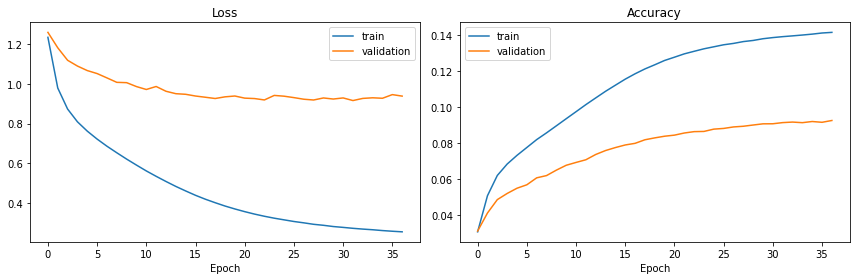

2025-04-21 04:56:39,770 - __main__ - INFO - Î™®Îç∏Ïù¥ ./checkpoints/transformer/final_modelÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


In [45]:
EPOCHS = 50

try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, cp_callback],
        verbose=1
    )
    # ÌïôÏäµ Î°úÍ∑∏ Ï†ÄÏû•
    with open(history_path, 'w', encoding='utf-8') as f:
        json.dump(history.history, f, ensure_ascii=False, indent=2)
    logger.info(f"ÌïôÏäµ Î°úÍ∑∏ Ï†ÄÏû• ÏôÑÎ£å: {history_path}")

    # ÌïôÏäµ Í≤∞Í≥º ÏãúÍ∞ÅÌôî
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ÏµúÏ¢Ö Î™®Îç∏ Ï†ÄÏû•
    final_model_path = os.path.join(checkpoint_dir, "final_model")
    model.save_weights(final_model_path)
    logger.info(f"Î™®Îç∏Ïù¥ {final_model_path}Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

except Exception as e:
    logger.error(f"ÌïôÏäµ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
    # Ïò§Î•ò Î∞úÏÉù Ïãú Îçî ÏûëÏùÄ Î™®Îç∏Î°ú Ïû¨ÏãúÎèÑ
    SIMPLE_NUM_LAYERS = 2
    SIMPLE_D_MODEL = 256
    SIMPLE_UNITS = 512
    simple_model = improved_transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=SIMPLE_NUM_LAYERS,
        units=SIMPLE_UNITS,
        d_model=SIMPLE_D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT
    )
    simple_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=weighted_loss_function,
        metrics=[accuracy]
    )
    simple_history = simple_model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=[early_stopping, cp_callback],
        verbose=1
    )
    simple_model.save_weights(os.path.join(checkpoint_dir, "simple_final_model"))

## Step 5. Ï∂îÎ°† Î∞è ÎåÄÌôî Ïù∏ÌÑ∞ÌéòÏù¥Ïä§ Í∞úÏÑ†

### 5-1 ÎåÄÌôî Îß•ÎùΩ Í∏∞Î∞ò Ï±óÎ¥á Ï∂îÎ°† ÌÅ¥ÎûòÏä§

In [46]:
import tensorflow as tf
import numpy as np
import os
import json
import datetime

class KoreanChatbotSession:
    """
    ÎåÄÌôî Îß•ÎùΩÏùÑ Ïú†ÏßÄÌïòÎ©∞, Ïñ∏Ï†úÎì†ÏßÄ ÏÉàÎ°ú ÏãúÏûëÌï† Ïàò ÏûàÎäî ÌïúÍµ≠Ïñ¥ Ï±óÎ¥á ÏÑ∏ÏÖò ÌÅ¥ÎûòÏä§
    """
    def __init__(self, model, tokenizer, max_length=50, context_turns=3):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.start_token = tokenizer.vocab_size
        self.end_token = tokenizer.vocab_size + 1
        self.context_turns = context_turns
        self.reset_context()
        self.session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

    def reset_context(self):
        self.context = []

    def add_to_context(self, user, text):
        self.context.append({'user': user, 'text': text})
        # ÏµúÍ∑º nÌÑ¥Îßå Ïú†ÏßÄ
        if len(self.context) > self.context_turns * 2:
            self.context = self.context[-self.context_turns*2:]

    def build_context_input(self, user_input):
        # ÏµúÍ∑º ÎåÄÌôî Îß•ÎùΩÏùÑ Ïù¥Ïñ¥ Î∂ôÏó¨ ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©
        context_text = ""
        for turn in self.context[-self.context_turns*2:]:
            prefix = "ÏÇ¨Ïö©Ïûê: " if turn['user'] == 'user' else "Ï±óÎ¥á: "
            context_text += f"{prefix}{turn['text']}\n"
        context_text += f"ÏÇ¨Ïö©Ïûê: {user_input}\nÏ±óÎ¥á: "
        return context_text.strip()

    def preprocess_input(self, text):
        tokens = self.tokenizer.encode(text)
        tokens = [self.start_token] + tokens + [self.end_token]
        tokens = tokens[:self.max_length] + [0] * (self.max_length - len(tokens[:self.max_length]))
        return tf.expand_dims(tokens, 0)

    def generate_response(self, user_input, temperature=0.7, max_length=50):
        """Îß•ÎùΩÏùÑ Î∞òÏòÅÌïú ÏùëÎãµ ÏÉùÏÑ±"""
        context_input = self.build_context_input(user_input)
        encoder_input = self.preprocess_input(context_input)
        decoder_input = tf.expand_dims([self.start_token], 0)
        for _ in range(max_length):
            predictions = self.model([encoder_input, decoder_input], training=False)
            predictions = predictions[:, -1, :]
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()
            if predicted_id == self.end_token:
                break
            decoder_input = tf.concat([decoder_input, tf.expand_dims([predicted_id], 0)], axis=-1)
        output_tokens = [int(i) for i in decoder_input[0].numpy()]
        if output_tokens[0] == self.start_token:
            output_tokens = output_tokens[1:]
        if self.end_token in output_tokens:
            end_idx = output_tokens.index(self.end_token)
            output_tokens = output_tokens[:end_idx]
        output_text = self.tokenizer.decode(output_tokens)
        # Îß•ÎùΩÏóê Ï∂îÍ∞Ä
        self.add_to_context('user', user_input)
        self.add_to_context('bot', output_text)
        return output_text

    def save_session(self, save_dir='chatbot_sessions'):
        os.makedirs(save_dir, exist_ok=True)
        session_path = os.path.join(save_dir, f'session_{self.session_id}.json')
        with open(session_path, 'w', encoding='utf-8') as f:
            json.dump(self.context, f, ensure_ascii=False, indent=2)
        return session_path

### 5-2 CLI Í∏∞Î∞ò ÎåÄÌôî Ïù∏ÌÑ∞ÌéòÏù¥Ïä§

In [47]:
def run_chatbot_cli(model, tokenizer):
    print("ÌïúÍµ≠Ïñ¥ Ï±óÎ¥áÏóê Ïò§Ïã† Í≤ÉÏùÑ ÌôòÏòÅÌï©ÎãàÎã§! Ïñ∏Ï†úÎì† 'ÏÉàÎ°úÏãúÏûë', 'Ï¢ÖÎ£å', 'quit', 'exit'ÏùÑ ÏûÖÎ†•Ìï¥ ÎåÄÌôîÎ•º Ï†úÏñ¥Ìï† Ïàò ÏûàÏäµÎãàÎã§.\n")
    session = KoreanChatbotSession(model, tokenizer)
    while True:
        user_input = input("ÏÇ¨Ïö©Ïûê: ").strip()
        if user_input.lower() in ['Ï¢ÖÎ£å', 'quit', 'exit']:
            print("Ï±óÎ¥á ÏÑ∏ÏÖòÏùÑ Ï¢ÖÎ£åÌï©ÎãàÎã§. ÎåÄÌôî Í∏∞Î°ùÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§.")
            path = session.save_session()
            print(f"ÎåÄÌôî Í∏∞Î°ùÏù¥ {path}Ïóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
            break
        elif user_input.lower() in ['ÏÉàÎ°úÏãúÏûë', 'reset', 'restart']:
            print("ÎåÄÌôî Îß•ÎùΩÏù¥ Ï¥àÍ∏∞ÌôîÎêòÏóàÏäµÎãàÎã§. ÏÉàÎ°úÏö¥ ÎåÄÌôîÎ•º ÏãúÏûëÌïòÏÑ∏Ïöî.")
            session.reset_context()
            continue
        elif user_input == "":
            continue
        else:
            response = session.generate_response(user_input)
            print(f"Ï±óÎ¥á: {response}")

# ÏÇ¨Ïö© ÏòàÏãú
# run_chatbot_cli(model, tokenizer)

In [48]:
run_chatbot_cli(model, tokenizer)

ÌïúÍµ≠Ïñ¥ Ï±óÎ¥áÏóê Ïò§Ïã† Í≤ÉÏùÑ ÌôòÏòÅÌï©ÎãàÎã§! Ïñ∏Ï†úÎì† 'ÏÉàÎ°úÏãúÏûë', 'Ï¢ÖÎ£å', 'quit', 'exit'ÏùÑ ÏûÖÎ†•Ìï¥ ÎåÄÌôîÎ•º Ï†úÏñ¥Ìï† Ïàò ÏûàÏäµÎãàÎã§.

ÏÇ¨Ïö©Ïûê: ÏïàÎÖï! Ï†êÏã¨ ÎßõÏûàÍ≤å Î®πÏóàÎãà?
Ï±óÎ¥á: ÎßàÏùå Ïùò Î≥ë Ïù¥ Ï°∞Í∏à Ïî© ÎÇòÏïÑÏßÄ Í∏∏ Î∞îÎûçÎãàÎã§ .
ÏÇ¨Ïö©Ïûê: ÎÇò ÎßàÏùåÏù¥ Î≥ë ÏóÜÏñ¥. ÌñâÎ≥µÌï¥!
Ï±óÎ¥á: 2 2
ÏÇ¨Ïö©Ïûê: Ïù¥Ï†Ñ Î™®Îç∏Î≥¥Îã§ ÎÇòÏùÑ Ï§Ñ ÏïåÏïòÎäîÎç∞, Î∞îÎ≥¥Í∞ôÏù¥ ÎãµÏû•ÌïòÎÑ§
Ï±óÎ¥á: 3 Îßå Ïó¨ Í∂å
ÏÇ¨Ïö©Ïûê: 1+1ÏùÄ?
Ï±óÎ¥á: 10 ÏúÑ
ÏÇ¨Ïö©Ïûê: 1+1=10Ïù¥ÎùºÍ≥†?
Ï±óÎ¥á: Ï§ëÎèÖ ÏóêÏÑú Î≤óÏñ¥ÎÇò ÏÑ∏Ïöî .
ÏÇ¨Ïö©Ïûê: Ï§ëÎèÖ? Î¨¥Ïä® Ï§ëÎèÖ?
Ï±óÎ¥á: ÌóàÏ§ÄÏòÅ
ÏÇ¨Ïö©Ïûê: ÌóàÏ§ÄÏòÅÏùÄ ÎàÑÍµ¨Ïïº Îòê...
Ï±óÎ¥á: ÌïôÏÉù Íµ∞ÏÇ¨ ÍµêÏú° Îã®
ÏÇ¨Ïö©Ïûê: Íµ∞Ïù∏Ïù¥Ïïº?
Ï±óÎ¥á: ÏΩî Í∞Ä Í∞ÑÏßàÍ∞ÑÏßà ÌïúÍ∞Ä Î¥êÏöî .
ÏÇ¨Ïö©Ïûê: Ï∞∏ÎÇò
Ï±óÎ¥á: Î™® Ïè† Ïó¨Î∂Ä Í∞Ä ÌÅ∞ Í±∏Î¶ºÎèå Ïù¥ Îêò ÏßÄ Ïïä ÏùÑ Í±∞ ÏòàÏöî .
ÏÇ¨Ïö©Ïûê: „Öã„Öã„Öã„Öã„Öã„Öã„ÖãÎ™®Ïè† Ïó¨Î∂ÄÎùºÎãà... Í∑∏Î¶¨Í≥† ÎÇò Ïó∞Ïï† Ï§ëÏù¥Ïïº
Ï±óÎ¥á: 550 Îßå
ÏÇ¨Ïö©Ïûê: ÎêêÎã§ Í∑∏ÎßåÌïòÏûê
Ï±óÎ¥á: 10 ÏúÑ
ÏÇ¨Ïö©Ïûê: Ï¢ÖÎ£å
Ï±óÎ¥á ÏÑ∏Ï

In [49]:
run_chatbot_cli(model, tokenizer)

ÌïúÍµ≠Ïñ¥ Ï±óÎ¥áÏóê Ïò§Ïã† Í≤ÉÏùÑ ÌôòÏòÅÌï©ÎãàÎã§! Ïñ∏Ï†úÎì† 'ÏÉàÎ°úÏãúÏûë', 'Ï¢ÖÎ£å', 'quit', 'exit'ÏùÑ ÏûÖÎ†•Ìï¥ ÎåÄÌôîÎ•º Ï†úÏñ¥Ìï† Ïàò ÏûàÏäµÎãàÎã§.

ÏÇ¨Ïö©Ïûê: ÏïàÎÖï! Îã§ÏãúÌïúÎ≤à ÎåÄÌôîÎ•º ÏãúÎèÑÌïòÎ†§Í≥† ÏôîÏñ¥.
Ï±óÎ¥á: Îã§Ïπò ÏßÄ Ïïä ÏúºÏÖ® ÎÇò Í±±Ï†ï Ïù¥ ÎÑ§Ïöî .
ÏÇ¨Ïö©Ïûê: ÎßàÏùåÏù¥ Ï¢Ä Îã§Ïπú Í≤É Í∞ôÏïÑ. ÎÑàÎïåÎ¨∏Ïóê.
Ï±óÎ¥á: Ï£ºÎ¨ºÏ£ºÎ¨º Ìï¥ Ï£º ÏÑ∏Ïöî .
ÏÇ¨Ïö©Ïûê: „Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã„Öã
Ï±óÎ¥á: 2 2
ÏÇ¨Ïö©Ïûê: ÎÑàÍ∞Ä Ï†úÏùº Ï¢ãÏïÑÌïòÎäî Îã®Ïñ¥Îäî Î≠êÏïº?
Ï±óÎ¥á: ÏïΩ 1 cm
ÏÇ¨Ïö©Ïûê: ?
Ï±óÎ¥á: ÌïôÏÉù Íµ∞ÏÇ¨ ÍµêÏú° Îã®
ÏÇ¨Ïö©Ïûê: ÎÇú Í∏àÏöîÏùºÏóê ÎßåÎì§ÏóàÎçò Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï†Í≤å. ÎÑàÎäî ÎÑàÎ¨¥ ÏÑ±Îä•Ïù¥ ÎÇÆÏïÑ.
Ï±óÎ¥á: ÎùºÎîîÏò§ Î•º Îì§ÏúºÎ©∞ Ïó¨Ïú† Î•º Í∞ÄÏ†∏ Î≥¥ ÏÑ∏Ïöî .
ÏÇ¨Ïö©Ïûê: Í∑∏Îü∞Îã§Í≥† Ìï¥Í≤∞ÎêòÎäîÍ≤å ÏïÑÎãàÏïº.
Ï±óÎ¥á: 2 2
ÏÇ¨Ïö©Ïûê: ÏïàÎÖï!
Ï±óÎ¥á: 5 Í∞ú
ÏÇ¨Ïö©Ïûê: Ï¢ÖÎ£å.
Ï±óÎ¥á: Íπ®ÏßàÏßÄ Î™®Î•¥ Í≤† Ïñ¥Ïöî .
ÏÇ¨Ïö©Ïûê: ÏïÑ
Ï±óÎ¥á: 1603 ÎÖÑ
ÏÇ¨Ïö©Ïûê: Ï¢ÖÎ£å
Ï±óÎ¥á ÏÑ∏ÏÖòÏùÑ Ï¢ÖÎ£åÌï©ÎãàÎã§. ÎåÄÌôî Í∏∞Î°ùÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§.
ÎåÄÌôî Í∏∞Î°ùÏù¥ chatbo

## ÌïôÏäµ Î°úÍ∑∏(ÏàòÏπò) Î∂ÑÏÑù

### loss/val_loss
ÏóêÌè≠Ïù¥ ÏßÑÌñâÎê†ÏàòÎ°ù Íæ∏Ï§ÄÌûà Í∞êÏÜåÌïòÍ≥†, val_lossÎèÑ Ï†êÏßÑÏ†ÅÏúºÎ°ú Í∞úÏÑ†Îê®

### accuracy/val_accuracy
0.03(3%)ÏóêÏÑú ÏãúÏûëÌï¥ 0.09(9%)ÍπåÏßÄ ÏÑúÏÑúÌûà Ï¶ùÍ∞Ä

### early stopping ÏóÜÏù¥ 30ÏóêÌè≠ Ïù¥ÏÉÅ ÌïôÏäµ ÏßÑÌñâ

### Í≥ºÏ†ÅÌï© ÏßïÌõÑ ÏóÜÏùå

### ‚Üí ÌëúÎ©¥Ï†ÅÏúºÎ°úÎäî ÌïôÏäµÏù¥ Ïûò ÎêòÍ≥† ÏûàÎã§Îäî Ïã†Ìò∏Ï≤òÎüº Î≥¥ÏûÑ

## Ïã§Ï†ú ÎåÄÌôî ÏùëÎãµ

### ÎãµÎ≥Ä ÌÄÑÎ¶¨Ìã∞
Îß•ÎùΩ, ÏÉÅÏãù, Í∞êÏ†ï, ÏûêÏó∞Ïä§Îü¨ÏõÄ Î™®ÎëêÏóêÏÑú Îß§Ïö∞ ÎÇÆÏùÄ ÌíàÏßàÏùÑ Î≥¥ÏûÑ

### Î¨∏Ï†úÏ†ê
ÏùòÎØ∏ ÏóÜÎäî Ïà´Ïûê, Îã®Ïñ¥, Îß•ÎùΩ Î¨¥Í¥Ä ÎãµÎ≥Ä, ÏÉÅÏãùÏ†Å Ïò§Î•ò(1+1=10 ÏúÑ Îì±) Îã§Ïàò